In [1]:
from numpy import *
import numpy as np
import math
import pickle
import pyfftw
from IPython.display import display, Markdown, Math
from matplotlib.pyplot import *

In [2]:
#Constants
G=6.67428*10**-8; # cm^3 g^-1 s^-2
kpc=3.085678*10**21; # 1kpc = 3.08 10^21 cm
mass=10**7*2.0*10**33; # 10^7 solar mass = 2 10^33 g with ~10^4 stars


In [3]:
F = open("Positions_stars_2D.txt", "r")
F.seek(0)

numStars=0
while F.readline() :
    numStars+=1
    
F.close()

F = open("Positions_stars_2D.txt", "r")
star_positions = np.zeros(shape=(numStars,2))
for i in range (numStars-1):
    str_list = F.readline()
    new_list = str_list.split()

    star_positions[i][0] = float(new_list[0])
    star_positions[i][1] = float(new_list[1])
F.close()

print(numStars)
print(star_positions[1000][1])

10240
-1.493099


In [4]:
numPoints = 256

In [5]:
# Compute the spacing of all cells
Max=np.max(star_positions, axis=0)
Min=np.min(star_positions, axis=0)

Max_x=Max[0]
Min_x=Min[0]
Max_y=Max[1]
Min_y=Min[1]

if (Max_x>abs(Min_x)):
    space_x=Max_x/(numPoints/2)
    add_correction_x=0
else:
    space_x=abs(Min_x)/(numPoints/2)
    add_correction_x=1

if (Max_y>abs(Min_y)):
    space_y=Max_y/(numPoints/2)
    add_correction_y=0
else:
    space_y=abs(Min_y)/(numPoints/2)
    add_correction_y=1
print(space_x)
print(space_y)
print(add_correction_x)
print(add_correction_y)

0.200826890625
0.1719680703125
1
1


In [6]:
TYPE = "complex128"
# Initialization of Green and density
green_grid = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)
density_grid = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)

In [7]:
# Computing the density for each cell with Cloud-in-cell method
for i in range (numStars-1):
    #Computing node positions on mesh
    #floor takes each element of the array to the nearest integer less than or equal to 
    #that element
    #Une sorte de normalisation des valeurs de x pour leur assigner une coordonnée en i,j avec
    #i et j allant de 0 a 255
    
    node_x = int(math.floor(star_positions[i][0]/space_x) + (numPoints/2 + add_correction_x))-1
    node_y = int(math.floor(star_positions[i][1]/space_y) + (numPoints/2 + add_correction_y))-1
    
    #Set the CIC size fractions using fmod 
    dx = math.fmod(abs(star_positions[i][0]),space_x)/space_x
    dy = math.fmod(abs(star_positions[i][1]),space_y)/space_y
    tx = 1.0 - dx
    ty = 1.0 - dy
    
    #Adding for setting CIC size fractions
    #Version with (i,j) centered on cells
    #Begining of the mesh on x condition 
    if ((dx < 0.5) and (node_x == 0)):
        frac_x = dx
        neighboor_x = 0
        epsilon_x = 0
   #End of the mesh on x condition
    elif ((dx > 0.5) and (node_x == numPoints-1)) :
        frac_x = dx - 0.5
        neighboor_x = 0
        epsilon_x = 0
    #Not on the borders of the mesh on x
    elif (dx < 0.5):
        frac_x = dx + 0.5
        neighboor_x = -1
        epsilon_x = 1
    else : 
        frac_x = tx + 0.5
        neighboor_x = 1
        epsilon_x = 1
    
    #Begining of the mesh on y condition 
    if ((dy < 0.5) and (node_y == 0)):
        frac_y = dy
        neighboor_y = 0
        epsilon_y = 0
    #End of the mesh on y condition 
    elif ((dy > 0.5) and (node_y == numPoints-1)):
        frac_y = dy - 0.5
        neighboor_y = 0
        epsilon_y = 0
    #Not on the borders of the mesh on y
    elif (dy < 0.5):
        frac_y = dy + 0.5
        neighboor_y = -1
        epsilon_y = 1
    else: 
        frac_y = ty + 0.5
        neighboor_y = 1
        epsilon_y = 1
   
    #Computation of the Density with CIC fractions in each points given 
    density_grid[node_x][node_y] = density_grid[node_x][node_y] + mass*(frac_x*frac_y)/(space_x*space_y)
    
    density_grid[node_x+neighboor_x][node_y] = density_grid[node_x+neighboor_x][node_y] + mass*(epsilon_x*(1.0-frac_x)*frac_y)/(space_x*space_y)

    density_grid[node_x][node_y+neighboor_y] = density_grid[node_x][node_y+neighboor_y] + mass*(frac_x*epsilon_y*(1.0-frac_y))/(space_x*space_y)
    
    density_grid[node_x+neighboor_x][node_y+neighboor_y] = density_grid[node_x+neighboor_x][node_y+neighboor_y] + mass*(epsilon_x*(1.0-frac_x)*epsilon_y*(1.0-frac_y))/(space_x*space_y)
    
density_grid_tr = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)

density_grid_tr = density_grid.T

print(node_x)
print(node_y)

136
160


In [8]:
print(density_grid[136][160])

(8.56540450110599e+41+0j)


In [9]:
#Computing discretized Green's function
for i in range (numPoints):
    for j in range (numPoints):
        dx = sqrt((i-numPoints/2-add_correction_x)*(i-numPoints/2-add_correction_x))*space_x
        dy = sqrt((j-numPoints/2-add_correction_y)*(j-numPoints/2-add_correction_y))*space_y
        #Discretized Green's function  
        if (i!=int(numPoints/2+add_correction_x) and j!=int(numPoints/2+add_correction_y)):
            green_grid[i][j] = -1.0/(4.0*np.pi*np.sqrt(dx*dx + dy*dy))
        #Avoid division by 0
        else :
            green_grid[i][j] = 1.0 

green_grid_tr = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)

green_grid_tr = green_grid.T

In [10]:
TYPE = "complex128"
tf_green = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)
tf_density = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)
ifft_potentiel = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)

In [11]:
fft_object_green = pyfftw.FFTW(green_grid_tr, tf_green, axes=(0,1))

fft_object_density = pyfftw.FFTW(density_grid_tr, tf_density, axes=(0,1))

tf_green = fft_object_green(green_grid_tr)

tf_density = fft_object_density(density_grid_tr)

tf_product = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)

tf_product = 4*np.pi*G*tf_green*tf_density

potential_grid = pyfftw.empty_aligned((numPoints,numPoints), dtype=TYPE)

ifft_object_2d = pyfftw.FFTW(tf_product, potential_grid, axes=(0,1), direction="FFTW_BACKWARD")

potential = np.zeros((numPoints,numPoints))

potential_grid = ifft_object_2d(tf_product)

potential = potential_grid.real*(space_x*space_y)/kpc

potential_shift=np.fft.fftshift(potential)

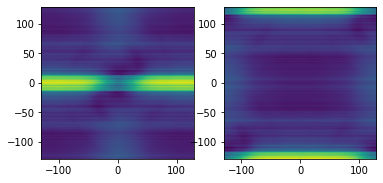

In [14]:
figures,ax = subplots(1,2)
stretch = (-(numPoints/2+add_correction_x), +numPoints/2+add_correction_x, -(numPoints/2+add_correction_x), numPoints/2+add_correction_x)

ax[0].imshow(potential_shift,extent=stretch),\

ax[1].imshow(potential,extent=stretch)
show()

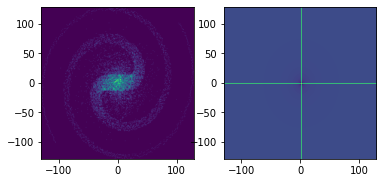

In [15]:
figures,ax = subplots(1,2)
stretch = (-(numPoints/2+add_correction_x), +numPoints/2+add_correction_x, -(numPoints/2+add_correction_x), numPoints/2+add_correction_x)

ax[0].imshow(density_grid_tr.real,extent=stretch),\

ax[1].imshow(green_grid_tr.real,extent=stretch)
show()

In [17]:
for i in range (numPoints):
    for j in range (numPoints):
        if (green_grid[i][j]!=0):
            print(green_grid[i][j])

(-0.0023436432905194564+0j)
(-0.002351406597575049+0j)
(-0.0023591862446607145+0j)
(-0.002366981691024323+0j)
(-0.002374792379534899+0j)
(-0.002382617736425013+0j)
(-0.002390457171034739+0j)
(-0.002398310075557502+0j)
(-0.002406175824788129+0j)
(-0.0024140537758734694+0j)
(-0.0024219432680659156+0j)
(-0.002429843622480217+0j)
(-0.002437754141853959+0j)
(-0.0024456741103121163+0j)
(-0.002453602793136077+0j)
(-0.00246153943653759+0j)
(-0.0024694832674380628+0j)
(-0.0024774334932536656+0j)
(-0.002485389301686725+0j)
(-0.002493349860523879+0j)
(-0.0025013143174415172+0j)
(-0.0025092817998189883+0j)
(-0.002517251414560133+0j)
(-0.002525222247923676+0j)
(-0.0025331933653630215+0j)
(-0.002541163811376042+0j)
(-0.0025491326093654283+0j)
(-0.0025570987615102063+0j)
(-0.0025650612486490107+0j)
(-0.0025730190301757614+0j)
(-0.0025809710439483424+0j)
(-0.0025889162062109443+0j)
(-0.002596853411530707+0j)
(-0.00260478153274933+0j)
(-0.002612699420950301+0j)
(-0.0026206059054424365+0j)
(-0.002628499

(-0.002770755053237444+0j)
(-0.0027785860594406416+0j)
(-0.0027863828091370326+0j)
(-0.0027941436835361116+0j)
(-0.0028018670437244307+0j)
(-0.0028095512311209+0j)
(-0.0028171945679643694+0j)
(-0.0028247953578340278+0j)
(-0.0028323518862030986+0j)
(-0.002839862421026293+0j)
(-0.002847325213361402+0j)
(-0.0028547384980254064+0j)
(-0.002862100494285395+0j)
(-0.002869409406584549+0j)
(-0.0028766634253033882+0j)
(-0.002883860727556422+0j)
(-0.0028909994780242656+0j)
(-0.002898077829821252+0j)
(-0.0029050939253984576+0j)
(-0.002912045897482035+0j)
(-0.002918931870046636+0j)
(-0.0029257499593236466+0j)
(-0.0029324982748438885+0j)
(-0.002939174920514328+0j)
(-0.002945777995728293+0j)
(-0.0029523055965085723+0j)
(-0.002958755816682716+0j)
(-0.0029651267490897466+0j)
(-0.0029714164868174173+0j)
(-0.002977623124469035+0j)
(-0.002983744759458818+0j)
(-0.0029897794933346224+0j)
(-0.0029957254331267973+0j)
(-0.0030015806927218415+0j)
(-0.0030073433942594302+0j)
(-0.0030130116695512928+0j)
(-0.00301

(-0.0026634340915501534+0j)
(-0.002671900741433509+0j)
(-0.0026803587182757786+0j)
(-0.002688806743483179+0j)
(-0.002697243512961646+0j)
(-0.0027056676970966045+0j)
(-0.0027140779407539327+0j)
(-0.0027224728633030155+0j)
(-0.0027308510586627603+0j)
(-0.0027392110953714647+0j)
(-0.00274755151668144+0j)
(-0.0027558708406792472+0j)
(-0.0027641675604324623+0j)
(-0.0027724401441638273+0j)
(-0.002780687035453671+0j)
(-0.0027889066534714547+0j)
(-0.0027970973932373014+0j)
(-0.0028052576259143262+0j)
(-0.0028133856991326028+0j)
(-0.00282147993734555+0j)
(-0.0028295386422195166+0j)
(-0.0028375600930573043+0j)
(-0.002845542547256347+0j)
(-0.0028534842408022335+0j)
(-0.00286138338879821+0j)
(-0.002869238186031277+0j)
(-0.0028770468075754387+0j)
(-0.0028848074094326216+0j)
(-0.002892518129211734+0j)
(-0.0029001770868462653+0j)
(-0.0029077823853507997+0j)
(-0.0029153321116167146+0j)
(-0.002922824337247312+0j)
(-0.002930257119432537+0j)
(-0.0029376285018633667+0j)
(-0.002944936515685893+0j)
(-0.0029

(-0.0030579306395145576+0j)
(-0.0030646965952378365+0j)
(-0.0030713723479305387+0j)
(-0.0030779557307908994+0j)
(-0.0030844445809281983+0j)
(-0.0030908367409811376+0j)
(-0.00309713006076828+0j)
(-0.0031033223989687564+0j)
(-0.0031094116248313367+0j)
(-0.0031153956199098496+0j)
(-0.0031212722798227956+0j)
(-0.003127039516034884+0j)
(-0.0031326952576581244+0j)
(-0.003138237453269968+0j)
(-0.0031436640727458913+0j)
(-0.0031489731091037315+0j)
(-0.0031541625803569403+0j)
(-0.0031592305313738653+0j)
(-0.00316417503574007+0j)
(-0.0031689941976205996+0j)
(-0.0031736861536190582+0j)
(-0.003178249074630263+0j)
(-0.0031826811676832073+0j)
(-0.003186980677770986+0j)
(-0.003191145889664318+0j)
(-0.0031951751297052515+0j)
(-0.003199066767577614+0j)
(-0.003202819218050761+0j)
(-0.003206430942693175+0j)
(-0.00320990045155245+0j)
(-0.0032132263047982565+0j)
(-0.003216407114324857+0j)
(-0.0032194415453098376+0j)
(-0.003222328317725714+0j)
(-0.003225066207801181+0j)
(-0.0032276540494288225+0j)
(-0.00323

(-0.002724173528427388+0j)
(-0.0027151083786962093+0j)
(-0.002706040585934109+0j)
(-0.0026969714281039805+0j)
(-0.002687902153955231+0j)
(-0.002678833983222427+0j)
(-0.0026697681068409097+0j)
(-0.002660705687178412+0j)
(-0.0026516478582816884+0j)
(-0.002642595726137244+0j)
(-0.002633550368945234+0j)
(-0.0026245128374056542+0j)
(-0.0026154841550159545+0j)
(-0.0026064653183792306+0j)
(-0.002597457297522198+0j)
(-0.002588461036222141+0j)
(-0.0025794774523420954+0j)
(-0.002570507438173514+0j)
(-0.002561551860785713+0j)
(-0.002552611562381422+0j)
(-0.002543687360657766+0j)
(-0.0025347800491720618+0j)
(-0.002525890397711813+0j)
(-0.002517019152668325+0j)
(-0.0025081670374133857+0j)
(-0.00249933475267847+0j)
(-0.002490522976935972+0j)
(-0.002481732366781965+0j)
(-0.0024729635573200355+0j)
(-0.0024642171625457536+0j)
(-0.0024554937757313463+0j)
(-0.002440454897527379+0j)
(-0.002449224235216213+0j)
(-0.0024580194336394382+0j)
(-0.00246683996247846+0j)
(-0.00247568527143126+0j)
(-0.0024845547898

(-0.003286520183462488+0j)
(-0.003292087829162291+0j)
(-0.003297516407948268+0j)
(-0.003302803664242588+0j)
(-0.0033079473816139283+0j)
(-0.0033129453851621564+0j)
(-0.0033177955438914563+0j)
(-0.0033224957730672543+0j)
(-0.0033270440365522377+0j)
(-0.0033314383491167094+0j)
(-0.0033356767787184956+0j)
(-0.0033397574487475635+0j)
(-0.0033436785402305483+0j)
(-0.003347438293990357+0j)
(-0.0033510350127560493+0j)
(-0.003354467063218264+0j)
(-0.003357732878025471+0j)
(-0.0033608309577164456+0j)
(-0.003363759872584432+0j)
(-0.0033665182644685688+0j)
(-0.003369104848468302+0j)
(-0.0033715184145766087+0j)
(-0.003373757829228058+0j)
(-0.00337582203675788+0j)
(-0.003377710060768419+0j)
(-0.0033794210053995355+0j)
(-0.0033809540564997704+0j)
(-0.003382308482695263+0j)
(-0.003383483636353734+0j)
(-0.00338447895444101+0j)
(-0.0033852939592679205+0j)
(-0.003385928259125608+0j)
(-0.0033863815488076013+0j)
(-0.003386653610017301+0j)
(1+0j)
(-0.003386653610017301+0j)
(-0.0033863815488076013+0j)
(-0.0

(-0.0028092778792003273+0j)
(-0.002799237020795386+0j)
(-0.0027892017223864743+0j)
(-0.0027791733355295107+0j)
(-0.002769153175947437+0j)
(-0.002759142523923305+0j)
(-0.0027491426247093966+0j)
(-0.002739154688951135+0j)
(-0.002729179893124565+0j)
(-0.002719219379986243+0j)
(-0.002709274259034398+0j)
(-0.002699345606980282+0j)
(-0.002689434468228659+0j)
(-0.0026795418553664297+0j)
(-0.0026696687496584183+0j)
(-0.0026598161015494092+0j)
(-0.0026499848311715398+0j)
(-0.0026401758288561953+0j)
(-0.0026303899556496184+0j)
(-0.002620628043831439+0j)
(-0.0026108908974354114+0j)
(-0.002601179292771643+0j)
(-0.002591493978949675+0j)
(-0.002581835678401764+0j)
(-0.002572205087405793+0j)
(-0.0025626028766072323+0j)
(-0.002553029691539641+0j)
(-0.0025434861531431945+0j)
(-0.0025339728582807774+0j)
(-0.0025244903802512115+0j)
(-0.0025075536248611568+0j)
(-0.0025170692164626822+0j)
(-0.0025266186376973346+0j)
(-0.002536201389922273+0j)
(-0.0025458169520406054+0j)
(-0.0025554647799770377+0j)
(-0.0025

(-0.002753059333624706+0j)
(-0.0027426433471131628+0j)
(-0.002732249439757883+0j)
(-0.0027218786375353414+0j)
(-0.0027115319323387952+0j)
(-0.0027012102825831876+0j)
(-0.0026909146138136097+0j)
(-0.002680645819316409+0j)
(-0.0026704047607320944+0j)
(-0.002660192268669201+0j)
(-0.0026500091433183607+0j)
(-0.0026398561550658372+0j)
(-0.0026297340451058382+0j)
(-0.00261964352605096+0j)
(-0.0026095852825401495+0j)
(-0.0025995599718436216+0j)
(-0.002589568224464183+0j)
(-0.00257961064473448+0j)
(-0.0025696878114096914+0j)
(-0.0025598002782552436+0j)
(-0.0025418340100562603+0j)
(-0.0025517467750568704+0j)
(-0.0025616979179198555+0j)
(-0.002571686965822836+0j)
(-0.002581713422287155+0j)
(-0.0025917767665833685+0j)
(-0.00260187645312985+0j)
(-0.002612011910884874+0j)
(-0.0026221825427325133+0j)
(-0.0026323877248627557+0j)
(-0.00264262680614627+0j)
(-0.002652899107504274+0j)
(-0.002663203921274006+0j)
(-0.0026735405105703324+0j)
(-0.0026839081086440604+0j)
(-0.0026943059182375742+0j)
(-0.002704

(-0.002724907854693595+0j)
(-0.002714059763548091+0j)
(-0.002703247954696899+0j)
(-0.0026924731782612056+0j)
(-0.0026817361524719943+0j)
(-0.0026710375644122463+0j)
(-0.0026603780707530255+0j)
(-0.0026497582984828837+0j)
(-0.002639178845630071+0j)
(-0.002628640281977081+0j)
(-0.0026181431497670784+0j)
(-0.0026076879644018314+0j)
(-0.0025882600962335678+0j)
(-0.002598728266741483+0j)
(-0.002609241526428975+0j)
(-0.0026197994495853437+0j)
(-0.0026304015853338735+0j)
(-0.0026410474569349557+0j)
(-0.002651736561078734+0j)
(-0.002662468367167574+0j)
(-0.0026732423165886513+0j)
(-0.0026840578219770126+0j)
(-0.002694914266469493+0j)
(-0.0027058110029499114+0j)
(-0.002716747353286012+0j)
(-0.0027277226075586546+0j)
(-0.002738736023283815+0j)
(-0.0027497868246279832+0j)
(-0.0027608742016176206+0j)
(-0.0027719973093433643+0j)
(-0.002783155267159744+0j)
(-0.002794347157881198+0j)
(-0.002805572026975283+0j)
(-0.0028168288817539606+0j)
(-0.002828116690563988+0j)
(-0.0028394343819774176+0j)
(-0.0028

(-0.0035630861393740605+0j)
(-0.003572737030653703+0j)
(-0.0035822520742450196+0j)
(-0.0035916271618630794+0j)
(-0.0036008581848762226+0j)
(-0.0036099410382933956+0j)
(-0.0036188716248611356+0j)
(-0.003627645859264852+0j)
(-0.0036362596724285644+0j)
(-0.0036447090159067034+0j)
(-0.0036529898663610907+0j)
(-0.003661098230115669+0j)
(-0.0036690301477810827+0j)
(-0.0036767816989406858+0j)
(-0.0036843490068890956+0j)
(-0.003691728243413955+0j)
(-0.003698915633611086+0j)
(-0.0037059074607228727+0j)
(-0.003712700070989245+0j)
(-0.003719289878500341+0j)
(-0.0037256733700395607+0j)
(-0.003731847109905459+0j)
(-0.0037378077447006615+0j)
(-0.0037435520080757903+0j)
(-0.0037490767254162185+0j)
(-0.003754378818459362+0j)
(-0.003759455309830131+0j)
(-0.0037643033274821873+0j)
(-0.0037689201090326295+0j)
(-0.0037733030059778835+0j)
(-0.0037774494877786547+0j)
(-0.003781357145802047+0j)
(-0.003785023697109176+0j)
(-0.0037884469880769245+0j)
(-0.0037916249978428474+0j)
(-0.003794555841562648+0j)
(-0.0

(-0.0033180021676678362+0j)
(-0.003331302186030435+0j)
(-0.0033445887003834694+0j)
(-0.003357858646417435+0j)
(-0.003371108881374534+0j)
(-0.0033843361838874104+0j)
(-0.0033975372539164655+0j)
(-0.0034107087127910342+0j)
(-0.003423847103359797+0j)
(-0.0034369488902557563+0j)
(-0.003450010460281193+0j)
(-0.0034630281229179483+0j)
(-0.003475998110968396+0j)
(-0.0034889165813323767+0j)
(-0.0035017796159253272+0j)
(-0.0035145832227427344+0j)
(-0.0035273233370759047+0j)
(-0.0035399958228839157+0j)
(-0.0035525964743264166+0j)
(-0.003565121017461769+0j)
(-0.0035775651121147476+0j)
(-0.0035899243539177887+0j)
(-0.003602194276529456+0j)
(-0.0036143703540334636+0j)
(-0.003626448003521246+0j)
(-0.0036384225878606418+0j)
(-0.0036502894186528625+0j)
(-0.003662043759379413+0j)
(-0.0036736808287401454+0j)
(-0.0036851958041831273+0j)
(-0.0036965838256263666+0j)
(-0.0037078399993709116+0j)
(-0.0037189594022041714+0j)
(-0.003729937085691648+0j)
(-0.0037407680806545995+0j)
(-0.0037514474018304333+0j)
(-0

(-0.003700080769589436+0j)
(-0.0036874891542113767+0j)
(-0.0036747934513698317+0j)
(-0.0036619986262894583+0j)
(-0.0036491095806860255+0j)
(-0.0036361311498775356+0j)
(-0.0036230681001065642+0j)
(-0.0036099251260702345+0j)
(-0.003596706848653826+0j)
(-0.003583417812863605+0j)
(-0.0035700624859541265+0j)
(-0.0035566452557449528+0j)
(-0.0035431704291214476+0j)
(-0.00352964223071407+0j)
(-0.0035160648017504097+0j)
(-0.003502442199073998+0j)
(-0.003488778394323847+0j)
(-0.003475077273268513+0j)
(-0.0034613426352884374+0j)
(-0.0034475781930002466+0j)
(-0.0034337875720167033+0j)
(-0.0034199743108359543+0j)
(-0.003406141860853773+0j)
(-0.003392293586492545+0j)
(-0.003378432765440767+0j)
(-0.0033645625889969547+0j)
(-0.003350686162511912+0j)
(-0.003336806505923438+0j)
(-0.003322926554377665+0j)
(-0.003309049158931357+0j)
(-0.003295177087329622+0j)
(-0.003281313024853658+0j)
(-0.0032674595752332997+0j)
(-0.0032536192616192915+0j)
(-0.003239794527610389+0j)
(-0.003225987738330548+0j)
(-0.0032122

(-0.0027941994436725777+0j)
(-0.0027816011422858965+0j)
(-0.0027690725645299844+0j)
(-0.002744130353452187+0j)
(-0.002756615358919941+0j)
(-0.0027691731674424134+0j)
(-0.0027818036413014492+0j)
(-0.0027945066145279467+0j)
(-0.0028072818918183345+0j)
(-0.0028201292474225796+0j)
(-0.002833048424003482+0j)
(-0.002846039131467051+0j)
(-0.0028591010457637957+0j)
(-0.002872233807660818+0j)
(-0.002885437021484624+0j)
(-0.002898710253834632+0j)
(-0.002912053032267416+0j)
(-0.002925464843951759+0j)
(-0.0029389451342946935+0j)
(-0.0029524933055387315+0j)
(-0.002966108715330596+0j)
(-0.002979790675261821+0j)
(-0.0029935384493816855+0j)
(-0.0030073512526830365+0j)
(-0.0030212282495616347+0j)
(-0.003035168552249785+0j)
(-0.0030491712192251036+0j)
(-0.0030632352535953865+0j)
(-0.003077359601460686+0j)
(-0.0030915431502538+0j)
(-0.003105784727060539+0j)
(-0.0031200830969212623+0j)
(-0.0031344369611153344+0j)
(-0.003148844955430293+0j)
(-0.0031633056484177092+0j)
(-0.003177817539637853+0j)
(-0.0031923

(-0.003667786649701866+0j)
(-0.0036834399037330378+0j)
(-0.0036990589061207993+0j)
(-0.0037146389071079384+0j)
(-0.003730175037408262+0j)
(-0.003745662308693534+0j)
(-0.003761095614299552+0j)
(-0.003776469730161895+0j)
(-0.0037917793159917912+0j)
(-0.0038070189167024185+0j)
(-0.003822182964095773+0j)
(-0.003837265778820012+0j)
(-0.003852261572606857+0j)
(-0.0038671644507982925+0j)
(-0.0038819684151713625+0j)
(-0.0038966673670693553+0j)
(-0.003911255110847114+0j)
(-0.003925725357637539+0j)
(-0.003940071729445636+0j)
(-0.003954287763575674+0j)
(-0.003968366917396105+0j)
(-0.003982302573445973+0j)
(-0.003996088044885473+0j)
(-0.004009716581292228+0j)
(-0.004023181374803638+0j)
(-0.004036475566604401+0j)
(-0.0040495922537569515+0j)
(-0.0040625244963711695+0j)
(-0.0040752653251082205+0j)
(-0.004087807749011869+0j)
(-0.004100144763659006+0j)
(-0.004112269359619521+0j)
(-0.00412417453121394+0j)
(-0.004135853285555584+0j)
(-0.004147298651862266+0j)
(-0.004158503691020789+0j)
(-0.00416946150538

(-0.002999622870720263+0j)
(-0.0029852943836452235+0j)
(-0.0029710468040506613+0j)
(-0.002956880552126269+0j)
(-0.0029427960045576834+0j)
(-0.002928793496116044+0j)
(-0.00291487332120787+0j)
(-0.002901035735385436+0j)
(-0.0028872809568178982+0j)
(-0.00287360916772349+0j)
(-0.0028600205157631358+0j)
(-0.0028465151153959046+0j)
(-0.002833093049196741+0j)
(-0.002805693786506974+0j)
(-0.002819042212032215+0j)
(-0.002832476858600453+0j)
(-0.0028459977725140504+0j)
(-0.002859604972064671+0j)
(-0.0028732984462954496+0j)
(-0.0028870781537249307+0j)
(-0.0029009440210321456+0j)
(-0.0029148959417021904+0j)
(-0.0029289337746317397+0j)
(-0.002943057342693936+0j)
(-0.0029572664312621476+0j)
(-0.002971560786692134+0j)
(-0.002985940114762198+0j)
(-0.00300040407907097+0j)
(-0.0030149522993925316+0j)
(-0.003029584349988634+0j)
(-0.003044299757877864+0j)
(-0.0030590980010616778+0j)
(-0.0030739785067073143+0j)
(-0.003088940649287686+0j)
(-0.003103983748678461+0j)
(-0.00311910706821265+0j)
(-0.003134309812

(-0.004592999132558906+0j)
(-0.004589157832009536+0j)
(-0.004584875998220015+0j)
(-0.004580157360924036+0j)
(-0.004575006008794204+0j)
(-0.004569426379750163+0j)
(-0.004563423250531193+0j)
(-0.004557001725580367+0j)
(-0.004550167225289825+0j)
(-0.00454292547365876+0j)
(-0.004535282485417531+0j)
(-0.004527244552672543+0j)
(-0.004518818231127655+0j)
(-0.0045100103259384+0j)
(-0.004500827877255607+0j)
(-0.004491278145514943+0j)
(-0.004481368596528426+0j)
(-0.004471106886433269+0j)
(-0.004460500846552315+0j)
(-0.004449558468219035+0j)
(-0.004438287887618434+0j)
(-0.004426697370693383+0j)
(-0.004414795298163875+0j)
(-0.00440259015070437+0j)
(-0.00439009049432211+0j)
(-0.004377304965976624+0j)
(-0.004364242259478028+0j)
(-0.004350911111698975+0j)
(-0.004337320289132245+0j)
(-0.0043234785748231435+0j)
(-0.0043093947557029735+0j)
(-0.004295077610346936+0j)
(-0.004280535897176993+0j)
(-0.004265778343127373+0j)
(-0.0042508136327876435+0j)
(-0.004235650398035552+0j)
(-0.0042202972081692835+0j)
(-

(-0.003405957536512381+0j)
(-0.0033886535818569022+0j)
(-0.003371431738167472+0j)
(-0.0033542935688944675+0j)
(-0.003337240543437718+0j)
(-0.00332027404014899+0j)
(-0.00330339534928709+0j)
(-0.0032866056759232433+0j)
(-0.0032699061427946927+0j)
(-0.0032532977931047646+0j)
(-0.0032367815932678617+0j)
(-0.0032203584355981387+0j)
(-0.003204029140940797+0j)
(-0.003187794461245174+0j)
(-0.003171655082078985+0j)
(-0.0031556116250832625+0j)
(-0.0031396646503677036+0j)
(-0.003123814658846284+0j)
(-0.003108062094513156+0j)
(-0.0030924073466589647+0j)
(-0.003076850752027834+0j)
(-0.0030613925969153995+0j)
(-0.003046033119208335+0j)
(-0.0030307725103659523+0j)
(-0.0030156109173444853+0j)
(-0.003000548444464777+0j)
(-0.0029855851552241385+0j)
(-0.002970721074053209+0j)
(-0.0029559561880186957+0j)
(-0.0029412904484729095+0j)
(-0.0029267237726510716+0j)
(-0.002912256045217367+0j)
(-0.002897887119760776+0j)
(-0.002867832847091364+0j)
(-0.0028820925273412247+0j)
(-0.0028964535690400544+0j)
(-0.0029109

(-0.004522650948249203+0j)
(-0.004505682498120085+0j)
(-0.00448848126444746+0j)
(-0.00447105809206045+0j)
(-0.004453423722317528+0j)
(-0.0044355887808422995+0j)
(-0.0044175637660409+0j)
(-0.004399359038399331+0j)
(-0.004380984810555743+0j)
(-0.00436245113813956+0j)
(-0.00434376791136652+0j)
(-0.004324944847376113+0j)
(-0.004305991483295582+0j)
(-0.0042869171700125564+0j)
(-0.004267731066636562+0j)
(-0.00424844213562804+0j)
(-0.004229059138572154+0j)
(-0.004209590632573494+0j)
(-0.0041900449672468715+0j)
(-0.0041704302822786225+0j)
(-0.004150754505532322+0j)
(-0.00413102535167241+0j)
(-0.004111250321279009+0j)
(-0.004091436700427175+0j)
(-0.004071591560703865+0j)
(-0.004051721759636127+0j)
(-0.004031833941504316+0j)
(-0.004011934538514554+0j)
(-0.003992029772305174+0j)
(-0.003972125655762441+0j)
(-0.003952227995121519+0j)
(-0.003932342392329364+0j)
(-0.0039124742476469585+0j)
(-0.0038926287624691434+0j)
(-0.003872810942341084+0j)
(-0.003853025600151332+0j)
(-0.003833277359482257+0j)
(-0

(-0.004267080246676921+0j)
(-0.004246369071310924+0j)
(-0.0042256041757026165+0j)
(-0.0042047937353125505+0j)
(-0.004183945682487099+0j)
(-0.004163067706723578+0j)
(-0.00414216725540901+0j)
(-0.00412125153500076+0j)
(-0.004100327512617913+0j)
(-0.004079401918012929+0j)
(-0.004058481245893882+0j)
(-0.004037571758568471+0j)
(-0.004016679488881922+0j)
(-0.00399581024342187+0j)
(-0.003974969605964365+0j)
(-0.0039541629411361905+0j)
(-0.0039333953982698+0j)
(-0.0039126719154282535+0j)
(-0.0038919972235786815+0j)
(-0.00387137585089391+0j)
(-0.00385081212716297+0j)
(-0.0038303101882923812+0j)
(-0.0038098739808810917+0j)
(-0.003789507266853112+0j)
(-0.0037692136281328673+0j)
(-0.003748996471349307+0j)
(-0.0037288590325558536+0j)
(-0.0037088043819541185+0j)
(-0.003688835428610354+0j)
(-0.0036689549251543874+0j)
(-0.0036491654724516978+0j)
(-0.0036294695242400695+0j)
(-0.0036098693917230424+0j)
(-0.003590367248113117+0j)
(-0.003570965133118344+0j)
(-0.0035516649573666217+0j)
(-0.0035324685067626

(-0.0031698681569393527+0j)
(-0.0031528266611703997+0j)
(-0.0031359130679038632+0j)
(-0.0031191270651560687+0j)
(-0.0031024683007041167+0j)
(-0.0030859363842346637+0j)
(-0.0030695308894116524+0j)
(-0.003053251355865221+0j)
(-0.003037097291103959+0j)
(-0.003021068172352719+0j)
(-0.003005163448318148+0j)
(-0.002989382540884103+0j)
(-0.0029552721383484873+0j)
(-0.0029708835308613277+0j)
(-0.002986620552684581+0j)
(-0.0030024839235005363+0j)
(-0.003018474341885807+0j)
(-0.003034592483801334+0j)
(-0.0030508390010161725+0j)
(-0.0030672145194628178+0j)
(-0.0030837196375217823+0j)
(-0.0031003549242331016+0j)
(-0.003117120917432421+0j)
(-0.003134018121809288+0j)
(-0.003151047006885231+0j)
(-0.0031682080049092176+0j)
(-0.0031855015086680537+0j)
(-0.0032029278692092783+0j)
(-0.0032204873934741176+0j)
(-0.0032381803418380555+0j)
(-0.0032560069255566223+0j)
(-0.0032739673041139827+0j)
(-0.0032920615824719923+0j)
(-0.003310289808217398+0j)
(-0.003328651968604932+0j)
(-0.0033471479874941385+0j)
(-0.0

(-0.0052249640124891516+0j)
(-0.005208719661927021+0j)
(-0.005191972161785431+0j)
(-0.00517473793863046+0j)
(-0.005157033592074235+0j)
(-0.0051388758568650375+0j)
(-0.005120281565943957+0j)
(-0.005101267614587945+0j)
(-0.0050818509257466345+0j)
(-0.005062048416667613+0j)
(-0.005041876966892331+0j)
(-0.005021353387692345+0j)
(-0.005000494393003444+0j)
(-0.004979316571903381+0j)
(-0.004957836362667547+0j)
(-0.004936070028426069+0j)
(-0.004914033634435465+0j)
(-0.004891743026968394+0j)
(-0.004869213813815918+0j)
(-0.004846461346388457+0j)
(-0.004823500703393908+0j)
(-0.004800346676064571+0j)
(-0.004777013754898249+0j)
(-0.0047535161178734716+0j)
(-0.004729867620093936+0j)
(-0.00470608178481319+0j)
(-0.004682171795787074+0j)
(-0.004658150490898609+0j)
(-0.004634030356997738+0j)
(-0.0046098235258966265+0j)
(-0.004585541771460037+0j)
(-0.004561196507729546+0j)
(-0.004536798788020124+0j)
(-0.00451235930492771+0j)
(-0.0044878883911868605+0j)
(-0.004463396021318392+0j)
(-0.004438891814008017+0j

(-0.004881407829560036+0j)
(-0.00490741567342978+0j)
(-0.004933282914961157+0j)
(-0.004958993958025778+0j)
(-0.004984532788009684+0j)
(-0.005009882981735575+0j)
(-0.005035027719171253+0j)
(-0.0050599497969972184+0j)
(-0.005084631644101249+0j)
(-0.005109055339061561+0j)
(-0.005133202629672993+0j)
(-0.0051570549545624+0j)
(-0.005180593466930083+0j)
(-0.005203799060443678+0j)
(-0.005226652397299412+0j)
(-0.005249133938453041+0j)
(-0.005271223976009233+0j)
(-0.005292902667743508+0j)
(-0.00531415007371543+0j)
(-0.0053349461949153765+0j)
(-0.005355271013870251+0j)
(-0.005375104537115848+0j)
(-0.0053944268394255845+0j)
(-0.005413218109666975+0j)
(-0.005431458698138845+0j)
(-0.0054491291652239825+0j)
(-0.0054662103311739684+0j)
(-0.005482683326825521+0j)
(-0.005498529645031084+0j)
(-0.005513731192570767+0j)
(-0.005528270342298463+0j)
(-0.005542129985262172+0j)
(-0.005555293582527477+0j)
(-0.005567745216424104+0j)
(-0.005579469640928588+0j)
(-0.005590452330891581+0j)
(-0.005600679529816382+0j)


(-0.004809304598089137+0j)
(-0.004780220398143725+0j)
(-0.004751156618567768+0j)
(-0.00472212478933318+0j)
(-0.004693135927770434+0j)
(-0.004664200548109418+0j)
(-0.00463532867166303+0j)
(-0.004606529837567635+0j)
(-0.004577813113999449+0j)
(-0.004549187109790779+0j)
(-0.004520659986375031+0j)
(-0.004492239469994123+0j)
(-0.004463932864106786+0j)
(-0.004435747061940767+0j)
(-0.004407688559136528+0j)
(-0.004379763466434281+0j)
(-0.004351977522360442+0j)
(-0.004324336105873512+0j)
(-0.004296844248933248+0j)
(-0.004269506648960548+0j)
(-0.004242327681158931+0j)
(-0.004215311410671686+0j)
(-0.004188461604551807+0j)
(-0.004161781743524644+0j)
(-0.004135275033525877+0j)
(-0.00410894441699985+0j)
(-0.004082792583945603+0j)
(-0.004056821982700045+0j)
(-0.004031034830449665+0j)
(-0.00400543312346393+0j)
(-0.003980018647045217+0j)
(-0.003954792985191553+0j)
(-0.00392975752996982+0j)
(-0.0039049134905983296+0j)
(-0.003880261902238734+0j)
(-0.0038558036344982587+0j)
(-0.003831539399644147+0j)
(-0.

(-0.0059046111930171445+0j)
(-0.005930253498179493+0j)
(-0.00595524624893807+0j)
(-0.005979558986669245+0j)
(-0.006003161385443683+0j)
(-0.0060260233391025856+0j)
(-0.006048115051316579+0j)
(-0.0060694071282269835+0j)
(-0.006089870673223412+0j)
(-0.0061094773833678725+0j)
(-0.006128199646934361+0j)
(-0.0061460106414952765+0j)
(-0.0061628844319525245+0j)
(-0.0061787960678827275+0j)
(-0.006193721679543179+0j)
(-0.00620763857186884+0j)
(-0.0062205253157811904+0j)
(-0.006232361836127805+0j)
(-0.006243129495577398+0j)
(-0.00625281117380905+0j)
(-0.006261391341356559+0j)
(-0.006268856127499285+0j)
(-0.006275193381629446+0j)
(-0.0062803927275719785+0j)
(-0.006284445610386686+0j)
(-0.006287345335242523+0j)
(-0.00628908709801993+0j)
(1+0j)
(-0.00628908709801993+0j)
(-0.006287345335242523+0j)
(-0.006284445610386686+0j)
(-0.0062803927275719785+0j)
(-0.006275193381629446+0j)
(-0.006268856127499285+0j)
(-0.006261391341356559+0j)
(-0.00625281117380905+0j)
(-0.006243129495577398+0j)
(-0.0062323618361

(-0.006495246694624726+0j)
(1+0j)
(-0.006495246694624726+0j)
(-0.006493328020989162+0j)
(-0.006490134006591615+0j)
(-0.006485670294453506+0j)
(-0.006479944746055024+0j)
(-0.006472967403031357+0j)
(-0.006464750438554315+0j)
(-0.006455308098857645+0j)
(-0.006444656635451428+0j)
(-0.006432814228649714+0j)
(-0.0064198009031049+0j)
(-0.006405638436101522+0j)
(-0.006390350259410503+0j)
(-0.006373961355541972+0j)
(-0.006356498149260526+0j)
(-0.006337988395241199+0j)
(-0.006318461062747731+0j)
(-0.006297946218207463+0j)
(-0.006276474906539936+0j)
(-0.006254079032069768+0j)
(-0.006230791239819699+0j)
(-0.006206644797937513+0j)
(-0.006181673481962275+0j)
(-0.006155911461581799+0j)
(-0.006129393190475673+0j)
(-0.006102153299777671+0j)
(-0.006074226495628959+0j)
(-0.006045647461230123+0j)
(-0.006016450763736861+0j)
(-0.005986670766281704+0j)
(-0.005956341545343492+0j)
(-0.0059254968136279+0j)
(-0.005894169848566861+0j)
(-0.005862393426492594+0j)
(-0.005830199762493581+0j)
(-0.005797620455915458+0j

(-0.0040541279580063785+0j)
(-0.004082586361683952+0j)
(-0.0041113280312513635+0j)
(-0.004140353907514947+0j)
(-0.004169664771752173+0j)
(-0.004199261234259203+0j)
(-0.004229143722331561+0j)
(-0.004259312467659969+0j)
(-0.004289767493123933+0j)
(-0.004320508598966212+0j)
(-0.004351535348332099+0j)
(-0.0043828470521584265+0j)
(-0.004414442753398369+0j)
(-0.004446321210569588+0j)
(-0.004478480880614846+0j)
(-0.0045109199010663036+0j)
(-0.004543636071506866+0j)
(-0.004576626834324638+0j)
(-0.004609889254759456+0j)
(-0.00464342000024388+0j)
(-0.004677215319044787+0j)
(-0.00471127101821595+0j)
(-0.004745582440876758+0j)
(-0.004780144442837404+0j)
(-0.004814951368596772+0j)
(-0.0048499970267454826+0j)
(-0.0048852746648137+0j)
(-0.004920776943610754+0j)
(-0.0049564959111119905+0j)
(-0.004992422975957166+0j)
(-0.005028548880634318+0j)
(-0.0050648636744333375+0j)
(-0.005101356686264513+0j)
(-0.00513801649744898+0j)
(-0.005174830914600393+0j)
(-0.0052117869427301235+0j)
(-0.005248870758721913+0j

(-0.005374643651600112+0j)
(-0.005415341224616698+0j)
(-0.005456218807157425+0j)
(-0.005497260306486818+0j)
(-0.005538448551208422+0j)
(-0.005579765255831111+0j)
(-0.005621190986393237+0j)
(-0.005662705127436951+0j)
(-0.00570428585064953+0j)
(-0.005745910085513278+0j)
(-0.005787553492330095+0j)
(-0.0058291904380109874+0j)
(-0.005870793975044136+0j)
(-0.005912335824077193+0j)
(-0.005953786360569896+0j)
(-0.0059951146059911975+0j)
(-0.0060362882240504+0j)
(-0.006077273522463695+0j)
(-0.006118035460765232+0j)
(-0.00615853766467487+0j)
(-0.006198742447532222+0j)
(-0.0062386108392979206+0j)
(-0.006278102623607342+0j)
(-0.006317176383338787+0j)
(-0.006355789555126562+0j)
(-0.006393898493208961+0j)
(-0.006431458542951413+0j)
(-0.006468424124325447+0j)
(-0.006504748825554598+0j)
(-0.006540385507058676+0j)
(-0.0065752864157381+0j)
(-0.006609403309540627+0j)
(-0.006642687592144286+0j)
(-0.0066750904574733975+0j)
(-0.006706563043640578+0j)
(-0.006737056595777583+0j)
(-0.006766522637083718+0j)
(-0

(-0.003949257267751022+0j)
(-0.003921225230506384+0j)
(-0.0038935060948694514+0j)
(-0.003866096723358445+0j)
(-0.0038389939376257828+0j)
(-0.0038121945244389546+0j)
(-0.0037856952412736954+0j)
(-0.0037594928215400297+0j)
(-0.003733583979460804+0j)
(-0.0037079654146215772+0j)
(-0.003682633816209779+0j)
(-0.0036575858669603135+0j)
(-0.0036328182468239605+0j)
(-0.003608327636374122+0j)
(-0.0035841107199667864+0j)
(-0.003560164188667789+0j)
(-0.0035364847429607887+0j)
(-0.0035130690952487123+0j)
(-0.00348991397216075+0j)
(-0.0034670161166764023+0j)
(-0.0034443722900774423+0j)
(-0.0034219792737381306+0j)
(-0.0033998338707634562+0j)
(-0.0033779329074846505+0j)
(-0.0033562732348207495+0j)
(-0.0033348517295144877+0j)
(-0.003313665295250353+0j)
(-0.0032927108636622276+0j)
(-0.0032719853952376064+0j)
(-0.003222708148518129+0j)
(-0.0032429833368953294+0j)
(-0.003263483751812103+0j)
(-0.0032842124852634144+0j)
(-0.0033051726645313426+0j)
(-0.0033263674516770857+0j)
(-0.0033478000429508614+0j)
(-0.

(-0.003408515283482742+0j)
(-0.0034312091189092346+0j)
(-0.0034541698819691106+0j)
(-0.003477401454984792+0j)
(-0.003500907767273831+0j)
(-0.0035246927944361725+0j)
(-0.00354876055751891+0j)
(-0.003573115122049109+0j)
(-0.0035977605969246705+0j)
(-0.0036227011331525128+0j)
(-0.0036479409224227134+0j)
(-0.0036734841955064924+0j)
(-0.003699335220465147+0j)
(-0.003725498300656267+0j)
(-0.003751977772522652+0j)
(-0.0037787780031485105+0j)
(-0.00380590338756653+0j)
(-0.0038333583457984023+0j)
(-0.0038611473196103843+0j)
(-0.0038892747689643313+0j)
(-0.003917745168143487+0j)
(-0.003946563001531151+0j)
(-0.003975732759019013+0j)
(-0.004005258931020687+0j)
(-0.004035146003064578+0j)
(-0.0040653984499387594+0j)
(-0.00409602072935913+0j)
(-0.004127017275130504+0j)
(-0.004158392489768751+0j)
(-0.004190150736550457+0j)
(-0.00422229633095489+0j)
(-0.004254833531461355+0j)
(-0.004287766529663258+0j)
(-0.004321099439658404+0j)
(-0.0043548362866733265+0j)
(-0.004388980994877521+0j)
(-0.004423537374341

(-0.00793815100485301+0j)
(-0.007974608684840215+0j)
(-0.008009172998269006+0j)
(-0.008041760906475839+0j)
(-0.008072292301752382+0j)
(-0.008100690508337992+0j)
(-0.00812688277905136+0j)
(-0.008150800781803727+0j)
(-0.008172381070067705+0j)
(-0.008191565531315819+0j)
(-0.008208301807500006+0j)
(-0.008222543681822958+0j)
(-0.008234251426356599+0j)
(-0.008243392105489916+0j)
(-0.008249939830732711+0j)
(-0.008253875963052989+0j)
(1+0j)
(-0.008253875963052989+0j)
(-0.008249939830732711+0j)
(-0.008243392105489916+0j)
(-0.008234251426356599+0j)
(-0.008222543681822958+0j)
(-0.008208301807500006+0j)
(-0.008191565531315819+0j)
(-0.008172381070067705+0j)
(-0.008150800781803727+0j)
(-0.00812688277905136+0j)
(-0.008100690508337992+0j)
(-0.008072292301752382+0j)
(-0.008041760906475839+0j)
(-0.008009172998269006+0j)
(-0.007974608684840215+0j)
(-0.00793815100485301+0j)
(-0.007899885428064989+0j)
(-0.007859899361740513+0j)
(-0.007818281668060827+0j)
(-0.0077751221967816316+0j)
(-0.007730511336875946+0

(-0.004670226187879057+0j)
(-0.004710460798968945+0j)
(-0.004751252568321243+0j)
(-0.00479260861506336+0j)
(-0.004834535950493341+0j)
(-0.0048770414569262585+0j)
(-0.004920131864782204+0j)
(-0.004963813727799527+0j)
(-0.005008093396251472+0j)
(-0.0050529769880387895+0j)
(-0.0050984703575255+0j)
(-0.005144579061979664+0j)
(-0.005191308325476061+0j)
(-0.005238663000112926+0j)
(-0.005286647524390751+0j)
(-0.005335265878597455+0j)
(-0.005384521537041418+0j)
(-0.005434417416971836+0j)
(-0.005484955824025018+0j)
(-0.005536138394035692+0j)
(-0.005587966031054428+0j)
(-0.005640438841416137+0j)
(-0.005693556063710654+0j)
(-0.00574731599451495+0j)
(-0.005801715909757891+0j)
(-0.005856751981603128+0j)
(-0.005912419190754164+0j)
(-0.005968711234108138+0j)
(-0.006025620427712294+0j)
(-0.006083137605009571+0j)
(-0.006141252010398236+0j)
(-0.006199951188175253+0j)
(-0.006259220866984955+0j)
(-0.006319044839954087+0j)
(-0.006379404840761939+0j)
(-0.00644028041597092+0j)
(-0.006501648794028652+0j)
(-0.

(-0.003633819056017016+0j)
(-0.0036075529988837743+0j)
(-0.0035816338163836355+0j)
(-0.0035560553697248105+0j)
(-0.0035308116422228483+0j)
(-0.0035058967372178576+0j)
(-0.0034813048759787376+0j)
(-0.0034570303955998092+0j)
(-0.0034330677468947042+0j)
(-0.0033728507531165155+0j)
(-0.003396114794176714+0j)
(-0.003419680189747246+0j)
(-0.0034435523396932803+0j)
(-0.003467736758021984+0j)
(-0.0034922390752506025+0j)
(-0.0035170650407957862+0j)
(-0.003542220525381195+0j)
(-0.0035677115234599736+0j)
(-0.0035935441556483043+0j)
(-0.003619724671165776+0j)
(-0.003646259450277789+0j)
(-0.0036731550067346814+0j)
(-0.003700417990201658+0j)
(-0.0037280551886729536+0j)
(-0.0037560735308629334+0j)
(-0.0037844800885660787+0j)
(-0.003813282078976944+0j)
(-0.003842486866960256+0j)
(-0.003872101967260327+0j)
(-0.003902135046637859+0j)
(-0.0039325939259210255+0j)
(-0.003963486581956454+0j)
(-0.0039948211494443015+0j)
(-0.004026605922640115+0j)
(-0.004058849356904523+0j)
(-0.0040915600700799975+0j)
(-0.004

(-0.003782678058577162+0j)
(-0.003754064661971139+0j)
(-0.003725849352484139+0j)
(-0.003698024627902108+0j)
(-0.003670583148727085+0j)
(-0.0036435177348684475+0j)
(-0.0036168213623509068+0j)
(-0.0035904871600448652+0j)
(-0.0035645084064240898+0j)
(-0.0035388785263550664+0j)
(-0.0035135910879218546+0j)
(-0.0034886397992897537+0j)
(-0.0034640185056106676+0j)
(-0.003401435251361527+0j)
(-0.003425300011543551+0j)
(-0.003449482540284309+0j)
(-0.00347398878201788+0j)
(-0.0034988248162524617+0j)
(-0.003523996860835836+0j)
(-0.003549511275283387+0j)
(-0.003575374564167662+0j)
(-0.0036015933805680885+0j)
(-0.003628174529579161+0j)
(-0.003655124971875058+0j)
(-0.0036824518273281823+0j)
(-0.0037101623786787255+0j)
(-0.003738264075251787+0j)
(-0.003766764536718078+0j)
(-0.0037956715568935864+0j)
(-0.0038249931075729064+0j)
(-0.003854737342390193+0j)
(-0.0038849126007008696+0j)
(-0.003915527411476295+0j)
(-0.003946590497202629+0j)
(-0.00397811077777398+0j)
(-0.0040100973743687676+0j)
(-0.0040425596

(-0.006913858987094793+0j)
(-0.0069963400354202685+0j)
(-0.007080187196422075+0j)
(-0.007165404372537932+0j)
(-0.007251992796106459+0j)
(-0.007339950720956797+0j)
(-0.007429273089619661+0j)
(-0.007519951175187047+0j)
(-0.007611972196989565+0j)
(-0.007705318909449083+0j)
(-0.007799969163707731+0j)
(-0.007895895441940588+0j)
(-0.007993064364637833+0j)
(-0.008091436171601931+0j)
(-0.00819096417795625+0j)
(-0.008291594207112809+0j)
(-0.008393264003407739+0j)
(-0.008495902627991178+0j)
(-0.00859942984256018+0j)
(-0.008703755486652276+0j)
(-0.008808778855473924+0j)
(-0.008914388086617387+0j)
(-0.009020459565511618+0j)
(-0.009126857361039247+0j)
(-0.009233432704406285+0j)
(-0.009340023526036759+0j)
(-0.009446454066932184+0j)
(-0.009552534582524006+0j)
(-0.009658061158480639+0j)
(-0.009762815659120072+0j)
(-0.009866565829922314+0j)
(-0.009969065576019369+0j)
(-0.010070055438342506+0j)
(-0.010169263288202498+0j)
(-0.010266405259345987+0j)
(-0.010361186933860166+0j)
(-0.010453304794598824+0j)
(-

(-0.009475076167601628+0j)
(-0.00959448471448342+0j)
(-0.009714240816618326+0j)
(-0.00983415168255587+0j)
(-0.009954006503003508+0j)
(-0.010073575939252304+0j)
(-0.010192611761749395+0j)
(-0.010310846670767268+0j)
(-0.010427994332905189+0j)
(-0.010543749668228202+0j)
(-0.010657789422979251+0j)
(-0.010769773061753366+0j)
(-0.010879344010563735+0j)
(-0.010986131278138236+0j)
(-0.011089751476879099+0j)
(-0.011189811257074942+0j)
(-0.011285910158135622+0j)
(-0.011377643868898196+0j)
(-0.011464607875631827+0j)
(-0.011546401461604376+0j)
(-0.01162263200647491+0j)
(-0.01169291951800735+0j)
(-0.011756901313455824+0j)
(-0.011814236754341817+0j)
(-0.01186461192715862+0j)
(-0.011907744154704906+0j)
(-0.01194338621907001+0j)
(-0.011971330178388783+0j)
(-0.011991410665720858+0j)
(-0.012003507569841303+0j)
(1+0j)
(-0.012003507569841303+0j)
(-0.011991410665720858+0j)
(-0.011971330178388783+0j)
(-0.01194338621907001+0j)
(-0.011907744154704906+0j)
(-0.01186461192715862+0j)
(-0.011814236754341817+0j)
(-

(-0.009317354181181616+0j)
(-0.009189705760786157+0j)
(-0.009063684748684905+0j)
(-0.008939372025785463+0j)
(-0.008816835402884079+0j)
(-0.008696130761503898+0j)
(-0.008577303137291386+0j)
(-0.008460387742267738+0j)
(-0.008345410923904348+0j)
(-0.00823239106035656+0j)
(-0.008121339392283856+0j)
(-0.008012260792543082+0j)
(-0.007905154475697607+0j)
(-0.007800014649770513+0j)
(-0.0076968311130116785+0j)
(-0.0075955897986725324+0j)
(-0.00749627327090947+0j)
(-0.007398861174987103+0j)
(-0.007303330644941476+0j)
(-0.00720965667180531+0j)
(-0.007117812435403475+0j)
(-0.007027769602607149+0j)
(-0.0069394985947972155+0j)
(-0.006852968827137859+0j)
(-0.006768148922105195+0j)
(-0.0066850068995571365+0j)
(-0.006603510345472787+0j)
(-0.0065236265613347715+0j)
(-0.0064453226959779964+0j)
(-0.006368565861584525+0j)
(-0.006293323235367579+0j)
(-0.00621956214835848+0j)
(-0.006147250162589221+0j)
(-0.006076355137850062+0j)
(-0.0060068452890962645+0j)
(-0.005938689235480509+0j)
(-0.00587185604189743+0j)

(-0.004422582429423128+0j)
(-0.00438292775277097+0j)
(-0.004343938132452982+0j)
(-0.004305598070063484+0j)
(-0.004267892503892501+0j)
(-0.0042308067956664894+0j)
(-0.004194326717643104+0j)
(-0.004158438440059426+0j)
(-0.0041231285189317676+0j)
(-0.004088383884204024+0j)
(-0.004054191828240643+0j)
(-0.004020539994659417+0j)
(-0.003987416367498689+0j)
(-0.003954809260712963+0j)
(-0.003922707307990484+0j)
(-0.003891099452885974+0j)
(-0.0038599749392614286+0j)
(-0.00382932330202765+0j)
(-0.003799134358179061+0j)
(-0.0037693981981142045+0j)
(-0.0037401051772342933+0j)
(-0.0037112459078121524+0j)
(-0.0036828112511239027+0j)
(-0.003654792309835776+0j)
(-0.0036271804206385234+0j)
(-0.003599967147121965+0j)
(-0.0035731442728823286+0j)
(-0.003546703794855154+0j)
(-0.003477206061617728+0j)
(-0.003502713577901176+0j)
(-0.003528585609652367+0j)
(-0.0035548297349792435+0j)
(-0.0035814537341820347+0j)
(-0.0036084655961571444+0j)
(-0.0036358735250261744+0j)
(-0.0036636859469981456+0j)
(-0.003691911517

(-0.012658404628657714+0j)
(-0.012450515183415263+0j)
(-0.012243961961103+0j)
(-0.01203920177958425+0j)
(-0.011836630173855441+0j)
(-0.011636585976582495+0j)
(-0.01143935599610749+0j)
(-0.011245179672379875+0j)
(-0.011054253618716824+0j)
(-0.01086673598114972+0j)
(-0.010682750567321257+0j)
(-0.010502390713617341+0j)
(-0.010325722872734196+0j)
(-0.010152789914549043+0j)
(-0.00998361414136364+0j)
(-0.00981820002470341+0j)
(-0.009656536675237954+0j)
(-0.009498600060365183+0j)
(-0.00934435498585691+0j)
(-0.009193756858943353+0j)
(-0.00904675325052455+0j)
(-0.00890328527400892+0j)
(-0.008763288797732117+0j)
(-0.008626695507114049+0j)
(-0.008493433831756056+0j)
(-0.008363429751631369+0j)
(-0.008236607495431467+0j)
(-0.008112890143037083+0j)
(-0.007992200143012712+0j)
(-0.007874459754996786+0j)
(-0.007759591425888864+0j)
(-0.007647518107827901+0j)
(-0.007538163525115458+0j)
(-0.00743145239646623+0j)
(-0.007327310618263906+0j)
(-0.007225665413861321+0j)
(-0.007126445453386482+0j)
(-0.007029580

(-0.005847922330259228+0j)
(-0.005779561263369973+0j)
(-0.005712672032196139+0j)
(-0.005647211489009924+0j)
(-0.0055831379641655245+0j)
(-0.005520411215873935+0j)
(-0.005458992380935393+0j)
(-0.005398843926540207+0j)
(-0.005339929603224318+0j)
(-0.005282214399045112+0j)
(-0.005225664495025322+0j)
(-0.005170247221897667+0j)
(-0.005115931018170204+0j)
(-0.005062685389521518+0j)
(-0.005010480869525878+0j)
(-0.004959288981700944+0j)
(-0.004909082202864326+0j)
(-0.004859833927780235+0j)
(-0.004811518435073193+0j)
(-0.004764110854382541+0j)
(-0.004717587134728737+0j)
(-0.00467192401406047+0j)
(-0.004627098989950077+0j)
(-0.0045830902914036796+0j)
(-0.004539876851751744+0j)
(-0.004497438282585398+0j)
(-0.004455754848703693+0j)
(-0.004414807444037125+0j)
(-0.004374577568512996+0j)
(-0.004335047305828639+0j)
(-0.00429619930209909+0j)
(-0.004258016745346451+0j)
(-0.004220483345798928+0j)
(-0.004183583316968351+0j)
(-0.004147301357475784+0j)
(-0.0041116226335957805+0j)
(-0.004076532762490705+0j)


(-0.015803104846128013+0j)
(-0.016096768597467732+0j)
(-0.016386848237422442+0j)
(-0.01667151635664385+0j)
(-0.016948772147004163+0j)
(-0.01721645643950729+0j)
(-0.017472275384892207+0j)
(-0.01771383357905143+0j)
(-0.01793867696000773+0j)
(-0.018144345153949738+0j)
(-0.018328432150103616+0j)
(-0.018488653295857575+0j)
(-0.018622915715606522+0j)
(-0.01872938848673219+0j)
(-0.01880656838249786+0j)
(-0.018853336831160056+0j)
(1+0j)
(-0.018853336831160056+0j)
(-0.01880656838249786+0j)
(-0.01872938848673219+0j)
(-0.018622915715606522+0j)
(-0.018488653295857575+0j)
(-0.018328432150103616+0j)
(-0.018144345153949738+0j)
(-0.01793867696000773+0j)
(-0.01771383357905143+0j)
(-0.017472275384892207+0j)
(-0.01721645643950729+0j)
(-0.016948772147004163+0j)
(-0.01667151635664385+0j)
(-0.016386848237422442+0j)
(-0.016096768597467732+0j)
(-0.015803104846128013+0j)
(-0.015507503493852536+0j)
(-0.015211428935065411+0j)
(-0.01491616723231911+0j)
(-0.01462283368295764+0j)
(-0.014332383070933631+0j)
(-0.0140

(-0.012952721367352222+0j)
(-0.01267283201963687+0j)
(-0.012401419696932406+0j)
(-0.012138369935205336+0j)
(-0.01188353412344531+0j)
(-0.011636737012797448+0j)
(-0.01139778306444605+0j)
(-0.011166461781521706+0j)
(-0.010942552159043595+0j)
(-0.01072582637336926+0j)
(-0.01051605281975357+0j)
(-0.010312998594047008+0j)
(-0.010116431502686688+0j)
(-0.009926121674177448+0j)
(-0.009741842835332892+0j)
(-0.009563373306673529+0j)
(-0.00939049676353565+0j)
(-0.0092230028025709+0j)
(-0.009060687347336288+0j)
(-0.008903352921502013+0j)
(-0.008750808813753182+0j)
(-0.008602871154646806+0j)
(-0.00845936292242807+0j)
(-0.00832011389203708+0j)
(-0.008184960539183375+0j)
(-0.00805374590937215+0j)
(-0.007926319460081698+0j)
(-0.007802536882871192+0j)
(-0.007682259911002369+0j)
(-0.007565356117154324+0j)
(-0.007451698704968278+0j)
(-0.00734116629745417+0j)
(-0.0072336427247018135+0j)
(-0.0071290168128481796+0j)
(-0.007027182175843709+0j)
(-0.006928037011221335+0j)
(-0.00683148390079107+0j)
(-0.00673742

(-0.004866119731040634+0j)
(-0.004816574383119621+0j)
(-0.004768005939634871+0j)
(-0.004720386445267965+0j)
(-0.0046736889749477315+0j)
(-0.0046278875881485305+0j)
(-0.004582957285519296+0j)
(-0.004538873967711636+0j)
(-0.004495614396283182+0j)
(-0.0044531561565599375+0j)
(-0.004411477622348302+0j)
(-0.00437055792239403+0j)
(-0.004330376908491613+0j)
(-0.004290915125153229+0j)
(-0.004252153780751944+0j)
(-0.004214074720058842+0j)
(-0.004176660398098537+0j)
(-0.00413989385525203+0j)
(-0.004103758693539969+0j)
(-0.00406823905402339+0j)
(-0.00403331959526262+0j)
(-0.003998985472778488+0j)
(-0.003965222319463282+0j)
(-0.003932016226891809+0j)
(-0.0038993537274858926+0j)
(-0.0038672217774882167+0j)
(-0.003835607740703967+0j)
(-0.0038044993729710857+0j)
(-0.0037738848073221405+0j)
(-0.003743752539802907+0j)
(-0.003714091415914687+0j)
(-0.003684890617649243+0j)
(-0.003656139651086937+0j)
(-0.0036278283345302816+0j)
(-0.0035501275591445615+0j)
(-0.0035772864387474674+0j)
(-0.003604859528962505

(-0.004952252536264674+0j)
(-0.005004980145738642+0j)
(-0.00505882393462471+0j)
(-0.005113819090825518+0j)
(-0.005170002267863407+0j)
(-0.0052274116602751535+0j)
(-0.005286087083585496+0j)
(-0.00534607005917653+0j)
(-0.0054074039043942096+0j)
(-0.0054701338282595255+0j)
(-0.00553430703318017+0j)
(-0.00559997282308929+0j)
(-0.005667182718471035+0j)
(-0.005735990578768494+0j)
(-0.005806452732708414+0j)
(-0.005878628117119002+0j)
(-0.005952578424862397+0j)
(-0.006028368262552292+0j)
(-0.006106065318779954+0j)
(-0.00618574054362877+0j)
(-0.0062674683403187255+0j)
(-0.006351326769888101+0j)
(-0.006437397769890505+0j)
(-0.006525767388161191+0j)
(-0.006616526032787876+0j)
(-0.006709768739507822+0j)
(-0.006805595457845115+0j)
(-0.006904111357399671+0j)
(-0.007005427155802352+0j)
(-0.007109659469958487+0j)
(-0.007216931192314289+0j)
(-0.007327371893996291+0j)
(-0.007441118256791915+0j)
(-0.007558314536057289+0j)
(-0.007679113056754632+0j)
(-0.007803674744931815+0j)
(-0.007932169697057274+0j)
(-

(-0.020285209838325432+0j)
(-0.019600370433569894+0j)
(-0.01894866370514546+0j)
(-0.018329096119343382+0j)
(-0.017740449718597298+0j)
(-0.017181367417288144+0j)
(-0.01665041696460982+0j)
(-0.016146138097129625+0j)
(-0.01566707662608723+0j)
(-0.015211808490055649+0j)
(-0.014778956183685368+0j)
(-0.01436719945484881+0j)
(-0.013975281739864991+0j)
(-0.013602013468177845+0j)
(-0.013246273100729943+0j)
(-0.012907006557534425+0j)
(-0.012583225528174759+0j)
(-0.012274005034422518+0j)
(-0.01197848051882768+0j)
(-0.011695844660518456+0j)
(-0.011425344064392278+0j)
(-0.011166275928331049+0j)
(-0.010917984761870786+0j)
(-0.010679859206448636+0j)
(-0.010451328990050643+0j)
(-0.010231862036340408+0j)
(-0.010020961739051756+0j)
(-0.009818164405728653+0j)
(-0.009623036870146385+0j)
(-0.009435174269457475+0j)
(-0.009254197979900155+0j)
(-0.009079753703503488+0j)
(-0.008911509697407387+0j)
(-0.008749155137025993+0j)
(-0.00859239860419818+0j)
(-0.008440966691597857+0j)
(-0.008294602714951568+0j)
(-0.008

(-0.008886692342719181+0j)
(-0.00905697570115833+0j)
(-0.009233759691508088+0j)
(-0.009417414118484888+0j)
(-0.009608336532580211+0j)
(-0.009806954786217894+0j)
(-0.01001372986427412+0j)
(-0.010229159021599488+0j)
(-0.010453779264204034+0j)
(-0.010688171215226578+0j)
(-0.010932963411721956+0j)
(-0.011188837083656302+0j)
(-0.01145653147226424+0j)
(-0.011736849751006754+0j)
(-0.012030665618616968+0j)
(-0.012338930639866873+0j)
(-0.012662682415305455+0j)
(-0.013003053665647895+0j)
(-0.013361282318735675+0j)
(-0.013738722685542874+0j)
(-0.014136857804362834+0j)
(-0.014557313015827711+0j)
(-0.015001870801059278+0j)
(-0.015472486864154048+0j)
(-0.015971307358436906+0j)
(-0.016500687029160143+0j)
(-0.017063207853023184+0j)
(-0.01766169746763992+0j)
(-0.018299246260039564+0j)
(-0.018979221363295842+0j)
(-0.019705274911580486+0j)
(-0.020481342611816583+0j)
(-0.021311626849476944+0j)
(-0.022200555952813096+0j)
(-0.023152707638003683+0j)
(-0.024172679752466703+0j)
(-0.025264884940193945+0j)
(-0.0

(-0.01139512994700138+0j)
(-0.0116782870067235+0j)
(-0.011975630241156153+0j)
(-0.012288232628154505+0j)
(-0.012617275776919824+0j)
(-0.012964063675662127+0j)
(-0.01333003851407877+0j)
(-0.01371679893994434+0j)
(-0.014126121177727333+0j)
(-0.01455998351944076+0j)
(-0.01502059479641118+0j)
(-0.015510427558053005+0j)
(-0.016032256822839867+0j)
(-0.016589205429903137+0j)
(-0.01718479720839636+0j)
(-0.017823019394814774+0j)
(-0.01850839595980031+0j)
(-0.01924607374029277+0j)
(-0.02004192347810351+0j)
(-0.020902657980101286+0j)
(-0.02183596952374157+0j)
(-0.022850688128784557+0j)
(-0.02395696103765536+0j)
(-0.025166451056349518+0j)
(-0.026492546201459886+0j)
(-0.027950563479729983+0j)
(-0.029557912367370737+0j)
(-0.03133415325217446+0j)
(-0.03330083392921964+0j)
(-0.035480899437194596+0j)
(-0.03789732741029092+0j)
(-0.040570419676650864+0j)
(-0.04351286932318418+0j)
(-0.046721367608128055+0j)
(-0.05016334074826771+0j)
(-0.05375804307910463+0j)
(-0.05735396883097854+0j)
(-0.06071098903850958

(-0.004057256622595722+0j)
(-0.004093127219288234+0j)
(-0.004129637431380094+0j)
(-0.004166804511813174+0j)
(-0.0042046463393466335+0j)
(-0.004243181447177114+0j)
(-0.00428242905314322+0j)
(-0.004322409091617505+0j)
(-0.00436314224719698+0j)
(-0.0044046499903114345+0j)
(-0.0044469546148781895+0j)
(-0.004490079278141642+0j)
(-0.004534048042846922+0j)
(-0.004578885921908635+0j)
(-0.004624618925748534+0j)
(-0.004671274112489908+0j)
(-0.004718879641211727+0j)
(-0.004767464828482252+0j)
(-0.0048170602084099704+0j)
(-0.004867697596469701+0j)
(-0.004919410157383451+0j)
(-0.004972232477359577+0j)
(-0.005026200641019975+0j)
(-0.005081352313373855+0j)
(-0.005137726827228335+0j)
(-0.0051953652764608615+0j)
(-0.005254310615616941+0j)
(-0.0053146077663388655+0j)
(-0.005376303731177932+0j)
(-0.0054394477153942+0j)
(-0.005504091257404927+0j)
(-0.005570288368606125+0j)
(-0.005638095683361695+0j)
(-0.0057075726200325185+0j)
(-0.0057787815540043695+0j)
(-0.005851788003769736+0j)
(-0.005926660831226023+0

(-0.0073439069775097674+0j)
(-0.007229196927622099+0j)
(-0.007118014682355138+0j)
(-0.0070101999897045+0j)
(-0.006905602157456407+0j)
(-0.006804079350908161+0j)
(-0.006705497951592317+0j)
(-0.006609731970911322+0j)
(-0.006516662513275114+0j)
(-0.006426177283934198+0j)
(-0.006338170137226978+0j)
(-0.006252540661422351+0j)
(-0.006169193796745507+0j)
(-0.006088039483533623+0j)
(-0.006008992337784971+0j)
(-0.005931971351645446+0j)
(-0.005856899616624799+0j)
(-0.00578370406755559+0j)
(-0.005712315245503785+0j)
(-0.00564266707801455+0j)
(-0.005574696675232485+0j)
(-0.005508344140574457+0j)
(-0.0054435523947575426+0j)
(-0.005380267012095883+0j)
(-0.005318436068080018+0j)
(-0.005258009997341916+0j)
(-0.005198941461189399+0j)
(-0.00514118522396624+0j)
(-0.0050846980375594585+0j)
(-0.005029438533434371+0j)
(-0.004975367121631137+0j)
(-0.004922445896204736+0j)
(-0.004870638546633891+0j)
(-0.004819910274763977+0j)
(-0.0047702277168847895+0j)
(-0.0047215588705766+0j)
(-0.004673873025987584+0j)
(-0.

(-0.0037018034225180926+0j)
(-0.003672426563922656+0j)
(-0.0035865875389474054+0j)
(-0.0036145984638110496+0j)
(-0.0036430502836232634+0j)
(-0.0036719534887548837+0j)
(-0.00370131890498022+0j)
(-0.00373115770698728+0j)
(-0.0037614814325461947+0j)
(-0.0037923019973736104+0j)
(-0.0038236317107331968+0j)
(-0.0038554832918151734+0j)
(-0.003887869886940625+0j)
(-0.003920805087639411+0j)
(-0.003954302949653916+0j)
(-0.003988378012924376+0j)
(-0.004023045322615449+0j)
(-0.004058320451247868+0j)
(-0.0040942195220035095+0j)
(-0.0041307592332770916+0j)
(-0.004167956884552997+0j)
(-0.004205830403691377+0j)
(-0.004244398375713904+0j)
(-0.00428368007318617+0j)
(-0.004323695488301008+0j)
(-0.004364465366774864+0j)
(-0.004406011243677808+0j)
(-0.004448355481327141+0j)
(-0.004491521309384514+0j)
(-0.0045355328673074985+0j)
(-0.00458041524931844+0j)
(-0.004626194552066444+0j)
(-0.0046728979251724825+0j)
(-0.004720553624863153+0j)
(-0.004769191070915408+0j)
(-0.004818840907153214+0j)
(-0.004869535065757

(-0.011245497718642488+0j)
(-0.01097962033926505+0j)
(-0.010725984075111853+0j)
(-0.010483765218256572+0j)
(-0.010252212117891898+0j)
(-0.010030637493035718+0j)
(-0.009818411705932027+0j)
(-0.009614956859338487+0j)
(-0.009419741602650284+0j)
(-0.009232276549761942+0j)
(-0.009052110226438152+0j)
(-0.0088788254773273+0j)
(-0.008712036273066626+0j)
(-0.00855138486656513+0j)
(-0.00839653925480649+0j)
(-0.008247190908629739+0j)
(-0.00810305273811617+0j)
(-0.007963857265595259+0j)
(-0.007829354982011413+0j)
(-0.007699312865573453+0j)
(-0.0075735130443282846+0j)
(-0.007451751586631988+0j)
(-0.007333837405495875+0j)
(-0.007219591264512234+0j)
(-0.007108844874556288+0j)
(-0.007001440071752396+0j)
(-0.006897228068313265+0j)
(-0.006796068768835336+0j)
(-0.006697830145482731+0j)
(-0.006602387666233601+0j)
(-0.006509623771011473+0j)
(-0.006419427391092855+0j)
(-0.0063316935076818594+0j)
(-0.006246322745981984+0j)
(-0.006163221001482583+0j)
(-0.006082299095519554+0j)
(-0.0060034724574721705+0j)
(-0.

(-0.007518778987187258+0j)
(-0.007399597247048912+0j)
(-0.007284103562153132+0j)
(-0.007172130764920883+0j)
(-0.007063521556166739+0j)
(-0.006958127793685984+0j)
(-0.006855809840967337+0j)
(-0.0067564359702401095+0j)
(-0.00665988181468712+0j)
(-0.006566029865203682+0j)
(-0.006474769007568058+0j)
(-0.006385994096317707+0j)
(-0.006299605562005682+0j)
(-0.0062155090488487524+0j)
(-0.006133615080078218+0j)
(-0.00605383874857095+0j)
(-0.005976099430575426+0j)
(-0.0059003205205593184+0j)
(-0.005826429185394176+0j)
(-0.005754356136261948+0j)
(-0.005684035416819376+0j)
(-0.005615404206292101+0j)
(-0.005548402636292096+0j)
(-0.00548297362026156+0j)
(-0.005419062694544862+0j)
(-0.005356617870178864+0j)
(-0.0052955894945719475+0j)
(-0.005235930122314255+0j)
(-0.0051775943944269475+0j)
(-0.005120538925417271+0j)
(-0.0050647221975597305+0j)
(-0.0050101044618720844+0j)
(-0.004956647645298855+0j)
(-0.004904315263655018+0j)
(-0.004853072339918803+0j)
(-0.004802885327495585+0j)
(-0.004753722038104997+0

(-0.005155198790404379+0j)
(-0.005212772366318243+0j)
(-0.005271634727388382+0j)
(-0.005331829223711531+0j)
(-0.005393401151789411+0j)
(-0.005456397863802597+0j)
(-0.005520868884239949+0j)
(-0.005586866034459847+0j)
(-0.0056544435658108586+0j)
(-0.0057236583019959495+0j)
(-0.00579456979142644+0j)
(-0.005867240470380441+0j)
(-0.0059417358378558+0j)
(-0.0060181246430909335+0j)
(-0.0060964790868186566+0j)
(-0.006176875037419665+0j)
(-0.006259392263254514+0j)
(-0.006344114682577129+0j)
(-0.00643113063257039+0j)
(-0.006520533159196744+0j)
(-0.006612420329725933+0j)
(-0.006706895569989532+0j)
(-0.006804068028620532+0j)
(-0.006904052970767918+0j)
(-0.0070069722040341+0j)
(-0.007112954539669906+0j)
(-0.0072221362923816125+0j)
(-0.007334661822460566+0j)
(-0.007450684124343171+0j)
(-0.007570365466151894+0j)
(-0.007693878085262098+0j)
(-0.00782140494549109+0j)
(-0.007953140562121055+0j)
(-0.00808929190165448+0j)
(-0.008230079363966603+0j)
(-0.008375737855373936+0j)
(-0.008526517962089437+0j)
(-0.

(-0.004494500959824509+0j)
(-0.004451661919992931+0j)
(-0.00440962445722691+0j)
(-0.004368366486428284+0j)
(-0.004327866718895589+0j)
(-0.004288104627093323+0j)
(-0.004249060411255994+0j)
(-0.0042107149677176655+0j)
(-0.004173049858864971+0j)
(-0.004136047284618339+0j)
(-0.004099690055352442+0j)
(-0.004063961566172685+0j)
(-0.004028845772469906+0j)
(-0.003994327166680543+0j)
(-0.003960390756184088+0j)
(-0.0039270220422740355+0j)
(-0.0038942070001425208+0j)
(-0.003861932059822581+0j)
(-0.003830184088035481+0j)
(-0.003798950370893762+0j)
(-0.0037682185974136986+0j)
(-0.0037379768437936834+0j)
(-0.003708213558417666+0j)
(-0.0036789175475452325+0j)
(-0.0036500779616522056+0j)
(-0.003562588951168146+0j)
(-0.0035900370497452955+0j)
(-0.0036179083376284967+0j)
(-0.0036462126047372596+0j)
(-0.0036749599429401923+0j)
(-0.003704160757689755+0j)
(-0.0037338257801943307+0j)
(-0.003763966080156538+0j)
(-0.0037945930791084084+0j)
(-0.003825718564376008+0j)
(-0.003857354703708084+0j)
(-0.003889514060

(-0.005859956305498407+0j)
(-0.0057884581563962334+0j)
(-0.005718641241787966+0j)
(-0.005650448471090933+0j)
(-0.005583825236915956+0j)
(-0.005518719285880867+0j)
(-0.005455080597088281+0j)
(-0.005392861267769653+0j)
(-0.005332015405631509+0j)
(-0.005272499027471409+0j)
(-0.005214269963660726+0j)
(-0.005157287768118781+0j)
(-0.005101513633428548+0j)
(-0.00504691031076793+0j)
(-0.0049934420343528164+0j)
(-0.0049410744501087265+0j)
(-0.0048897745483070425+0j)
(-0.004839510599919669+0j)
(-0.004790252096462461+0j)
(-0.004741969693113271+0j)
(-0.004694635154904674+0j)
(-0.004648221305804785+0j)
(-0.004602701980511945+0j)
(-0.0045580519788005515+0j)
(-0.004514247022265955+0j)
(-0.004471263713326355+0j)
(-0.004429079496348807+0j)
(-0.00438767262077509+0j)
(-0.004347022106131163+0j)
(-0.0043071077088114255+0j)
(-0.004267909890535874+0j)
(-0.004229409788384753+0j)
(-0.004191589186321294+0j)
(-0.004154430488118745+0j)
(-0.00411791669161311+0j)
(-0.004082031364207901+0j)
(-0.004046758619561753+0j

(-0.015207844012523928+0j)
(-0.015573789202709352+0j)
(-0.01594851210190485+0j)
(-0.016331275003180882+0j)
(-0.016721113582755905+0j)
(-0.01711680399683792+0j)
(-0.017516829431111144+0j)
(-0.017919347693034875+0j)
(-0.01832216202316739+0j)
(-0.01872269794440738+0j)
(-0.01911798961032618+0j)
(-0.01950467966395923+0j)
(-0.019879036947184053+0j)
(-0.020236996346169864+0j)
(-0.020574224443600297+0j)
(-0.020886213316211724+0j)
(-0.021168402679608025+0j)
(-0.02141632768458699+0j)
(-0.021625786237589543+0j)
(-0.021793016186847213+0j)
(-0.021914869694747954+0j)
(-0.021988970287526603+0j)
(1+0j)
(-0.021988970287526603+0j)
(-0.021914869694747954+0j)
(-0.021793016186847213+0j)
(-0.021625786237589543+0j)
(-0.02141632768458699+0j)
(-0.021168402679608025+0j)
(-0.020886213316211724+0j)
(-0.020574224443600297+0j)
(-0.020236996346169864+0j)
(-0.019879036947184053+0j)
(-0.01950467966395923+0j)
(-0.01911798961032618+0j)
(-0.01872269794440738+0j)
(-0.01832216202316739+0j)
(-0.017919347693034875+0j)
(-0.01

(-0.004811287461542857+0j)
(-0.004860131954707051+0j)
(-0.004909942059541818+0j)
(-0.004960745504527943+0j)
(-0.005012571036349997+0j)
(-0.005065448463924749+0j)
(-0.005119408704503088+0j)
(-0.005174483831939115+0j)
(-0.005230707127222404+0j)
(-0.005288113131371517+0j)
(-0.005346737700788494+0j)
(-0.0054066180651751025+0j)
(-0.005467792888112067+0j)
(-0.0055303023304020815+0j)
(-0.005594188116275945+0j)
(-0.005659493602558485+0j)
(-0.005726263850886718+0j)
(-0.005794545703066706+0j)
(-0.0058643878596473095+0j)
(-0.005935840961778301+0j)
(-0.006008957676406307+0j)
(-0.006083792784844494+0j)
(-0.006160403274729848+0j)
(-0.006238848435354733+0j)
(-0.006319189956326064+0j)
(-0.006401492029464821+0j)
(-0.0064858214538095465+0j)
(-0.0065722477435282214+0j)
(-0.0066608432384720265+0j)
(-0.006751683217019514+0j)
(-0.006844846010758675+0j)
(-0.0069404131204341395+0j)
(-0.007038469332444187+0j)
(-0.007139102835003646+0j)
(-0.007242405332889515+0j)
(-0.0073484721594514356+0j)
(-0.0074574023842926

(-0.01237869371673211+0j)
(-0.012150427318572306+0j)
(-0.01192641020321903+0j)
(-0.011706843828437117+0j)
(-0.01149188014101763+0j)
(-0.011281627735662495+0j)
(-0.011076157504715809+0j)
(-0.010875507774188343+0j)
(-0.010679688936153443+0j)
(-0.010488687597957505+0j)
(-0.010302470275623307+0j)
(-0.010120986663064652+0j)
(-0.009944172510903402+0j)
(-0.009771952149306345+0j)
(-0.009604240688764431+0j)
(-0.009440945931459124+0j)
(-0.009281970024065804+0j)
(-0.009127210880735148+0j)
(-0.008976563402724022+0j)
(-0.008829920518829339+0j)
(-0.00868717406849208+0j)
(-0.008548215547239264+0j)
(-0.00841293673205437+0j)
(-0.008281230202333664+0j)
(-0.008152989770306634+0j)
(-0.008028110833177006+0j)
(-0.007906490657773282+0j)
(-0.0077880286071785555+0j)
(-0.007672626317629763+0j)
(-0.007560187832926488+0j)
(-0.007450619702658482+0j)
(-0.0073438310497384645+0j)
(-0.007239733612001985+0j)
(-0.00713824176199924+0j)
(-0.007039272508545411+0j)
(-0.0069427454831074605+0j)
(-0.006848582913678689+0j)
(-0.

(-0.01516649999137139+0j)
(-0.01520739452429791+0j)
(-0.015232090601320436+0j)
(1+0j)
(-0.015232090601320436+0j)
(-0.01520739452429791+0j)
(-0.01516649999137139+0j)
(-0.015109797951114619+0j)
(-0.015037821239320523+0j)
(-0.014951230978802646+0j)
(-0.01485080028395698+0j)
(-0.014737396027556382+0j)
(-0.014611959465444363+0j)
(-0.014475486499444542+0j)
(-0.014329008296980078+0j)
(-0.01417357288814933+0j)
(-0.014010228239656058+0j)
(-0.013840007172514861+0j)
(-0.013663914358111262+0j)
(-0.013482915504124001+0j)
(-0.013297928734544788+0j)
(-0.01310981808042737+0j)
(-0.012919388931527597+0j)
(-0.012727385253174513+0j)
(-0.012534488345644558+0j)
(-0.012341316912228268+0j)
(-0.012148428203909737+0j)
(-0.011956320019917392+0j)
(-0.011765433361374556+0j)
(-0.011576155557292548+0j)
(-0.011388823706087016+0j)
(-0.011203728300017441+0j)
(-0.011021116923254833+0j)
(-0.010841197935869297+0j)
(-0.010664144075415587+0j)
(-0.010490095924751766+0j)
(-0.010319165209213312+0j)
(-0.010151437898372653+0j)
(

(-0.00745690202935434+0j)
(-0.007558671730855356+0j)
(-0.007662623301321752+0j)
(-0.007768794556744385+0j)
(-0.007877221372817928+0j)
(-0.007987937259308107+0j)
(-0.008100972882605329+0j)
(-0.008216355531619339+0j)
(-0.008334108521940317+0j)
(-0.008454250533008616+0j)
(-0.008576794872917895+0j)
(-0.008701748665447491+0j)
(-0.008829111954008291+0j)
(-0.008958876717425627+0j)
(-0.009091025792912665+0j)
(-0.009225531702254753+0j)
(-0.009362355378182337+0j)
(-0.009501444789216832+0j)
(-0.009642733462996982+0j)
(-0.009786138910303306+0j)
(-0.009931560954770822+0j)
(-0.010078879976689822+0j)
(-0.010227955083413308+0j)
(-0.010378622223779527+0j)
(-0.01053069226966349+0j)
(-0.010683949094311062+0j)
(-0.010838147684461117+0j)
(-0.01099301233135213+0j)
(-0.011148234954395405+0j)
(-0.01130347362034936+0j)
(-0.011458351329915057+0j)
(-0.011612455152343364+0j)
(-0.011765335796320258+0j)
(-0.011916507711371288+0j)
(-0.012065449817469601+0j)
(-0.012211606960519268+0j)
(-0.012354392186941083+0j)
(-0.0

(-0.013202925554101522+0j)
(-0.013186833089301719+0j)
(-0.013160142583401013+0j)
(-0.013123046686267277+0j)
(-0.01307580971210833+0j)
(-0.01301876249550004+0j)
(-0.012952296119223983+0j)
(-0.01287685474044344+0j)
(-0.012792927762592884+0j)
(-0.012701041607764816+0j)
(-0.012601751339041721+0j)
(-0.012495632365697253+0j)
(-0.012383272438663396+0j)
(-0.012265264111675231+0j)
(-0.012142197807701916+0j)
(-0.012014655593157068+0j)
(-0.01188320572614464+0j)
(-0.01174839801139959+0j)
(-0.01161075996490406+0j)
(-0.011470793766195708+0j)
(-0.011328973956490216+0j)
(-0.01118574582589995+0j)
(-0.011041524422943979+0j)
(-0.010896694113709552+0j)
(-0.010751608615820925+0j)
(-0.010606591433126753+0j)
(-0.010461936620063818+0j)
(-0.010317909809368381+0j)
(-0.010174749442631064+0j)
(-0.010032668149653543+0j)
(-0.009891854229280142+0j)
(-0.009752473191042978+0j)
(-0.009614669323352549+0j)
(-0.00947856725993113+0j)
(-0.009344273521625611+0j)
(-0.009211878015597355+0j)
(-0.009081455478153035+0j)
(-0.00895

(-0.0072264116824068735+0j)
(-0.007135629939021568+0j)
(-0.0070465512171591395+0j)
(-0.006959152934152177+0j)
(-0.006873411044753769+0j)
(-0.006789300279844075+0j)
(-0.006706794361082083+0j)
(-0.006625866193488334+0j)
(-0.006546488037826356+0j)
(-0.006468631664531207+0j)
(-0.006392268490815096+0j)
(-0.00631736970246421+0j)
(-0.006243906361728683+0j)
(-0.006171849502600043+0j)
(-0.006101170214668102+0j)
(-0.006031839716652407+0j)
(-0.005963829420612237+0j)
(-0.0058971109877539235+0j)
(-0.0058316563766747116+0j)
(-0.005767437884808559+0j)
(-0.005704428183770869+0j)
(-0.005642600349236021+0j)
(-0.005581927885923353+0j)
(-0.00552238474821383+0j)
(-0.005463945356870551+0j)
(-0.005406584612291381+0j)
(-0.0053502779046809236+0j)
(-0.005295001121491589+0j)
(-0.005240730652449372+0j)
(-0.005187443392448842+0j)
(-0.005135116742573582+0j)
(-0.005083728609472631+0j)
(-0.005033257403300144+0j)
(-0.004983682034404365+0j)
(-0.004934981908932847+0j)
(-0.004887136923503507+0j)
(-0.00484012745907541+0j)

(-0.0037167971247561316+0j)
(-0.00368870434942964+0j)
(-0.0036610099266692017+0j)
(-0.0036337059814418177+0j)
(-0.0036067848277868833+0j)
(-0.003580238963885167+0j)
(-0.0035540610672437803+0j)
(-0.0035282439899966106+0j)
(-0.0035027807543193427+0j)
(-0.0034196262138061232+0j)
(-0.003443878657123061+0j)
(-0.003468459656467449+0j)
(-0.003493375522581793+0j)
(-0.003518632715788386+0j)
(-0.003544237849901404+0j)
(-0.0035701976962329725+0j)
(-0.0035965191876937913+0j)
(-0.003623209422988617+0j)
(-0.0036502756709066967+0j)
(-0.0036777253747069553+0j)
(-0.0037055661565973848+0j)
(-0.003733805822307787+0j)
(-0.003762452365754535+0j)
(-0.003791513973795638+0j)
(-0.00382099903107384+0j)
(-0.0038509161249449106+0j)
(-0.0038812740504876727+0j)
(-0.003912081815591593+0j)
(-0.003943348646116933+0j)
(-0.00397508399112166+0j)
(-0.0040072975281482395+0j)
(-0.004039999168562411+0j)
(-0.004073199062934849+0j)
(-0.004106907606455205+0j)
(-0.0041411354443666466+0j)
(-0.004175893477407302+0j)
(-0.0042111928

(-0.0050894111109883846+0j)
(-0.005139070983368921+0j)
(-0.005189560666644696+0j)
(-0.005240895954703804+0j)
(-0.00529309277329595+0j)
(-0.0053461671584049035+0j)
(-0.005400135231765347+0j)
(-0.0054550131732533464+0j)
(-0.005510817189857726+0j)
(-0.005567563480916306+0j)
(-0.005625268199276331+0j)
(-0.005683947408012395+0j)
(-0.005743617032307817+0j)
(-0.005804292806076865+0j)
(-0.00586599021287547+0j)
(-0.005928724420617344+0j)
(-0.0059925102095808305+0j)
(-0.0060573618931597335+0j)
(-0.006123293230778969+0j)
(-0.006190317332363809+0j)
(-0.006258446553719931+0j)
(-0.006327692382151426+0j)
(-0.006398065311615898+0j)
(-0.006469574706690749+0j)
(-0.006542228654603921+0j)
(-0.006616033804566886+0j)
(-0.0066909951936392036+0j)
(-0.0067671160583541645+0j)
(-0.006844397631346055+0j)
(-0.006922838922243695+0j)
(-0.007002436482134835+0j)
(-0.007083184150964752+0j)
(-0.007165072787313343+0j)
(-0.007248089980101989+0j)
(-0.0073322197419184295+0j)
(-0.007417442183819493+0j)
(-0.007503733171682433

(-0.007846452465047862+0j)
(-0.007765383108666422+0j)
(-0.007684655582357139+0j)
(-0.007604340147516184+0j)
(-0.007524501112240156+0j)
(-0.007445197100345893+0j)
(-0.007366481327194039+0j)
(-0.007288401878968685+0j)
(-0.00721100199251441+0j)
(-0.007134320333251466+0j)
(-0.007058391269077186+0j)
(-0.006983245138515684+0j)
(-0.006908908511698015+0j)
(-0.006835404443042045+0j)
(-0.006762752714756091+0j)
(-0.006690970070514676+0j)
(-0.006620070438850405+0j)
(-0.006550065145974935+0j)
(-0.006480963117886622+0j)
(-0.006412771071744819+0j)
(-0.006345493696593153+0j)
(-0.006279133823598611+0j)
(-0.006213692586041892+0j)
(-0.0061491695693491385+0j)
(-0.006085562951497629+0j)
(-0.006022869634159942+0j)
(-0.005961085364973856+0j)
(-0.005900204851340354+0j)
(-0.005840221866160568+0j)
(-0.0057811293459254995+0j)
(-0.005722919481570762+0j)
(-0.005665583802503408+0j)
(-0.005609113254199451+0j)
(-0.00555349826976022+0j)
(-0.005498728835803015+0j)
(-0.005444794553047733+0j)
(-0.00539168469194628+0j)
(-

(-0.0036075529988837743+0j)
(-0.0035816338163836355+0j)
(-0.0035560553697248105+0j)
(-0.0035308116422228483+0j)
(-0.0035058967372178576+0j)
(-0.0034813048759787376+0j)
(-0.0034570303955998092+0j)
(-0.0034330677468947042+0j)
(-0.003352988922242408+0j)
(-0.003375841608509757+0j)
(-0.0033989846219175906+0j)
(-0.0034224230053793376+0j)
(-0.0034461619026636566+0j)
(-0.0034702065602170698+0j)
(-0.0034945623289842653+0j)
(-0.0035192346662220935+0j)
(-0.003544229137302828+0j)
(-0.003569551417501823+0j)
(-0.0035952072937642174+0j)
(-0.0036212026664447575+0j)
(-0.0036475435510142785+0j)
(-0.0036742360797257178+0j)
(-0.0037012865032318705+0j)
(-0.0037287011921463484+0j)
(-0.003756486638538403+0j)
(-0.0037846494573514117+0j)
(-0.003813196387733894+0j)
(-0.003842134294270879+0j)
(-0.0038714701681023963+0j)
(-0.0039012111279146445+0j)
(-0.003931364420788117+0j)
(-0.0039619374228855985+0j)
(-0.003992937639961426+0j)
(-0.004024372707671841+0j)
(-0.004056250391664471+0j)
(-0.004088578587423156+0j)
(-0.

(-0.00424979233845432+0j)
(-0.004284442736971538+0j)
(-0.00431957831427649+0j)
(-0.004355206895364199+0j)
(-0.0043913363690608895+0j)
(-0.00442797468141225+0j)
(-0.004465129828311924+0j)
(-0.004502809847309114+0j)
(-0.004541022808529951+0j)
(-0.0045797768046427975+0j)
(-0.004619079939792988+0j)
(-0.004658940317427515+0j)
(-0.004699366026925037+0j)
(-0.004740365128941116+0j)
(-0.004781945639372958+0j)
(-0.004824115511842029+0j)
(-0.004866882618586814+0j)
(-0.004910254729651718+0j)
(-0.004954239490251557+0j)
(-0.004998844396184558+0j)
(-0.005044076767159974+0j)
(-0.005089943717899669+0j)
(-0.005136452126866201+0j)
(-0.005183608602463194+0j)
(-0.0052314194465471805+0j)
(-0.0052798906150837085+0j)
(-0.005329027675774517+0j)
(-0.005378835762476987+0j)
(-0.005429319526232205+0j)
(-0.00548048308271384+0j)
(-0.005532329955906936+0j)
(-0.005584863017823882+0j)
(-0.00563808442406443+0j)
(-0.005691995545028101+0j)
(-0.005746596892590899+0j)
(-0.005801888042064291+0j)
(-0.005857867549263479+0j)
(-

(-0.006847579817889892+0j)
(-0.006909126753705247+0j)
(-0.006970781299335496+0j)
(-0.007032491633594951+0j)
(-0.007094202507463454+0j)
(-0.007155855171777162+0j)
(-0.007217387318793593+0j)
(-0.007278733039815454+0j)
(-0.007339822801164218+0j)
(-0.007400583440880625+0j)
(-0.007460938188589311+0j)
(-0.007520806710993167+0j)
(-0.00758010518545358+0j)
(-0.007638746404059067+0j)
(-0.007696639910481032+0j)
(-0.007753692171755261+0j)
(-0.007809806786906118+0j)
(-0.007864884734042484+0j)
(-0.007918824657196902+0j)
(-0.007971523193750076+0j)
(-0.00802287534278164+0j)
(-0.008072774874117051+0j)
(-0.008121114777203682+0j)
(-0.008167787748254258+0j)
(-0.008212686713352173+0j)
(-0.008255705384434498+0j)
(-0.008296738844270115+0j)
(-0.008335684155751213+0j)
(-0.008372440990037486+0j)
(-0.008406912267356561+0j)
(-0.008439004803595657+0j)
(-0.008468629955242757+0j)
(-0.008495704254774583+0j)
(-0.008520150028265637+0j)
(-0.008541895986827345+0j)
(-0.008560877783494323+0j)
(-0.008577038527367681+0j)
(-0

(-0.007539357509442789+0j)
(-0.0074888360277369365+0j)
(-0.007437394791842399+0j)
(-0.007385117542574754+0j)
(-0.007332085928981912+0j)
(-0.0072783793125142425+0j)
(-0.007224074599937521+0j)
(-0.007169246103872318+0j)
(-0.007113965429637629+0j)
(-0.007058301386914413+0j)
(-0.007002319924623773+0j)
(-0.006946084087331547+0j)
(-0.0068896539914421705+0j)
(-0.006833086819426479+0j)
(-0.006776436830336111+0j)
(-0.006719755384888079+0j)
(-0.006663090983452693+0j)
(-0.00660648931534311+0j)
(-0.0065499933178818+0j)
(-0.0064936432438054935+0j)
(-0.006437476735662586+0j)
(-0.006381528905953556+0j)
(-0.006325832421863377+0j)
(-0.006270417593533464+0j)
(-0.006215312464918015+0j)
(-0.006160542906364386+0j)
(-0.006106132708148396+0j)
(-0.006052103674282617+0j)
(-0.005998475715997968+0j)
(-0.005945266944376222+0j)
(-0.005892493761682838+0j)
(-0.005840170951016007+0j)
(-0.00578831176394867+0j)
(-0.005736928005895997+0j)
(-0.005686030118991029+0j)
(-0.005635627262296743+0j)
(-0.005585727389223217+0j)
(

(-0.006549963016113729+0j)
(-0.00650001676463587+0j)
(-0.006449942487196727+0j)
(-0.006399783499256028+0j)
(-0.006349580967951372+0j)
(-0.006299373935234248+0j)
(-0.006249199348823712+0j)
(-0.006199092100017096+0j)
(-0.006149085067444747+0j)
(-0.006099209165907801+0j)
(-0.0060494933994926555+0j)
(-0.005999964918212417+0j)
(-0.005950649077482687+0j)
(-0.005901569499796201+0j)
(-0.005852748138016958+0j)
(-0.005804205339769243+0j)
(-0.005755959912449739+0j)
(-0.005708029188441377+0j)
(-0.005660429090155487+0j)
(-0.005613174194573928+0j)
(-0.005566277797005031+0j)
(-0.005519751973806499+0j)
(-0.005473607643864562+0j)
(-0.005427854628652081+0j)
(-0.00538250171071864+0j)
(-0.005337556690493361+0j)
(-0.00529302644130611+0j)
(-0.005248916962555196+0j)
(-0.005205233430969726+0j)
(-0.005161980249932511+0j)
(-0.005119161096845198+0j)
(-0.005076778968530977+0j)
(-0.005034836224682261+0j)
(-0.0049933346293709975+0j)
(-0.004952275390648195+0j)
(-0.004911659198266659+0j)
(-0.0048714862595672205+0j)
(

(-0.004647274641708298+0j)
(-0.004684031716853359+0j)
(-0.004721183483505256+0j)
(-0.004758730190268538+0j)
(-0.004796671719495998+0j)
(-0.004835007560432403+0j)
(-0.0048737367809961445+0j)
(-0.004912857998164726+0j)
(-0.004952369346933575+0j)
(-0.004992268447821823+0j)
(-0.005032552372903763+0j)
(-0.005073217610350622+0j)
(-0.005114260027474245+0j)
(-0.005155674832272184+0j)
(-0.005197456533482966+0j)
(-0.005239598899170687+0j)
(-0.005282094913869911+0j)
(-0.005324936734335148+0j)
(-0.005368115643954025+0j)
(-0.005411622005899823+0j)
(-0.005455445215117309+0j)
(-0.0054995736492559665+0j)
(-0.005543994618686729+0j)
(-0.005588694315762396+0j)
(-0.005633657763507921+0j)
(-0.005678868763954835+0j)
(-0.0057243098463641675+0j)
(-0.0057699622156142764+0j)
(-0.005815805701063959+0j)
(-0.005861818706236934+0j)
(-0.005907978159711058+0j)
(-0.0059542594676342975+0j)
(-0.006000636468329114+0j)
(-0.006047081389487228+0j)
(-0.006093564808497268+0j)
(-0.006140055616487912+0j)
(-0.006186520986708305+

(-0.006782771448837545+0j)
(-0.006815799472198501+0j)
(-0.006847814643739102+0j)
(-0.006878764725379097+0j)
(-0.0069085979031923+0j)
(-0.0069372629908821615+0j)
(-0.006964709639829385+0j)
(-0.006990888554368586+0j)
(-0.007015751710804411+0j)
(-0.007039252578542277+0j)
(-0.00706134634158855+0j)
(-0.007081990118572738+0j)
(-0.0071011431793636575+0j)
(-0.007118767156295172+0j)
(-0.007134826247988071+0j)
(-0.007149287413754668+0j)
(-0.007162120556603654+0j)
(-0.007173298692925484+0j)
(-0.007182798107033269+0j)
(-0.007190598488860429+0j)
(-0.007196683053272681+0j)
(-0.007201038639636491+0j)
(-0.007203655790495761+0j)
(1+0j)
(-0.007203655790495761+0j)
(-0.007201038639636491+0j)
(-0.007196683053272681+0j)
(-0.007190598488860429+0j)
(-0.007182798107033269+0j)
(-0.007173298692925484+0j)
(-0.007162120556603654+0j)
(-0.007149287413754668+0j)
(-0.007134826247988071+0j)
(-0.007118767156295172+0j)
(-0.0071011431793636575+0j)
(-0.007081990118572738+0j)
(-0.00706134634158855+0j)
(-0.007039252578542277

(-0.004826566133940828+0j)
(-0.004790481421914273+0j)
(-0.004754692075851502+0j)
(-0.0047192021716077155+0j)
(-0.004684015299549439+0j)
(-0.004649134590386287+0j)
(-0.004614562740107712+0j)
(-0.0045803020340193885+0j)
(-0.004546354369878753+0j)
(-0.004512721280133493+0j)
(-0.004479403953270463+0j)
(-0.004446403254285812+0j)
(-0.004413719744289863+0j)
(-0.0043813536992626904+0j)
(-0.0043493051279783505+0j)
(-0.004317573789117408+0j)
(-0.004286159207588743+0j)
(-0.004255060690082765+0j)
(-0.004224277339878957+0j)
(-0.004193808070931347+0j)
(-0.004163651621255904+0j)
(-0.004133806565644135+0j)
(-0.004104271327727246+0j)
(-0.004075044191415238+0j)
(-0.004046123311735112+0j)
(-0.004017506725092164+0j)
(-0.003989192358977992+0j)
(-0.003961178041148436+0j)
(-0.00393346150829422+0j)
(-0.0039060404142265185+0j)
(-0.0038789123375991496+0j)
(-0.0038520747891884854+0j)
(-0.003825525218751528+0j)
(-0.0037992610214820166+0j)
(-0.003773279544083731+0j)
(-0.003747578090479515+0j)
(-0.00372215392717390

(-0.0033508853009472563+0j)
(-0.0033719029206402094+0j)
(-0.0033931385962976458+0j)
(-0.0034145946707978703+0j)
(-0.0034362734834576286+0j)
(-0.003458177367740484+0j)
(-0.0034803086488085677+0j)
(-0.003502669640909293+0j)
(-0.003525262644588303+0j)
(-0.0035480899437194597+0j)
(-0.003571153802342373+0j)
(-0.00359445646129752+0j)
(-0.0036180001346486313+0j)
(-0.0036417870058815856+0j)
(-0.003665819223868677+0j)
(-0.003690098898586653+0j)
(-0.0037146280965765634+0j)
(-0.0037394088361329667+0j)
(-0.003764443082209726+0j)
(-0.0037897327410290928+0j)
(-0.003815279654380509+0j)
(-0.0038410855935950626+0j)
(-0.0038671522531812125+0j)
(-0.003893481244107045+0j)
(-0.003920074086713979+0j)
(-0.003946932203246535+0j)
(-0.003974056909982571+0j)
(-0.004001449408948091+0j)
(-0.004029110779200631+0j)
(-0.004057041967665087+0j)
(-0.004085243779505798+0j)
(-0.004113716868018763+0j)
(-0.004142461724027928+0j)
(-0.004171478664769774+0j)
(-0.004200767822250688+0j)
(-0.004230329131062102+0j)
(-0.00426016231

(-0.004681873886530566+0j)
(-0.00471358494689606+0j)
(-0.004745450079890844+0j)
(-0.004777461023644544+0j)
(-0.004809608976499203+0j)
(-0.004841884578715378+0j)
(-0.004874277894319213+0j)
(-0.004906778393176532+0j)
(-0.004939374933387865+0j)
(-0.00497205574410637+0j)
(-0.005004808408888898+0j)
(-0.005037619849698914+0j)
(-0.005070476311688471+0j)
(-0.005103363348895059+0j)
(-0.005136265810997591+0j)
(-0.005169167831284178+0j)
(-0.005202052815992421+0j)
(-0.005234903435190683+0j)
(-0.005267701615376004+0j)
(-0.0053004285339709155+0j)
(-0.00533306461590717+0j)
(-0.005365589532489245+0j)
(-0.005397982202734128+0j)
(-0.0054302207973862746+0j)
(-0.00546228274580748+0j)
(-0.005494144745940542+0j)
(-0.005525782777542868+0j)
(-0.005557172118881283+0j)
(-0.005588287367072223+0j)
(-0.0056191024622418+0j)
(-0.0056495907156680555+0j)
(-0.005679724842052586+0j)
(-0.005709476996050813+0j)
(-0.005738818813169098+0j)
(-0.005767721455112844+0j)
(-0.005796155659642504+0j)
(-0.00582409179496407+0j)
(-0.0

(-0.005663875630255464+0j)
(-0.005635662785561351+0j)
(-0.00560704398064365+0j)
(-0.005578046093881798+0j)
(-0.005548695546203612+0j)
(-0.005519018261637639+0j)
(-0.005489039631821946+0j)
(-0.005458784484385682+0j)
(-0.0054282770550999945+0j)
(-0.005397540963677692+0j)
(-0.005366599193086445+0j)
(-0.0053354740722282214+0j)
(-0.005304187261827797+0j)
(-0.005272759743365628+0j)
(-0.005241211810884873+0j)
(-0.00520956306549866+0j)
(-0.005177832412421889+0j)
(-0.005146038060351523+0j)
(-0.005114197523020413+0j)
(-0.005082327622752084+0j)
(-0.005050444495847352+0j)
(-0.005018563599637977+0j)
(-0.004986699721047758+0j)
(-0.004954866986507331+0j)
(-0.00492307887307518+0j)
(-0.004891348220624233+0j)
(-0.004859687244960434+0j)
(-0.004828107551746939+0j)
(-0.004796620151115004+0j)
(-0.004765235472850026+0j)
(-0.004733963382048646+0j)
(-0.004702813195150098+0j)
(-0.00467179369625219+0j)
(-0.004640913153629318+0j)
(-0.004610179336376656+0j)
(-0.004579599531111297+0j)
(-0.0045491805586672755+0j)
(-

(-0.003665126195903779+0j)
(-0.0036422352006751047+0j)
(-0.00361954635082147+0j)
(-0.003597058929144921+0j)
(-0.0035747721405779806+0j)
(-0.0035526851171830114+0j)
(-0.0035307969229271935+0j)
(-0.0035091065582405915+0j)
(-0.0034876129643647866+0j)
(-0.003466315027499388+0j)
(-0.0034452115827537204+0j)
(-0.0034243014179108004+0j)
(-0.003403583277010634+0j)
(-0.0033830558637596947+0j)
(-0.0033627178447733163+0j)
(-0.0033425678526575594+0j)
(-0.003322604488936955+0j)
(-0.0033028263268343717+0j)
(-0.0032832319139090385+0j)
(-0.0032638197745586467+0j)
(-0.0032445884123912094+0j)
(-0.003225536312472236+0j)
(-0.0032066619434525526+0j)
(-0.0031879637595819722+0j)
(-0.003169440202613796+0j)
(-0.00315108970360499+0j)
(-0.003132910684616691+0j)
(-0.0030670932542557145+0j)
(-0.0030845553378209788+0j)
(-0.0031021796858395814+0j)
(-0.003119967791695474+0j)
(-0.0031379211420684643+0j)
(-0.003156041215476911+0j)
(-0.0031743294807352104+0j)
(-0.003192787395322134+0j)
(-0.003211416403655886+0j)
(-0.0032

(-0.0034341567585411026+0j)
(-0.0034546713171481644+0j)
(-0.003475361922405935+0j)
(-0.003496229199319168+0j)
(-0.0035172737080173782+0j)
(-0.003538495939641359+0j)
(-0.003559896312051147+0j)
(-0.003581475165350151+0j)
(-0.003603232757220262+0j)
(-0.003625169258062781+0j)
(-0.0036472847459401584+0j)
(-0.0036695792013136134+0j)
(-0.003692052501571936+0j)
(-0.0037147044153469167+0j)
(-0.0037375345966111414+0j)
(-0.0037605425785541655+0j)
(-0.003783727767233407+0j)
(-0.0038070894349965393+0j)
(-0.0038306267136725427+0j)
(-0.00385433858752917+0j)
(-0.003878223885995095+0j)
(-0.0039022812761457053+0j)
(-0.003926509254952219+0j)
(-0.003950906141294598+0j)
(-0.003975470067739678+0j)
(-0.004000198972086852+0j)
(-0.004025090588684833+0j)
(-0.004050142439524102+0j)
(-0.0040753518251110685+0j)
(-0.004100715815131288+0j)
(-0.004126231238910703+0j)
(-0.004151894675685466+0j)
(-0.004177702444692764+0j)
(-0.004203650595096949+0j)
(-0.00422973489576737+0j)
(-0.004255950824926479+0j)
(-0.00428229355968

(-0.003647524497895395+0j)
(-0.0036691311489460456+0j)
(-0.0036908915480365614+0j)
(-0.00371280472179357+0j)
(-0.0037348695663827+0j)
(-0.003757084841531162+0j)
(-0.003779449164374872+0j)
(-0.003801961003130982+0j)
(-0.003824618670597331+0j)
(-0.0038474203174810825+0j)
(-0.003870363925559581+0j)
(-0.003893447300677338+0j)
(-0.003916668065583994+0j)
(-0.00394002365261912+0j)
(-0.003963511296250814+0j)
(-0.003987128025476213+0j)
(-0.004010870656093347+0j)
(-0.004034735782855078+0j)
(-0.004058719771517306+0j)
(-0.0040828187507952205+0j)
(-0.0041070286042429235+0j)
(-0.0041313449620735635+0j)
(-0.004155763192938877+0j)
(-0.004180278395688976+0j)
(-0.004204885391135246+0j)
(-0.004229578713841287+0j)
(-0.0042543526039690365+0j)
(-0.00427920099920948+0j)
(-0.0043041175268296854+0j)
(-0.004329095495870329+0j)
(-0.004354127889530339+0j)
(-0.004379207357777786+0j)
(-0.00440432621022874+0j)
(-0.004429476409338342+0j)
(-0.004454649563950945+0j)
(-0.004479836923258719+0j)
(-0.0045050293712206434+0j

(-0.0035207010690362483+0j)
(-0.0035407413247397954+0j)
(-0.0035609168557737534+0j)
(-0.003581226740464882+0j)
(-0.0036016699466830935+0j)
(-0.0036222453270499063+0j)
(-0.0036429516140155417+0j)
(-0.0036637874148056156+0j)
(-0.0036847512062389417+0j)
(-0.0037058413294184245+0j)
(-0.003727055984297687+0j)
(-0.0037483932241266253+0j)
(-0.003769850949779818+0j)
(-0.0037914269039724517+0j)
(-0.0038131186653691633+0j)
(-0.0038349236425921033+0j)
(-0.0038568390681354026+0j)
(-0.003878861992194165+0j)
(-0.003900989276417191+0j)
(-0.003923217587593653+0j)
(-0.003945543391285148+0j)
(-0.003967962945415738+0j)
(-0.003990472293833872+0j)
(-0.004013067259861417+0j)
(-0.0040357434398464245+0j)
(-0.004058496196737735+0j)
(-0.004081320653701001+0j)
(-0.0041042116877973355+0j)
(-0.004127163923747353+0j)
(-0.004150171727805087+0j)
(-0.004173229201767946+0j)
(-0.0041963301771506135+0j)
(-0.004219468209552572+0j)
(-0.004242636573250702+0j)
(-0.004265828256050176+0j)
(-0.004289035954428686+0j)
(-0.0043122

(-0.004564387225089167+0j)
(-0.004586078839648769+0j)
(-0.00460762579226425+0j)
(-0.004629016048301641+0j)
(-0.004650237316296124+0j)
(-0.004671277057019347+0j)
(-0.0046921224936528+0j)
(-0.004712760623097055+0j)
(-0.004733178228442967+0j)
(-0.004753361892626735+0j)
(-0.004773298013286087+0j)
(-0.004792972818829704+0j)
(-0.00481237238572637+0j)
(-0.00483148265701429+0j)
(-0.00485028946202447+0j)
(-0.004868778537305083+0j)
(-0.004886935548726426+0j)
(-0.0049047461147383115+0j)
(-0.004922195830743699+0j)
(-0.004939270294544087+0j)
(-0.004955955132803588+0j)
(-0.0049722360284699865+0j)
(-0.004988098749082254+0j)
(-0.005003529175885269+0j)
(-0.005018513333663757+0j)
(-0.005033037421198969+0j)
(-0.005047087842243328+0j)
(-0.005060651236900377+0j)
(-0.005073714513289891+0j)
(-0.005086264879371138+0j)
(-0.005098289874790978+0j)
(-0.005109777402618037+0j)
(-0.005120715760819483+0j)
(-0.005131093673333215+0j)
(-0.005140900320585563+0j)
(-0.005150125369302904+0j)
(-0.0051587590014651585+0j)
(-0.

(-0.004432642911514929+0j)
(-0.004411843756229118+0j)
(-0.0043909392568198535+0j)
(-0.004369939360142456+0j)
(-0.004348853762354046+0j)
(-0.004327691905894846+0j)
(-0.004306462977175865+0j)
(-0.004285175904937079+0j)
(-0.00426383935923996+0j)
(-0.004242461751058172+0j)
(-0.004221051232430331+0j)
(-0.004199615697139135+0j)
(-0.004178162781881519+0j)
(-0.0041566998678952555+0j)
(-0.004135234083008048+0j)
(-0.00411377230407609+0j)
(-0.004092321159780005+0j)
(-0.004070887033747091+0j)
(-0.004049476067969913+0j)
(-0.004028094166492433+0j)
(-0.004006746999336046+0j)
(-0.003985440006639131+0j)
(-0.003964178402984957+0j)
(-0.003942967181894021+0j)
(-0.003921811120458185+0j)
(-0.0039007147840951803+0j)
(-0.0038796825314033273+0j)
(-0.003858718519097516+0j)
(-0.0038378267070086794+0j)
(-0.0038170108631301824+0j)
(-0.003796274568695672+0j)
(-0.003775621223274054+0j)
(-0.0037550540498682934+0j)
(-0.003734576100005814+0j)
(-0.0037141902588092163+0j)
(-0.0036938992500370115+0j)
(-0.00367370564108494

(-0.0031727468482965764+0j)
(-0.003156099481754013+0j)
(-0.0031395669117993056+0j)
(-0.003123149183357534+0j)
(-0.003106846293020946+0j)
(-0.0030906581912789996+0j)
(-0.0030745847846745692+0j)
(-0.0030586259378877563+0j)
(-0.0030427814757488145+0j)
(-0.0030270511851817235+0j)
(-0.003011434817079971+0j)
(-0.0029959320881161465+0j)
(-0.002980542682486928+0j)
(-0.0029652662535950944+0j)
(-0.002950102425670177+0j)
(-0.0028927908326578937+0j)
(-0.0029074279685011254+0j)
(-0.0029221730268995418+0j)
(-0.0029370264024393064+0j)
(-0.002951988464374214+0j)
(-0.0029670595552007393+0j)
(-0.0029822399891789608+0j)
(-0.0029975300507979344+0j)
(-0.003012929993184008+0j)
(-0.003028440036450642+0j)
(-0.003044060365988268+0j)
(-0.0030597911306927375+0j)
(-0.00307563244113094+0j)
(-0.0030915843676421755+0j)
(-0.003107646938373914+0j)
(-0.0031238201372505952+0j)
(-0.003140103901874166+0j)
(-0.0031564981213551137+0j)
(-0.003173002634072807+0j)
(-0.0031896172253640075+0j)
(-0.003206341625138525+0j)
(-0.0032

(-0.0032717652512619898+0j)
(-0.0032886595185651533+0j)
(-0.0033056495249918923+0j)
(-0.0033227342742655837+0j)
(-0.0033399126892059735+0j)
(-0.0033571836087923318+0j)
(-0.003374545785166434+0j)
(-0.0033919978805769728+0j)
(-0.0034095384642673096+0j)
(-0.003427166009308743+0j)
(-0.003444878889381854+0j)
(-0.003462675375508751+0j)
(-0.0034805536327395022+0j)
(-0.003498511716796332+0j)
(-0.0035165475706796577+0j)
(-0.0035346590212404+0j)
(-0.003552843775723509+0j)
(-0.0035710994182881163+0j)
(-0.0035894234065101875+0j)
(-0.0036078130678741283+0j)
(-0.0036262655962603163+0j)
(-0.003644778048436088+0j)
(-0.0036633473405583324+0j)
(-0.0036819702446964273+0j)
(-0.0037006433853848967+0j)
(-0.0037193632362158267+0j)
(-0.0037381261164817054+0j)
(-0.003756928187880102+0j)
(-0.0037757654512922114+0j)
(-0.003794633743648061+0j)
(-0.003813528734891856+0j)
(-0.0038324459250616686+0j)
(-0.0038513806414983685+0j)
(-0.0038703280361994568+0j)
(-0.0038892830833341043+0j)
(-0.003908240576936445+0j)
(-0.00

(-0.004589157832009536+0j)
(-0.004592999132558906+0j)
(-0.004596396537985362+0j)
(-0.004599347062348057+0j)
(-0.0046018481028802325+0j)
(-0.004603897446328532+0j)
(-0.004605493274369396+0j)
(-0.004606634168076651+0j)
(-0.004607319111418888+0j)
(1+0j)
(-0.004607319111418888+0j)
(-0.004606634168076651+0j)
(-0.004605493274369396+0j)
(-0.004603897446328532+0j)
(-0.0046018481028802325+0j)
(-0.004599347062348057+0j)
(-0.004596396537985362+0j)
(-0.004592999132558906+0j)
(-0.004589157832009536+0j)
(-0.004584875998220015+0j)
(-0.004580157360924036+0j)
(-0.004575006008794204+0j)
(-0.004569426379750163+0j)
(-0.004563423250531193+0j)
(-0.004557001725580367+0j)
(-0.004550167225289825+0j)
(-0.00454292547365876+0j)
(-0.004535282485417531+0j)
(-0.004527244552672543+0j)
(-0.004518818231127655+0j)
(-0.0045100103259384+0j)
(-0.004500827877255607+0j)
(-0.004491278145514943+0j)
(-0.004481368596528426+0j)
(-0.004471106886433269+0j)
(-0.004460500846552315+0j)
(-0.004449558468219035+0j)
(-0.004438287887618434

(-0.0037505827182280492+0j)
(-0.0037333324265307515+0j)
(-0.003716078318131802+0j)
(-0.003698824900241229+0j)
(-0.003681576535552925+0j)
(-0.0036643374437840426+0j)
(-0.0036471117033599998+0j)
(-0.0036299032532327367+0j)
(-0.003612715894820373+0j)
(-0.0035955532940567993+0j)
(-0.003578418983540254+0j)
(-0.0035613163647703542+0j)
(-0.0035442487104635377+0j)
(-0.003527219166937356+0j)
(-0.003510230756554497+0j)
(-0.003493286380217898+0j)
(-0.003476388819908777+0j)
(-0.0034595407412598422+0j)
(-0.003442744696156399+0j)
(-0.0034260031253585082+0j)
(-0.0034093183611377696+0j)
(-0.0033926926299227144+0j)
(-0.003376128054947203+0j)
(-0.003359626658896607+0j)
(-0.003343190366546916+0j)
(-0.003326821007392294+0j)
(-0.003310520318256941+0j)
(-0.003294289945887454+0j)
(-0.0032781314495221848+0j)
(-0.003262046303434435+0j)
(-0.0032460358994465663+0j)
(-0.0032301015494124157+0j)
(-0.0032142444876656607+0j)
(-0.0031984658734320118+0j)
(-0.0031827667932033715+0j)
(-0.003167148263072278+0j)
(-0.003151

(-0.003407453217612424+0j)
(-0.003423360799367584+0j)
(-0.0034393032697894606+0j)
(-0.00345527790157825+0j)
(-0.0034712818611516106+0j)
(-0.0034873122066879396+0j)
(-0.0035033658862222293+0j)
(-0.0035194397358017226+0j)
(-0.0035355304777089183+0j)
(-0.003551634718759824+0j)
(-0.0035677489486857154+0j)
(-0.0035838695386069754+0j)
(-0.0035999927396079415+0j)
(-0.0036161146814220058+0j)
(-0.0036322313712365177+0j)
(-0.0036483386926273826+0j)
(-0.0036644324046334787+0j)
(-0.003680508140981327+0j)
(-0.0036965614094706944+0j)
(-0.0037125875915320038+0j)
(-0.003728581941966649+0j)
(-0.003744539588881477+0j)
(-0.0037604555338287935+0j)
(-0.003776324652163405+0j)
(-0.003792141693628176+0j)
(-0.003807901283179654+0j)
(-0.0038235979220652356+0j)
(-0.003839225989163238+0j)
(-0.003854779742597096+0j)
(-0.0038702533216346856+0j)
(-0.0038856407488834753+0j)
(-0.0039009359327918463+0j)
(-0.0039161326704665305+0j)
(-0.003931224650815554+0j)
(-0.003946205458025542+0j)
(-0.003961068575381547+0j)
(-0.0039

(-0.003490910331159183+0j)
(-0.0034758106428574576+0j)
(-0.003460711638138508+0j)
(-0.0034456166581645713+0j)
(-0.003430528941623798+0j)
(-0.0034154516258537494+0j)
(-0.003400387748049175+0j)
(-0.0033853402465470633+0j)
(-0.003370311962182222+0j)
(-0.0033553056397068663+0j)
(-0.00334032392926797+0j)
(-0.003325369387936372+0j)
(-0.003310444481281909+0j)
(-0.0032955515849890818+0j)
(-0.003280692986508039+0j)
(-0.003265870886735895+0j)
(-0.0032510874017236697+0j)
(-0.0032363445644043687+0j)
(-0.0032216443263379836+0j)
(-0.003206988559469406+0j)
(-0.0031923790578955087+0j)
(-0.003177817539637853+0j)
(-0.0031633056484177092+0j)
(-0.003148844955430293+0j)
(-0.0031344369611153344+0j)
(-0.0031200830969212623+0j)
(-0.003105784727060539+0j)
(-0.0030915431502538+0j)
(-0.003077359601460686+0j)
(-0.0030632352535953865+0j)
(-0.0030491712192251036+0j)
(-0.003035168552249785+0j)
(-0.0030212282495616347+0j)
(-0.0030073512526830365+0j)
(-0.0029935384493816855+0j)
(-0.002979790675261821+0j)
(-0.002966108

(-0.0034988057698527434+0j)
(-0.0034843938098865343+0j)
(-0.003469963357325414+0j)
(-0.003455518017345441+0j)
(-0.0034410612990661746+0j)
(-0.0034265966160044983+0j)
(-0.0034121272866382752+0j)
(-0.0033976565350729+0j)
(-0.0033831874918039896+0j)
(-0.00336872319456962+0j)
(-0.0033542665892856557+0j)
(-0.003339820531057964+0j)
(-0.003325387785265432+0j)
(-0.0033109710287079655+0j)
(-0.0032965728508138024+0j)
(-0.0032821957549007143+0j)
(-0.003267842159485865+0j)
(-0.0032535143996393102+0j)
(-0.0032392147283763382+0j)
(-0.003224945318084056+0j)
(-0.0032107082619778496+0j)
(-0.0031965055755835384+0j)
(-0.0031823391982412795+0j)
(-0.0031682109946274345+0j)
(-0.0031541227562908746+0j)
(-0.0031400762032003393+0j)
(-0.003126072985299686+0j)
(-0.00311211468406805+0j)
(-0.003098202814082117+0j)
(-0.0030843388245778733+0j)
(-0.003070524101009399+0j)
(-0.0030567599666024062+0j)
(-0.0030430476839003935+0j)
(-0.0030293884563014537+0j)
(-0.0030157834295839064+0j)
(-0.0030022336934190643+0j)
(-0.0029

(-0.004079323835433009+0j)
(-0.00407726479745224+0j)
(-0.004074892854300303+0j)
(-0.0040722096499460625+0j)
(-0.004069217037936841+0j)
(-0.004065917077869731+0j)
(-0.004062312031492671+0j)
(-0.004058404358449648+0j)
(-0.004054196711685474+0j)
(-0.004049691932526739+0j)
(-0.004044893045456506+0j)
(-0.004039803252601163+0j)
(-0.004034425927948696+0j)
(-0.00402876461131823+0j)
(-0.0040228230021013365+0j)
(-0.004016604952795966+0j)
(-0.004010114462354291+0j)
(-0.004003355669365893+0j)
(-0.003996332845097921+0j)
(-0.003989050386413807+0j)
(-0.003981512808592065+0j)
(-0.003973724738066517+0j)
(-0.003965690905108993+0j)
(-0.003957416136475187+0j)
(-0.003948905348033889+0j)
(-0.003940163537399302+0j)
(-0.003931195776585498+0j)
(-0.0039220072047014415+0j)
(-0.003912603020704243+0j)
(-0.0039029884762275275+0j)
(-0.003893168868500965+0j)
(-0.0038831495333761356+0j)
(-0.0038729358384729964+0j)
(-0.0038625331764602726+0j)
(-0.0038519469584821645+0j)
(-0.003841182607742753+0j)
(-0.003830245553258561

(-0.003371108881374534+0j)
(-0.003357858646417435+0j)
(-0.0033445887003834694+0j)
(-0.003331302186030435+0j)
(-0.0033180021676678362+0j)
(-0.003304691631411486+0j)
(-0.003291373485526263+0j)
(-0.003278050560851957+0j)
(-0.003264725611307194+0j)
(-0.0032514013144665527+0j)
(-0.0032380802722061083+0j)
(-0.0032247650114127207+0j)
(-0.003211457984752565+0j)
(-0.0031981615714944734+0j)
(-0.003184878078383844+0j)
(-0.00317160974056298+0j)
(-0.0031583587225338765+0j)
(-0.0031451271191596177+0j)
(-0.0031319169567006902+0j)
(-0.003118730193882662+0j)
(-0.003105568722991832+0j)
(-0.0030924343709955874+0j)
(-0.0030793289006843727+0j)
(-0.003066254011832296+0j)
(-0.003053211342373551+0j)
(-0.003040202469591982+0j)
(-0.0030272289113212414+0j)
(-0.0030142921271531257+0j)
(-0.0030013935196518313+0j)
(-0.0029885344355719675+0j)
(-0.0029757161670783123+0j)
(-0.0029629399529654175+0j)
(-0.002950206979875264+0j)
(-0.0029375183835113326+0j)
(-0.0029248752498475064+0j)
(-0.002912278616330378+0j)
(-0.002899

(-0.002926374069008479+0j)
(-0.002938562616664375+0j)
(-0.0029507847498981003+0j)
(-0.002963039172661768+0j)
(-0.0029753245387413433+0j)
(-0.00298763945074636+0j)
(-0.0029999824591062083+0j)
(-0.0030123520610749028+0j)
(-0.0030247466997463278+0j)
(-0.0030371647630820483+0j)
(-0.0030496045829539005+0j)
(-0.003062064434203685+0j)
(-0.0030745425337223736+0j)
(-0.003087037039551382+0j)
(-0.003099546050008548+0j)
(-0.0031120676028415805+0j)
(-0.003124599674411856+0j)
(-0.003137140178911538+0j)
(-0.003149686967617124+0j)
(-0.003162237828182625+0j)
(-0.003174790483975686+0j)
(-0.0031873425934600685+0j)
(-0.003199891749628014+0j)
(-0.0032124354794861097+0j)
(-0.0032249712435983634+0j)
(-0.0032374964356902984+0j)
(-0.003250008382317935+0j)
(-0.0032625043426056403+0j)
(-0.0032749815080568645+0j)
(-0.003287437002441846+0j)
(-0.0032998678817664495+0j)
(-0.0033122711343262935+0j)
(-0.003324643680850402+0j)
(-0.003336982374738595+0j)
(-0.0033492840023968706+0j)
(-0.003361545283674994+0j)
(-0.0033737

(-0.003719289878500341+0j)
(-0.0037256733700395607+0j)
(-0.003731847109905459+0j)
(-0.0037378077447006615+0j)
(-0.0037435520080757903+0j)
(-0.0037490767254162185+0j)
(-0.003754378818459362+0j)
(-0.003759455309830131+0j)
(-0.0037643033274821873+0j)
(-0.0037689201090326295+0j)
(-0.0037733030059778835+0j)
(-0.0037774494877786547+0j)
(-0.003781357145802047+0j)
(-0.003785023697109176+0j)
(-0.0037884469880769245+0j)
(-0.0037916249978428474+0j)
(-0.003794555841562648+0j)
(-0.0037972377734701184+0j)
(-0.003799669189729964+0j)
(-0.0038018486310744774+0j)
(-0.0038037747852156696+0j)
(-0.0038054464890251083+0j)
(-0.0038068627304744134+0j)
(-0.003808022650330109+0j)
(-0.0038089255435972786+0j)
(-0.003809570860707298+0j)
(-0.0038099582084457234+0j)
(1+0j)
(-0.0038099582084457234+0j)
(-0.003809570860707298+0j)
(-0.0038089255435972786+0j)
(-0.003808022650330109+0j)
(-0.0038068627304744134+0j)
(-0.0038054464890251083+0j)
(-0.0038037747852156696+0j)
(-0.0038018486310744774+0j)
(-0.003799669189729964+0j

(-0.0036903435967855502+0j)
(-0.003685541606066539+0j)
(-0.0036805254569360728+0j)
(-0.003675297869258474+0j)
(-0.0036698616563079797+0j)
(-0.0036642197207573625+0j)
(-0.0036583750505902166+0j)
(-0.0036523307149475682+0j)
(-0.003646089859919378+0j)
(-0.0036396557042914614+0j)
(-0.0036330315352582137+0j)
(-0.003626220704111374+0j)
(-0.003619226621914889+0j)
(-0.0036120527551756812+0j)
(-0.003604702621519895+0j)
(-0.0035971797853839027+0j)
(-0.003589487853729034+0j)
(-0.0035816304717886612+0j)
(-0.003573611318855919+0j)
(-0.003565434104119949+0j)
(-0.0035571025625581866+0j)
(-0.003548620450891777+0j)
(-0.003539991543610803+0j)
(-0.003531219629075577+0j)
(-0.003522308505699831+0j)
(-0.0035132619782211527+0j)
(-0.003504083854063641+0j)
(-0.003494777939797265+0j)
(-0.003485348037697988+0j)
(-0.0034757979424122976+0j)
(-0.0034661314377293253+0j)
(-0.003456352293463353+0j)
(-0.003446464262449058+0j)
(-0.003436471077651486+0j)
(-0.0034263764493923+0j)
(-0.0034161840626935336+0j)
(-0.0034058975

(-0.0034642172213463036+0j)
(-0.0034556098652362803+0j)
(-0.0034468750889034934+0j)
(-0.0034380164255843394+0j)
(-0.0034290374072667167+0j)
(-0.0034199415616278433+0j)
(-0.0034107324090640674+0j)
(-0.0034014134598153675+0j)
(-0.003391988211186903+0j)
(-0.0033824601448696275+0j)
(-0.003372832724361644+0j)
(-0.003363109392491623+0j)
(-0.0033532935690453376+0j)
(-0.0033433886484960065+0j)
(-0.0033333979978388906+0j)
(-0.003323324954530269+0j)
(-0.003313172824530675+0j)
(-0.0033029448804520146+0j)
(-0.003292644359807926+0j)
(-0.0032822744633665578+0j)
(-0.00327183835360467+0j)
(-0.0032613391532618254+0j)
(-0.0032507799439932053+0j)
(-0.0032401637651194404+0j)
(-0.0032294936124716866+0j)
(-0.0032187724373300185+0j)
(-0.0032080031454531175+0j)
(-0.003197188596197069+0j)
(-0.00318633160172103+0j)
(-0.0031754349262773963+0j)
(-0.0031645012855840518+0j)
(-0.003153533346276186+0j)
(-0.0031425337254351537+0j)
(-0.0031315049901917383+0j)
(-0.00312044965740123+0j)
(-0.0031093701933876286+0j)
(-0.00

(-0.0028104152867114212+0j)
(-0.0027997471421469474+0j)
(-0.002789098240920168+0j)
(-0.002778469758434307+0j)
(-0.002767862832537815+0j)
(-0.0027572785641451878+0j)
(-0.0027467180178648216+0j)
(-0.0027361822226327844+0j)
(-0.0027256721723514033+0j)
(-0.002715188826531667+0j)
(-0.002704733110938438+0j)
(-0.0026943059182375742+0j)
(-0.0026839081086440604+0j)
(-0.0026735405105703324+0j)
(-0.002663203921274006+0j)
(-0.002652899107504274+0j)
(-0.00264262680614627+0j)
(-0.0026323877248627557+0j)
(-0.0026221825427325133+0j)
(-0.002612011910884874+0j)
(-0.00260187645312985+0j)
(-0.0025917767665833685+0j)
(-0.002581713422287155+0j)
(-0.002571686965822836+0j)
(-0.0025303546548102727+0j)
(-0.002540133206058547+0j)
(-0.0025499485746291405+0j)
(-0.0025598002782552436+0j)
(-0.0025696878114096914+0j)
(-0.00257961064473448+0j)
(-0.002589568224464183+0j)
(-0.0025995599718436216+0j)
(-0.0026095852825401495+0j)
(-0.00261964352605096+0j)
(-0.0026297340451058382+0j)
(-0.0026398561550658372+0j)
(-0.00265000

(-0.0025170692164626822+0j)
(-0.0025266186376973346+0j)
(-0.002536201389922273+0j)
(-0.0025458169520406054+0j)
(-0.0025554647799770377+0j)
(-0.002565144306148847+0j)
(-0.0025748549389325416+0j)
(-0.0025845960621265845+0j)
(-0.0025943670344105814+0j)
(-0.0026041671888013883+0j)
(-0.002613995832106583+0j)
(-0.0026238522443758267+0j)
(-0.0026337356783506243+0j)
(-0.00264364535891306+0j)
(-0.002653580482534114+0j)
(-0.0026635402167221795+0j)
(-0.0026735236994724645+0j)
(-0.0026835300387179862+0j)
(-0.0026935583117829+0j)
(-0.002703607564838959+0j)
(-0.002713676812365918+0j)
(-0.0027237650366167686+0j)
(-0.0027338711870886967+0j)
(-0.0027439941800007236+0j)
(-0.002754132897779032+0j)
(-0.0027642861885509976+0j)
(-0.0027744528656490283+0j)
(-0.002784631707125325+0j)
(-0.0027948214552787377+0j)
(-0.0028050208161949424+0j)
(-0.002815228459301179+0j)
(-0.00282544301693688+0j)
(-0.0028356630839415182+0j)
(-0.0028458872172610786+0j)
(-0.002856113935574589+0j)
(-0.0028663417189421815+0j)
(-0.00287

(-0.00299876917464813+0j)
(-0.0030083226843972666+0j)
(-0.0030178397262628624+0j)
(-0.0030273180930527593+0j)
(-0.003036755543380307+0j)
(-0.0030461498022373123+0j)
(-0.0030554985616236263+0j)
(-0.0030647994812346754+0j)
(-0.0030740501892082537+0j)
(-0.0030832482829317716+0j)
(-0.003092391329911104+0j)
(-0.003101476868702104+0j)
(-0.0031105024099057394+0j)
(-0.003119465437227725+0j)
(-0.0031283634086034257+0j)
(-0.003137193757388665+0j)
(-0.003145953893616993+0j)
(-0.0031546412053237967+0j)
(-0.003163253059937545+0j)
(-0.003171786805738275+0j)
(-0.0031802397733833115+0j)
(-0.00318860927750003+0j)
(-0.0031968926183453274+0j)
(-0.003205087083531274+0j)
(-0.003213189949816268+0j)
(-0.0032211984849608074+0j)
(-0.0032291099496468195+0j)
(-0.003236921599459293+0j)
(-0.003244630686928759+0j)
(-0.003252234463632951+0j)
(-0.003259730182355805+0j)
(-0.0032671150993017037+0j)
(-0.0032743864763627064+0j)
(-0.003281541583436261+0j)
(-0.003288577700790692+0j)
(-0.0032954921214755667+0j)
(-0.00330228

(-0.003386653610017301+0j)
(1+0j)
(-0.003386653610017301+0j)
(-0.0033863815488076013+0j)
(-0.003385928259125608+0j)
(-0.0033852939592679205+0j)
(-0.00338447895444101+0j)
(-0.003383483636353734+0j)
(-0.003382308482695263+0j)
(-0.0033809540564997704+0j)
(-0.0033794210053995355+0j)
(-0.003377710060768419+0j)
(-0.00337582203675788+0j)
(-0.003373757829228058+0j)
(-0.0033715184145766087+0j)
(-0.003369104848468302+0j)
(-0.0033665182644685688+0j)
(-0.003363759872584432+0j)
(-0.0033608309577164456+0j)
(-0.003357732878025471+0j)
(-0.003354467063218264+0j)
(-0.0033510350127560493+0j)
(-0.003347438293990357+0j)
(-0.0033436785402305483+0j)
(-0.0033397574487475635+0j)
(-0.0033356767787184956+0j)
(-0.0033314383491167094+0j)
(-0.0033270440365522377+0j)
(-0.0033224957730672543+0j)
(-0.0033177955438914563+0j)
(-0.0033129453851621564+0j)
(-0.0033079473816139283+0j)
(-0.003302803664242588+0j)
(-0.003297516407948268+0j)
(-0.003292087829162291+0j)
(-0.003286520183462488+0j)
(-0.003280815763181497+0j)
(-0.00

(-0.0025311495563754235+0j)
(-0.0025223728560304554+0j)
(-0.0025136126558306946+0j)
(-0.0025048696997693643+0j)
(-0.0024961447094033478+0j)
(-0.002487438384211622+0j)
(-0.0024787514019560765+0j)
(-0.002470084419044235+0j)
(-0.0024614380708934164+0j)
(-0.002452812972295924+0j)
(-0.0024442097177848243+0j)
(-0.002407663369799019+0j)
(-0.00241608273175009+0j)
(-0.0024245244810579573+0j)
(-0.002432988079744571+0j)
(-0.0024414729710773788+0j)
(-0.002449978579221115+0j)
(-0.0024585043088894355+0j)
(-0.0024670495449967723+0j)
(-0.002475613652310748+0j)
(-0.002484195975105564+0j)
(-0.002492795836816747+0j)
(-0.0025014125396976943+0j)
(-0.00251004536447845+0j)
(-0.0025186935700271923+0j)
(-0.0025273563930149055+0j)
(-0.002536033047583756+0j)
(-0.0025447227250196937+0j)
(-0.0025534245934298334+0j)
(-0.002562137797425192+0j)
(-0.0025708614578093714+0j)
(-0.0025795946712738067+0j)
(-0.0025883365101002235+0j)
(-0.0025970860218709605+0j)
(-0.0026058422291878446+0j)
(-0.0026146041294003285+0j)
(-0.002

(-0.0029726272626796227+0j)
(-0.0029799530925284532+0j)
(-0.0029872088613027157+0j)
(-0.002994392498125973+0j)
(-0.0030015019240711687+0j)
(-0.0030085350533890724+0j)
(-0.0030154897947766374+0j)
(-0.003022364052684561+0j)
(-0.0030291557286632478+0j)
(-0.0030358627227462646+0j)
(-0.0030424829348702563+0j)
(-0.0030490142663301954+0j)
(-0.0030554546212687044+0j)
(-0.0030618019081980817+0j)
(-0.003068054041553569+0j)
(-0.003074208943276233+0j)
(-0.0030802645444237766+0j)
(-0.0030862187868074356+0j)
(-0.003092069624653028+0j)
(-0.0030978150262841015+0j)
(-0.0031034529758250146+0j)
(-0.0031089814749216977+0j)
(-0.0031143985444776986+0j)
(-0.0031197022264030615+0j)
(-0.003124890585373457+0j)
(-0.0031299617105969165+0j)
(-0.0031349137175854004+0j)
(-0.0031397447499284035+0j)
(-0.003144452981065671+0j)
(-0.0031490366160560586+0j)
(-0.0031534938933395146+0j)
(-0.003157823086489079+0j)
(-0.0031620225059497825+0j)
(-0.0031660905007612657+0j)
(-0.0031700254602609135+0j)
(-0.0031738258157642946+0j)


(-0.0031487128667563513+0j)
(-0.003151121088665086+0j)
(-0.0031533883984936274+0j)
(-0.0031555138670250086+0j)
(-0.0031574966199175787+0j)
(-0.0031593358386905962+0j)
(-0.0031610307616517573+0j)
(-0.003162580684764625+0j)
(-0.0031639849624540326+0j)
(-0.0031652430083476866+0j)
(-0.0031663542959523027+0j)
(-0.0031673183592627486+0j)
(-0.0031681347933028453+0j)
(-0.0031688032545965643+0j)
(-0.003169323461568584+0j)
(-0.003169695194873269+0j)
(-0.00316991829765133+0j)
(1+0j)
(-0.00316991829765133+0j)
(-0.003169695194873269+0j)
(-0.003169323461568584+0j)
(-0.0031688032545965643+0j)
(-0.0031681347933028453+0j)
(-0.0031673183592627486+0j)
(-0.0031663542959523027+0j)
(-0.0031652430083476866+0j)
(-0.0031639849624540326+0j)
(-0.003162580684764625+0j)
(-0.0031610307616517573+0j)
(-0.0031593358386905962+0j)
(-0.0031574966199175787+0j)
(-0.0031555138670250086+0j)
(-0.0031533883984936274+0j)
(-0.003151121088665086+0j)
(-0.0031487128667563513+0j)
(-0.00314616471581819+0j)
(-0.00314347767163998+0j)
(

In [18]:
for i in range (numPoints):
    for j in range (numPoints):
        if (density_grid[i][j]!=0):
            print(density_grid[i][j])

(4.0474e-320+2.964e-321j)
1.99568213e-316j
(5e-324+1.99570624e-316j)
(5e-324+1.9956837e-316j)
(1.2e-322+6.9005048644167e-310j)
(1e-323+0j)
(2e-323+2.54639494936e-313j)
(1.2e-322+6.9005629618031e-310j)
(5e-324+0j)
(3.18299368665e-313+4.4561911612e-313j)
(1.04e-322+1.9956861e-316j)
(6.9005189555199e-310+5e-324j)
(3.18299368665e-313+7.4269852686e-313j)
(5e-324+1.99569754e-316j)
(1e-323+1.9956928e-316j)
(1.99569517e-316+1.2e-322j)
(6.9005049657974e-310+5e-324j)
7.85138442677e-313j
(9.76118063864e-313+1.2e-322j)
(6.9005049657974e-310+5e-324j)
9.97338021773e-313j
(1.18831764296e-312+1.3e-322j)
(1.9956916e-316+5e-324j)
7.63918484767e-313j
(1.20953760087e-312+5e-324j)
(1.9957031e-316+1.2e-322j)
(6.90056607054953e-310+5e-324j)
1.379297264147e-312j
(1.464177095786e-312+6.90056405953635e-310j)
(1.9957007e-316+8.4e-323j)
(1.99568845e-316+1.99569083e-316j)
(1.9956999e-316+3.18299368665e-313j)
(1.485397053695e-312+3e-323j)
(1.9956829e-316+1.99570387e-316j)
(2e-323+1.485397053695e-312j)
(5e-324+1.995

(1.5431202295065066e+41+0j)
(2.111473250156646e+41+0j)
(2.5058755989707586e+40+0j)
(1.87738751275699e+40+0j)
(6.18665110640119e+39+0j)
(3.0996949453737266e+40+0j)
(1.198910284430729e+40+0j)
(2.2972846170073084e+41+0j)
(1.857238936396029e+40+0j)
(6.788579842841774e+40+0j)
(7.603858603199302e+40+0j)
(3.6995396531657134e+40+0j)
(2.4062239136960713e+41+0j)
(5.914973828098392e+40+0j)
(2.501881255999778e+41+0j)
(1.478348382714607e+41+0j)
(1.3171294935223797e+41+0j)
(1.0961518826432669e+41+0j)
(1.2502220194296206e+41+0j)
(3.3341679054894412e+41+0j)
(1.5142123999107259e+41+0j)
(4.956596879115095e+40+0j)
(9.173229138253535e+40+0j)
(9.503501578304685e+40+0j)
(3.027712238419334e+41+0j)
(1.8329144834473807e+41+0j)
(3.4720396211832827e+41+0j)
(6.201121519107558e+40+0j)
(9.049222272649924e+39+0j)
(4.911162462132442e+40+0j)
(2.582785945897317e+41+0j)
(2.0526131341511345e+41+0j)
(4.698744669134724e+41+0j)
(2.209459661258197e+41+0j)
(1.441882862765217e+41+0j)
(5.706366421270738e+38+0j)
(8.4354039816659

(1.8307821539148176e+41+0j)
(2.7474231609680426e+39+0j)
(1.4989673039138746e+40+0j)
(2.967187443615095e+40+0j)
(5.326721244131611e+41+0j)
(9.90901884283221e+38+0j)
(1.3577092868947912e+40+0j)
(1.3547538244787897e+41+0j)
(4.309691280096739e+41+0j)
(9.455513968075746e+39+0j)
(1.3826664676416455e+41+0j)
(2.2619299235825297e+40+0j)
(2.212869164388348e+40+0j)
(8.242259331501541e+39+0j)
(4.733161746644918e+40+0j)
(1.6815485856099542e+41+0j)
(6.547876057552319e+40+0j)
(1.8043763464130226e+41+0j)
(2.8578666518248727e+38+0j)
(3.0923909139760352e+41+0j)
(4.21638290562549e+41+0j)
(1.6737726754027168e+41+0j)
(6.138211065943271e+40+0j)
(4.7319745324495196e+41+0j)
(4.2658199921114116e+41+0j)
(4.713336302002938e+41+0j)
(8.538630637306493e+40+0j)
(5.667402670490987e+40+0j)
(1.3856415497469175e+41+0j)
(1.3255692285245875e+41+0j)
(1.7806879400074638e+41+0j)
(2.248425353743303e+41+0j)
(9.233959594695557e+40+0j)
(3.67825662255714e+40+0j)
(3.906478433368308e+41+0j)
(1.293360521147266e+41+0j)
(2.65659603052

(4.343578229899973e+39+0j)
(2.308908642029705e+40+0j)
(3.2065043035191995e+40+0j)
(1.5044061676875015e+41+0j)
(2.4422197839180754e+41+0j)
(1.9125481405688937e+40+0j)
(5.111824060359054e+40+0j)
(1.335467588810657e+41+0j)
(3.831709381374628e+41+0j)
(1.4722589796729816e+41+0j)
(1.8759535153315303e+41+0j)
(3.5888527113750243e+40+0j)
(3.989168908016174e+41+0j)
(9.630682542110967e+40+0j)
(2.031672913083368e+41+0j)
(2.2109068281461798e+41+0j)
(7.013050548811887e+40+0j)
(2.1005672592342965e+41+0j)
(4.2231474575416495e+41+0j)
(5.245342973100923e+40+0j)
(1.9601998227931968e+41+0j)
(4.980762861033833e+41+0j)
(5.582800089377043e+41+0j)
(3.88128337085936e+41+0j)
(8.165265976013686e+41+0j)
(4.7289335329388355e+41+0j)
(3.0092589910166783e+41+0j)
(4.255045074053597e+41+0j)
(1.6586629532685703e+41+0j)
(1.7584625485524477e+41+0j)
(2.4657089426864915e+41+0j)
(4.035037732110177e+41+0j)
(1.0931508028480399e+40+0j)
(8.16208877153994e+39+0j)
(1.0584669172700555e+41+0j)
(1.38550365930989e+41+0j)
(3.7031491083

(8.376150614040182e+40+0j)
(5.43451871899762e+39+0j)
(5.990192022655708e+39+0j)
(5.957431630953285e+40+0j)
(2.1102856353091615e+41+0j)
(2.7037598012102286e+40+0j)
(2.141214430606867e+41+0j)
(8.512431901497984e+40+0j)
(2.7467888113564062e+41+0j)
(1.754791128973148e+41+0j)
(9.81169673997839e+40+0j)
(8.357685826105867e+39+0j)
(4.95971622647606e+40+0j)
(3.233655663908543e+41+0j)
(3.56013079765409e+41+0j)
(2.6423725968954695e+41+0j)
(1.4669293782923798e+40+0j)
(1.45195696508003e+40+0j)
(5.297882739122677e+41+0j)
(1.7439909438507622e+40+0j)
(1.3196037744063114e+41+0j)
(1.6446183007441496e+41+0j)
(6.533819316307199e+41+0j)
(4.4330671387654795e+41+0j)
(8.758687310111638e+41+0j)
(2.5572772875810233e+41+0j)
(5.880785363026094e+41+0j)
(3.488633799430876e+40+0j)
(6.125867073613367e+41+0j)
(8.673092660701759e+41+0j)
(1.657601528813676e+42+0j)
(6.4370479897351674e+41+0j)
(9.385223854805648e+41+0j)
(9.962074211319631e+40+0j)
(3.886574273793311e+41+0j)
(8.640911797131419e+41+0j)
(1.6393947708822124e+4

(3.841817955640609e+41+0j)
(6.640486673681328e+40+0j)
(2.0908120266059356e+41+0j)
(2.3297016030855323e+41+0j)
(2.7115287151940684e+41+0j)
(3.488072172350268e+41+0j)
(6.527955141666923e+41+0j)
(5.227423786864386e+41+0j)
(7.705717767475924e+41+0j)
(1.4970701491045257e+41+0j)
(4.131577122455341e+41+0j)
(5.201078125745512e+41+0j)
(1.810914356310836e+39+0j)
(5.528759902566939e+41+0j)
(4.6754035834833285e+41+0j)
(4.140731330538782e+41+0j)
(5.753861666572963e+41+0j)
(1.580591638665578e+41+0j)
(3.68944603108867e+41+0j)
(4.932953491571567e+41+0j)
(5.412941341879548e+40+0j)
(3.328476300584431e+41+0j)
(7.680106740581595e+41+0j)
(6.117836961003379e+40+0j)
(3.0473848489176152e+41+0j)
(5.142444053778859e+41+0j)
(9.936203757022815e+40+0j)
(5.871124762174241e+40+0j)
(3.0704239061895017e+40+0j)
(1.10514631371835e+41+0j)
(2.231360742355542e+41+0j)
(2.9930780965073556e+41+0j)
(8.600340855431567e+40+0j)
(1.0332265598502979e+40+0j)
(4.357909212039292e+41+0j)
(2.6175726479239253e+41+0j)
(1.6881663943248815e

(7.655810789342455e+41+0j)
(9.52681948033911e+39+0j)
(2.1776915533398748e+40+0j)
(6.162868830229669e+41+0j)
(3.6641080858705845e+41+0j)
(4.81348107945697e+40+0j)
(4.194694705674174e+41+0j)
(5.536427863003285e+41+0j)
(5.699910473666037e+41+0j)
(1.511842636638389e+39+0j)
(2.285073322031064e+41+0j)
(3.111934109169765e+41+0j)
(2.6040960859524413e+41+0j)
(1.8798197735396542e+41+0j)
(6.568820644984205e+41+0j)
(2.4150678117744692e+41+0j)
(2.7614274839726923e+41+0j)
(6.242678960277724e+41+0j)
(5.369946651818988e+41+0j)
(4.23053780645254e+41+0j)
(4.2094868308492915e+41+0j)
(7.155432782594925e+41+0j)
(5.7283237701838836e+41+0j)
(3.356175112836966e+41+0j)
(1.4206004493407072e+42+0j)
(1.4631115348702574e+41+0j)
(5.7882704732282156e+41+0j)
(1.7400805930026779e+41+0j)
(5.694360624216493e+41+0j)
(2.3855291306344834e+41+0j)
(1.923532425012654e+41+0j)
(4.052550718746792e+41+0j)
(9.199988345829129e+40+0j)
(1.464222748945024e+41+0j)
(1.3289350417739163e+41+0j)
(1.8057654885756265e+41+0j)
(8.5404466498909

(3.489479647905997e+38+0j)
(2.594671108331092e+41+0j)
(1.6298023066337778e+41+0j)
(7.015266821429996e+41+0j)
(5.154220416231829e+41+0j)
(2.695299545095537e+41+0j)
(1.5237908150303473e+41+0j)
(2.610390006496474e+40+0j)
(2.7773244553510835e+40+0j)
(1.0429236630787645e+41+0j)
(2.9056176004509035e+41+0j)
(4.416243326404858e+40+0j)
(1.4669643887023653e+41+0j)
(2.2311100455739204e+41+0j)
(7.5469018133399655e+40+0j)
(3.9337410214296725e+41+0j)
(8.25810527813146e+41+0j)
(1.0217901009023541e+42+0j)
(9.028567852205426e+41+0j)
(2.862925575892967e+40+0j)
(1.0786600557253832e+42+0j)
(7.007741873979304e+41+0j)
(9.169562590292288e+41+0j)
(1.0722454523459944e+41+0j)
(2.272662589334999e+41+0j)
(9.191331743075657e+41+0j)
(6.447655555129054e+41+0j)
(7.138004492394107e+41+0j)
(3.77083167298092e+41+0j)
(5.403114822040576e+41+0j)
(3.7455752114578306e+41+0j)
(1.9273346379417535e+39+0j)
(6.095568453611185e+41+0j)
(8.124390468603766e+40+0j)
(2.8787745021011733e+41+0j)
(1.046100823474124e+41+0j)
(7.757491591162

(6.7445166814703766e+41+0j)
(1.649366162767923e+42+0j)
(1.1212263662720581e+42+0j)
(1.5780533877298612e+42+0j)
(9.34293405186646e+41+0j)
(1.7642997567279507e+42+0j)
(1.699481213841184e+42+0j)
(9.649559073880748e+41+0j)
(2.2840231993121326e+42+0j)
(1.9499265785593325e+42+0j)
(1.2949934436005569e+42+0j)
(2.345239783599937e+42+0j)
(1.415559287688538e+42+0j)
(2.0800316257899157e+42+0j)
(3.302574334668871e+42+0j)
(8.658467031600625e+41+0j)
(2.0171334924766805e+41+0j)
(4.668252457434997e+41+0j)
(5.341012663108117e+41+0j)
(4.180206845892714e+41+0j)
(7.836485371022979e+41+0j)
(2.812087980123118e+41+0j)
(7.500616201149549e+41+0j)
(1.0485513149475394e+41+0j)
(5.4186101040781465e+41+0j)
(4.0874611080761495e+41+0j)
(1.5591126543047568e+41+0j)
(8.326234171511494e+40+0j)
(1.2883611103637426e+41+0j)
(2.6809546104330905e+41+0j)
(8.495779645881357e+40+0j)
(1.4449822492925333e+41+0j)
(6.248742237695944e+41+0j)
(9.988224713609749e+40+0j)
(1.1395301300133865e+41+0j)
(2.8287476989171207e+41+0j)
(1.60371597

(1.939844132610094e+42+0j)
(1.3930576854386505e+42+0j)
(9.228333510003708e+41+0j)
(2.5323108228811012e+41+0j)
(5.557057249004929e+41+0j)
(1.468755394310932e+42+0j)
(3.2928167926909633e+42+0j)
(1.7664536604070364e+42+0j)
(1.0252774363725538e+42+0j)
(1.4500248117097948e+42+0j)
(1.1390808041521404e+42+0j)
(1.0567294223160371e+42+0j)
(1.4369267993896563e+42+0j)
(1.5652388449427828e+42+0j)
(1.6812339767669052e+42+0j)
(2.37133135486803e+42+0j)
(9.288251526269022e+41+0j)
(8.736766631261143e+41+0j)
(7.252336820682794e+41+0j)
(1.2309408067393856e+42+0j)
(1.9535930139528197e+42+0j)
(2.932426240513618e+42+0j)
(1.9490749641592676e+42+0j)
(1.3364868839561876e+42+0j)
(9.058819229024673e+41+0j)
(1.0626611727624075e+41+0j)
(2.7602111816349906e+41+0j)
(1.0042703344262593e+42+0j)
(1.008280860279103e+41+0j)
(1.1741737812274876e+41+0j)
(2.3346384805713267e+41+0j)
(2.7942048471297778e+41+0j)
(5.781832204454765e+40+0j)
(1.512076597098661e+41+0j)
(2.833891461192426e+41+0j)
(1.1630251252685677e+40+0j)
(6.0033

(1.122389853966461e+40+0j)
(3.032840749556988e+40+0j)
(1.4693889437787007e+41+0j)
(3.8525518192610267e+40+0j)
(5.072220734764654e+41+0j)
(6.347395523541071e+41+0j)
(3.383867441849615e+41+0j)
(4.91206127793849e+41+0j)
(6.4744640270113275e+41+0j)
(5.3333475795117915e+41+0j)
(8.332212599422024e+40+0j)
(7.308635043070612e+41+0j)
(2.5961625790602193e+41+0j)
(5.708335328761481e+41+0j)
(3.4057952154409583e+41+0j)
(1.9176532992880923e+42+0j)
(1.5817310993009363e+42+0j)
(2.1915841524342407e+42+0j)
(1.4787710717257253e+42+0j)
(1.0731036389680913e+42+0j)
(1.3033752563446714e+42+0j)
(1.542434822355616e+42+0j)
(1.5755517405601037e+42+0j)
(1.5767491269484006e+42+0j)
(1.4295604563348468e+42+0j)
(1.9161236887642224e+42+0j)
(1.2176500332563265e+42+0j)
(1.0980054153450584e+42+0j)
(1.6021662539124684e+42+0j)
(2.15563915060313e+42+0j)
(1.6047143490193777e+42+0j)
(1.732651295266119e+42+0j)
(1.0062892286654022e+42+0j)
(1.5161704098097082e+42+0j)
(1.0712073298302775e+42+0j)
(1.6678738949350982e+42+0j)
(1.698

(3.738561850778708e+40+0j)
(1.5330837916327524e+41+0j)
(2.37925603538794e+41+0j)
(1.9112860894713444e+41+0j)
(8.632053825512332e+40+0j)
(2.691358401468688e+40+0j)
(5.199675672136916e+41+0j)
(3.4647171158513473e+41+0j)
(1.0104750037620282e+41+0j)
(1.7202006593130368e+41+0j)
(3.8109847108761514e+40+0j)
(4.169459920800592e+41+0j)
(3.1507529304506365e+41+0j)
(4.760022068803125e+40+0j)
(6.156584281265576e+41+0j)
(1.6016816345888136e+41+0j)
(1.535001055262995e+40+0j)
(3.097374801049191e+41+0j)
(4.430732377894405e+40+0j)
(2.3458420064473775e+40+0j)
(2.515170266387615e+40+0j)
(4.240305816588153e+41+0j)
(5.6848442966972955e+41+0j)
(2.7513953171467906e+41+0j)
(1.0898983917199024e+42+0j)
(7.188915916502813e+41+0j)
(4.397332400317453e+41+0j)
(3.190817346601066e+41+0j)
(3.694663452841496e+41+0j)
(4.897329984687848e+41+0j)
(1.6850648830058573e+41+0j)
(1.0726292643917777e+42+0j)
(1.0476986548167384e+42+0j)
(9.819734473928746e+41+0j)
(2.4712926642333145e+42+0j)
(2.2879224377033648e+42+0j)
(2.177782613

(5.236845940722666e+41+0j)
(4.134900016126768e+41+0j)
(2.768856118698415e+41+0j)
(2.4139161543158217e+41+0j)
(9.773480645795758e+40+0j)
(3.348784498723669e+41+0j)
(1.95059017482583e+41+0j)
(8.550444478938576e+41+0j)
(8.402770045730265e+41+0j)
(3.186617302679974e+41+0j)
(5.784091501896804e+41+0j)
(1.0427795824557126e+42+0j)
(1.1438339897832187e+41+0j)
(2.2310731421245486e+41+0j)
(2.3222544331018754e+41+0j)
(2.1060540699620762e+41+0j)
(1.190712768148425e+41+0j)
(1.2657248189324711e+41+0j)
(4.895517460885786e+41+0j)
(2.1974493403840013e+41+0j)
(5.085623835504911e+41+0j)
(2.0399497154359468e+41+0j)
(3.123475224289715e+41+0j)
(9.860324873169264e+40+0j)
(2.826838514501819e+41+0j)
(1.8617881534481553e+41+0j)
(4.404016495655825e+40+0j)
(1.004825261762954e+41+0j)
(4.572899759556981e+41+0j)
(7.931827522333568e+40+0j)
(1.2917531115552672e+41+0j)
(3.850505527907647e+41+0j)
(3.5716181319631775e+40+0j)
(1.9686176153588743e+41+0j)
(3.0110489342315456e+41+0j)
(5.8809973252324655e+41+0j)
(4.01845370588

(1.6539764065678718e+42+0j)
(8.735865283743559e+41+0j)
(8.691173595540047e+41+0j)
(4.701100344605742e+41+0j)
(7.668067080723457e+41+0j)
(7.56845792133537e+41+0j)
(5.5341385412581875e+41+0j)
(5.108398364908457e+41+0j)
(2.0927040222474873e+41+0j)
(1.3238439125272378e+42+0j)
(4.850781799907674e+41+0j)
(2.6811776638091006e+41+0j)
(4.529032146668183e+41+0j)
(2.3881297599048607e+41+0j)
(9.583602411714334e+40+0j)
(4.417151052758599e+41+0j)
(5.1595470133344874e+41+0j)
(2.0974677482492206e+41+0j)
(6.793280196738564e+40+0j)
(1.371294522610989e+40+0j)
(2.7173103619424678e+41+0j)
(2.478220117057046e+41+0j)
(4.55282281406577e+41+0j)
(4.377952651919392e+41+0j)
(1.8187982413360584e+41+0j)
(1.256172126436007e+38+0j)
(8.999837837807636e+38+0j)
(1.5620058600127578e+40+0j)
(1.3063675222573812e+40+0j)
(6.079033487064466e+40+0j)
(6.207893055903108e+41+0j)
(2.187344789195419e+41+0j)
(1.2101745032441489e+41+0j)
(2.11218180778197e+41+0j)
(2.268524970234629e+40+0j)
(6.037849066018787e+41+0j)
(3.19823328472481e

(3.501538166435189e+41+0j)
(5.652657638971175e+39+0j)
(4.308773388115717e+41+0j)
(6.499210053465256e+41+0j)
(2.2685253050983122e+41+0j)
(3.015095896708997e+40+0j)
(5.626825017008999e+41+0j)
(7.02197101060451e+41+0j)
(2.69478939017083e+41+0j)
(1.2431113224643464e+41+0j)
(1.354568348313379e+41+0j)
(5.525368835822361e+41+0j)
(1.8819216036089296e+41+0j)
(2.0157083854836557e+41+0j)
(5.686777452014952e+41+0j)
(6.7474719876263674e+41+0j)
(3.225326559722647e+41+0j)
(3.135369909161157e+40+0j)
(4.358810086564334e+40+0j)
(7.02012990177831e+40+0j)
(3.7523438179844265e+41+0j)
(8.493454408008865e+41+0j)
(2.18747954063055e+41+0j)
(1.843582040246382e+41+0j)
(3.2753037388685343e+40+0j)
(2.5703318144233123e+41+0j)
(1.1399177697167103e+42+0j)
(2.8018237347652194e+41+0j)
(1.961756867164521e+41+0j)
(5.901057774523994e+41+0j)
(4.800381347090655e+41+0j)
(8.004561181818798e+40+0j)
(5.10297421083674e+41+0j)
(5.797657184165436e+41+0j)
(3.4441724327145906e+41+0j)
(7.444131360413935e+41+0j)
(4.133782853354305e+41

(2.8236155688917514e+41+0j)
(1.0794471331071894e+39+0j)
(7.826697770778218e+40+0j)
(3.852975485868108e+41+0j)
(1.4443486174614472e+41+0j)
(1.2253604150277256e+41+0j)
(1.6440648137118861e+41+0j)
(2.547080377590598e+40+0j)
(1.5268005236134384e+40+0j)
(5.3890394642865666e+41+0j)
(3.5466056340910116e+41+0j)
(5.183435594284204e+41+0j)
(2.4650293672138217e+40+0j)
(1.2208323500898793e+41+0j)
(2.291223897346217e+41+0j)
(2.834679554923345e+40+0j)
(4.7551249382215826e+41+0j)
(2.2250046985722712e+41+0j)
(1.076419097064607e+41+0j)
(2.66941584712791e+40+0j)
(1.7380480226792464e+41+0j)
(3.1867509900683227e+41+0j)
(2.7572971870208487e+41+0j)
(7.226787162554338e+41+0j)
(1.961274046534564e+41+0j)
(4.874700271010336e+40+0j)
(1.559043875353682e+41+0j)
(1.3432834894267424e+41+0j)
(6.075230126880497e+40+0j)
(3.06462534179046e+41+0j)
(3.535272665000817e+39+0j)
(4.478891027154153e+41+0j)
(5.673598696088811e+40+0j)
(6.0973726022675925e+41+0j)
(5.043434017124724e+40+0j)
(7.141661552115404e+41+0j)
(2.3429220937

(1.9302226150718088e+42+0j)
(5.0120803858862634e+41+0j)
(3.5101894847812154e+40+0j)
(3.0461806856433207e+41+0j)
(1.1076400930705625e+42+0j)
(1.0661867321912067e+42+0j)
(9.609948893672476e+41+0j)
(1.7024832967976028e+42+0j)
(1.1077795778121467e+42+0j)
(7.471554120639712e+40+0j)
(1.1237014322149503e+41+0j)
(2.085214211099515e+41+0j)
(1.2278031691986666e+42+0j)
(9.886421896459666e+41+0j)
(3.688433081831972e+41+0j)
(8.59400576145947e+41+0j)
(2.144990188576555e+41+0j)
(2.8048355294720015e+41+0j)
(1.5366576496498866e+41+0j)
(6.343840066630641e+41+0j)
(6.373300380973579e+41+0j)
(1.7956330700764447e+41+0j)
(3.003058138845865e+41+0j)
(5.2229588236352594e+41+0j)
(5.194680293226051e+40+0j)
(7.509846030647799e+40+0j)
(1.263889453182678e+40+0j)
(2.8714182150697766e+40+0j)
(9.056186127694771e+41+0j)
(8.159010663988221e+40+0j)
(1.0302064920004168e+41+0j)
(9.947626800281688e+40+0j)
(4.426681334247243e+41+0j)
(1.8499206154484978e+40+0j)
(8.304269079749252e+41+0j)
(4.3852833243780374e+41+0j)
(1.66703972

(4.830690634745033e+41+0j)
(5.109961979650866e+40+0j)
(4.217918703271575e+40+0j)
(9.498792304057555e+40+0j)
(3.0885645448782302e+41+0j)
(4.586336744348943e+41+0j)
(2.3387952298380793e+41+0j)
(1.0636124702854674e+41+0j)
(2.391020310617764e+41+0j)
(3.2787525123464225e+41+0j)
(7.247349203629527e+40+0j)
(6.543113129675994e+41+0j)
(4.514350575031189e+41+0j)
(2.691951192314825e+41+0j)
(1.7805288475837024e+41+0j)
(5.051448478153995e+40+0j)
(3.0567584171356558e+41+0j)
(2.3972122688225433e+41+0j)
(1.4809472118624864e+41+0j)
(7.629308369328546e+41+0j)
(6.293814060551989e+41+0j)
(3.1360087902023923e+41+0j)
(6.4847219627763276e+41+0j)
(9.189407346114272e+40+0j)
(3.486753081680715e+40+0j)
(2.0969616763956214e+41+0j)
(4.156171790798334e+40+0j)
(2.4889161571354058e+41+0j)
(2.292406909800232e+40+0j)
(4.6975168181914304e+41+0j)
(7.858432852330531e+41+0j)
(1.8597804492940765e+41+0j)
(2.9909301440805187e+40+0j)
(6.594267121397452e+41+0j)
(8.538415709915113e+41+0j)
(2.623610850249383e+41+0j)
(5.3933095009

(2.2412767511457612e+41+0j)
(5.699638274924638e+40+0j)
(1.6006293405194076e+41+0j)
(4.5167316460459626e+41+0j)
(7.602816600736697e+40+0j)
(3.70134551153984e+40+0j)
(1.9591457756954235e+41+0j)
(5.001956971938667e+40+0j)
(5.231082610282384e+41+0j)
(1.814054641303826e+41+0j)
(6.082080392099268e+40+0j)
(2.1213976896275746e+41+0j)
(6.568299789480358e+41+0j)
(8.465885602317693e+40+0j)
(5.693298403413043e+41+0j)
(7.725614889807656e+41+0j)
(4.69620467665235e+40+0j)
(4.088680395515724e+41+0j)
(5.624003034549806e+41+0j)
(7.796346523824591e+41+0j)
(1.4983079798830978e+42+0j)
(1.0884672772427e+42+0j)
(4.085437581614057e+41+0j)
(3.005763227902589e+40+0j)
(2.240705325246095e+41+0j)
(6.265790829774712e+41+0j)
(5.173250732207734e+41+0j)
(8.617102022082525e+41+0j)
(1.8300252211538755e+41+0j)
(5.9386124209246555e+41+0j)
(3.759949280360418e+41+0j)
(3.2860915565176106e+41+0j)
(1.6317648338214113e+40+0j)
(3.712865893620855e+41+0j)
(1.0678194099377576e+41+0j)
(4.237856537735407e+41+0j)
(2.51084241910294e+40

(8.261146985650217e+41+0j)
(5.179005042301518e+41+0j)
(7.606524065218982e+41+0j)
(5.183687093307718e+41+0j)
(2.293132610644547e+40+0j)
(5.4612467959304445e+41+0j)
(3.326778192086002e+41+0j)
(5.932594659324093e+41+0j)
(1.6253830228807e+41+0j)
(3.90178963313359e+41+0j)
(4.738559856177754e+40+0j)
(2.1081896486403665e+41+0j)
(1.6086197402227683e+41+0j)
(1.8574964310665673e+41+0j)
(1.1469784070896175e+41+0j)
(6.012248098878816e+41+0j)
(1.0342080516314207e+41+0j)
(1.4062223829072623e+39+0j)
(1.5323469388427995e+39+0j)
(2.5265528912122683e+41+0j)
(1.7146427880767111e+41+0j)
(3.082495483816737e+40+0j)
(3.4903554560291953e+40+0j)
(1.4791297764005169e+40+0j)
(3.2044059764446977e+41+0j)
(6.389009710290167e+40+0j)
(4.4758882326739705e+41+0j)
(1.8761901141160865e+41+0j)
(6.705897893464125e+41+0j)
(2.592589884540763e+41+0j)
(6.254499697790677e+40+0j)
(5.647862883652993e+40+0j)
(2.1937777177962233e+41+0j)
(1.7036707505119231e+41+0j)
(2.4280085218371012e+41+0j)
(1.5828276514222933e+41+0j)
(2.196184411

(3.869816039325867e+41+0j)
(7.404433139111697e+40+0j)
(6.4469049420632055e+41+0j)
(4.029385021717275e+41+0j)
(3.573654626192739e+41+0j)
(4.525364489166898e+41+0j)
(3.171943806722594e+41+0j)
(6.5399564329652745e+41+0j)
(3.1869428527661697e+41+0j)
(6.5873492595451064e+41+0j)
(3.5023152409794505e+41+0j)
(8.117596641252482e+41+0j)
(7.722876778701056e+41+0j)
(1.1543938099485202e+41+0j)
(4.362943369020862e+41+0j)
(5.261735567121712e+41+0j)
(6.774145768107356e+41+0j)
(9.817663243687172e+41+0j)
(5.886645555668894e+41+0j)
(9.648307098429848e+40+0j)
(6.902759799845538e+41+0j)
(6.67108131224218e+41+0j)
(3.728689303663358e+41+0j)
(4.067232760240442e+41+0j)
(8.746431287635143e+41+0j)
(1.3215244417399992e+42+0j)
(7.667590726812985e+41+0j)
(2.8915159541093762e+41+0j)
(4.493871686697788e+41+0j)
(9.209322813293362e+41+0j)
(7.679678159992561e+41+0j)
(1.737485651864171e+42+0j)
(5.570795007108763e+41+0j)
(6.5096852801522106e+41+0j)
(3.28603359091567e+41+0j)
(2.618459344622574e+41+0j)
(5.435056933731315e+4

(1.2958954202995261e+41+0j)
(1.3026242029003968e+40+0j)
(8.940542375774437e+40+0j)
(1.50221452887294e+39+0j)
(4.1753909344951986e+39+0j)
(6.742672375709167e+40+0j)
(3.0199287477296636e+41+0j)
(3.741031812507215e+41+0j)
(3.662850255656479e+40+0j)
(5.821521180158359e+40+0j)
(5.425450273974769e+41+0j)
(7.59771433384868e+40+0j)
(1.1395462785333401e+41+0j)
(2.4025524521563247e+41+0j)
(2.9122898234477557e+41+0j)
(2.1836702245647322e+41+0j)
(4.650907142054969e+40+0j)
(2.4583832443951436e+40+0j)
(6.024633656202876e+39+0j)
(5.764870876806984e+40+0j)
(4.0955531618145186e+40+0j)
(5.190758017531006e+41+0j)
(5.949341840958143e+40+0j)
(4.340464220643279e+41+0j)
(3.3828636232251414e+41+0j)
(3.677632660957003e+41+0j)
(6.449690518687766e+40+0j)
(1.9448155208378972e+41+0j)
(1.0521685824274447e+41+0j)
(2.8908958539644707e+41+0j)
(2.7158037271847544e+40+0j)
(4.1385753266272544e+41+0j)
(6.061908943414801e+40+0j)
(4.1605824355184455e+41+0j)
(1.6920749592377007e+41+0j)
(2.830966345756598e+41+0j)
(5.299097343

(3.856267945448169e+41+0j)
(4.610268358360945e+40+0j)
(1.1435269388967552e+40+0j)
(1.4169344722816102e+41+0j)
(3.716517126491915e+40+0j)
(8.613665435294516e+40+0j)
(4.488554566677676e+40+0j)
(2.5486136586695436e+41+0j)
(9.102952579075436e+40+0j)
(8.74495171156774e+38+0j)
(1.5861204965625997e+41+0j)
(3.2047165251689403e+41+0j)
(4.2172013862233523e+40+0j)
(2.5842752397155703e+41+0j)
(8.539015983090826e+40+0j)
(3.05432895189286e+41+0j)
(9.784519535095292e+40+0j)
(1.4441201983355813e+41+0j)
(3.0448040595496505e+41+0j)
(3.8592027039270593e+40+0j)
(6.353831160490887e+40+0j)
(8.977529189828766e+41+0j)
(1.2919973138918336e+41+0j)
(1.1506361858206974e+41+0j)
(3.380939456147061e+39+0j)
(4.599278788915048e+40+0j)
(3.6959274334866483e+40+0j)
(8.387608953170663e+39+0j)
(1.2891919075351544e+41+0j)
(1.1225530190713642e+40+0j)
(1.2330765837497269e+40+0j)
(1.6644650295326852e+41+0j)
(1.6831521209305356e+41+0j)
(3.9269087566238055e+41+0j)
(1.54047162272654e+41+0j)
(3.170820428672921e+41+0j)
(8.316833741

(3.6866532399467926e+41+0j)
(5.846540680481481e+40+0j)
(5.078745948548832e+41+0j)
(2.589215900801801e+40+0j)
(2.2862315023900002e+41+0j)
(1.7721380130174512e+41+0j)
(1.7146148738964047e+41+0j)
(2.729815160429006e+41+0j)
(1.199638681434043e+41+0j)
(7.436167012129361e+41+0j)
(3.9365463678047995e+41+0j)
(1.9966640253783903e+41+0j)
(1.0801846963500915e+41+0j)
(9.729166420770467e+40+0j)
(1.145132458001685e+41+0j)
(1.3169676986131583e+40+0j)
(2.0535407412385474e+41+0j)
(4.12901003787575e+41+0j)
(2.1609829130905065e+41+0j)
(1.1005290560627707e+41+0j)
(2.6057961271304254e+41+0j)
(5.34020560137327e+40+0j)
(1.111269306320139e+40+0j)
(1.9791583271322418e+41+0j)
(3.730867391875503e+41+0j)
(8.739916944670479e+41+0j)
(1.3900417572073556e+41+0j)
(1.590662950575819e+41+0j)
(6.539283203093641e+39+0j)
(1.7814481109397468e+41+0j)
(2.1196233590651768e+41+0j)
(3.352454727866649e+41+0j)
(1.3569363107244921e+41+0j)
(1.0194886648261977e+41+0j)
(1.4639152525850584e+40+0j)
(1.193850968150449e+41+0j)
(4.62803533

In [19]:
for i in range (numPoints):
    for j in range (numPoints):
        if (tf_product[i][j]!=0):
            print(tf_product[i][j])

(4.9382161588234804e+41-1.130847649225765e+40j)
(-2.0074943083035747e+41+7.702748420409637e+39j)
(-9.134016543941752e+40+4.8137083107522654e+39j)
(-3.5951290583651413e+40+2.9204358692578407e+39j)
(-7.559532039768076e+39+1.2366974843636075e+39j)
(5.817301016875621e+39+1.027518101430837e+38j)
(4.660349290655669e+38+2.164495815467347e+38j)
(-1.6595785219950678e+39+4.628229772318876e+38j)
(-1.7886461899777136e+39+4.728452236575454e+38j)
(-1.7968598039038686e+39+4.507851087400878e+38j)
(-1.5357501155762835e+39+3.456342512912381e+38j)
(-1.5069193767052231e+37+2.2211594715239894e+38j)
(-4.181108433900922e+38+3.6966125638042786e+38j)
(-2.5651878117086955e+38+2.678632551807892e+38j)
(1.262791068970654e+38+3.091574697985266e+38j)
(7.427224816584892e+37+1.2037346657332846e+38j)
(1.9329973850739658e+38+3.443232573636058e+36j)
(6.871026487330085e+37-5.552581429240904e+37j)
(1.3679143760699935e+37+1.2736040071003163e+37j)
(-9.486336728444944e+36+1.6834765793967411e+37j)
(1.869609716331933e+37+3.1656

(1.66686175493584e+37-3.8366677543200214e+37j)
(-4.368728139395139e+37+5.790769959107861e+37j)
(7.301582003475902e+37-3.031697330912314e+37j)
(-5.178769886307909e+37+3.4137863183480377e+37j)
(1.1541197217000202e+38-1.3862177458887487e+37j)
(-5.0275841885745505e+37+4.892590898242193e+37j)
(3.681329004995058e+37+2.094516453948378e+37j)
(1.3317526747229666e+37-1.0620431376681238e+37j)
(-8.109470535734939e+37-4.912108082187255e+37j)
(1.0467501740758994e+37-1.1364491671948423e+37j)
(-4.085792592314701e+37-4.09522031902257e+37j)
(2.6631386561328072e+37+4.323558814213336e+37j)
(1.5583630333658111e+38+3.7164903355920148e+37j)
(8.419658912942806e+37+2.360543301736071e+37j)
(-1.1846294088523996e+37-4.469366059095071e+37j)
(1.5295114173959697e+38+1.0367788453529768e+37j)
(1.1950251579184214e+38-2.717642223155471e+38j)
(-2.691843074269045e+37-1.7337507277646597e+38j)
(-1.5017388313240096e+38-1.3792076905262769e+38j)
(9.863426889576863e+37-1.0077538718148972e+38j)
(-1.0413470703799286e+39-1.2272003

(-3.807238301660135e+37-7.1338504637151e+36j)
(4.1661595039921976e+37+3.2080033390966707e+37j)
(-2.6877078561133152e+37+3.237066626433864e+37j)
(6.018366041336746e+37-8.15173904145518e+36j)
(-1.8346322096698047e+37+3.5576854294092555e+37j)
(-6.947630174246658e+36-7.150589244432371e+36j)
(-1.5603207158515912e+36-2.04849560740675e+37j)
(-7.965738573583903e+36+2.33365322702488e+37j)
(2.6375842120209464e+37-2.614946699196899e+37j)
(-4.1228224854188507e+37-7.2307251681133e+36j)
(4.715790975636623e+37+1.8487715634938568e+37j)
(-5.640922605749654e+37-2.204273719532569e+37j)
(3.2841359339450175e+37-7.843604092217723e+36j)
(-2.335535145219025e+37+1.9865748800715667e+37j)
(2.1029705485221376e+37-2.5615552333214406e+37j)
(-2.0656995122362667e+37-9.741838244734159e+36j)
(-2.325440617462215e+37+4.6151586031768745e+36j)
(3.787606643357043e+36-6.169147016311135e+36j)
(-5.283876441578124e+37+1.9619006055071704e+36j)
(5.1705116999085463e+36+3.316672134077194e+37j)
(3.87766495767003e+36-2.92637100321135

(-8.249697962476228e+36-6.00530337391244e+36j)
(6.246858716428701e+36+9.619621166488064e+36j)
(-1.6840670900943168e+36+1.79181376663578e+37j)
(-2.0185610269376526e+36+2.769560581056072e+36j)
(1.6488703125357792e+37-1.3093761733937058e+37j)
(-9.187138860352191e+36+3.653762045500719e+35j)
(2.6704377349452136e+37+5.016352062070921e+37j)
(-4.53093020217976e+37-1.3976408777586804e+37j)
(3.731213736908211e+37+1.8101347878700365e+37j)
(-7.689969876235203e+36+2.2423219608519657e+37j)
(1.954316406496184e+37-2.490970777956664e+37j)
(-4.7590567716437567e+36+2.0466376606815765e+37j)
(-2.1822455552353973e+37-1.846381465209545e+37j)
(8.847724434905044e+36-1.9476643460497018e+37j)
(-3.4470872581621165e+37+1.078934804314878e+37j)
(2.466133245826498e+37-7.32174889339129e+36j)
(-3.117916858861142e+37-2.113745156960421e+36j)
(-2.240827846953066e+36-4.7755277523804746e+36j)
(2.0440922769157222e+37-6.38581185215899e+36j)
(5.769218780259929e+36-5.440094391533119e+35j)
(-2.8479573781650223e+37-2.931948244002

(2.6054220462547173e+37+4.718791777013564e+37j)
(5.699728141643114e+37-5.339136004138833e+37j)
(2.070418821077027e+38+2.645278415117747e+37j)
(2.2497725145207095e+37-9.86602568756478e+37j)
(3.77099702825339e+37+2.569364267170436e+35j)
(-6.510220927774915e+36+7.075623864772866e+36j)
(-8.058007433345406e+37-3.248159724872737e+37j)
(-2.63971491215141e+37+2.6280948758701876e+37j)
(-5.747997767209447e+37-1.4998515405387413e+37j)
(1.754699534515431e+37+7.640119655531573e+36j)
(1.494618527254521e+37+8.607551243943107e+37j)
(3.4060561210436746e+37-9.402516735766323e+36j)
(1.6850509322207512e+37+4.076626235897107e+37j)
(-2.454737934128678e+37+1.3253677547979273e+37j)
(1.563230999248852e+37-5.700337383985745e+37j)
(-1.670950404691282e+37+1.7981043375787122e+37j)
(2.900869941067737e+37-1.9912615968188082e+37j)
(2.087313339907003e+36+3.718245870448484e+36j)
(-1.7319020222704224e+37+2.1824121567977183e+37j)
(4.84207380180967e+37+1.4623226286956456e+37j)
(-6.066548485441035e+37+2.82877827426376e+37j

(1.9739123153665212e+37+3.1400125015434128e+37j)
(-2.4240036175305505e+37-1.3320496547058885e+37j)
(-3.9108552650398535e+36+2.526046627966488e+37j)
(1.651180724669617e+36-2.9266212067155277e+37j)
(1.8402772486929398e+37-6.830677769986023e+36j)
(-1.0783244421541987e+37-9.624550022577098e+36j)
(-9.830579167862039e+36+4.0863878387665695e+37j)
(2.0515068940054457e+37-8.754184901873086e+36j)
(-1.3740907391558103e+37+3.2308648871983804e+37j)
(2.3108279539178394e+37-3.2843827872427285e+37j)
(3.7884037399252436e+36+3.3769405347541255e+37j)
(-2.7361772668789432e+37-2.365616958429016e+37j)
(2.868867710908466e+37+3.4154581155074487e+37j)
(-2.766796540123166e+37-9.487168838646989e+36j)
(3.2425600223884182e+37+1.0708134851382856e+36j)
(-6.303318268106374e+36+1.3278479360206996e+37j)
(2.4371206459045374e+37-1.3358535627843227e+37j)
(-2.0753118044658019e+37+2.451800019981441e+36j)
(3.8702051129213886e+37+1.8126275562656603e+37j)
(-3.045821620116892e+37-3.7128337907077585e+37j)
(9.697818998076488e+36+

(5.1194718233382474e+36-1.8880031001024554e+37j)
(-1.293165223688214e+37+3.384420733183316e+36j)
(3.2582777077139183e+36+8.861550783282801e+36j)
(-1.575401746793365e+36+1.2314443069733356e+37j)
(-6.281873933576072e+36-2.578127440573789e+36j)
(6.705624902428769e+36-1.1237761377419235e+37j)
(2.469581778015827e+37-8.564394956206827e+36j)
(-2.7270428794288684e+37+2.8221108966800814e+37j)
(4.05105046320603e+37+4.664572828463457e+36j)
(-3.6795177355705067e+37-3.447385060832939e+36j)
(1.1987332625931833e+37+2.253970874883828e+37j)
(-1.4573128896317074e+37-1.2383851808327114e+37j)
(1.305459462325426e+37+1.6320447835413135e+37j)
(-2.615858726363635e+35-2.1219883299476886e+37j)
(-2.293009154367761e+36+3.979552276986545e+36j)
(-1.2787802802973604e+36+8.682756546507296e+36j)
(1.7969184552269125e+37+1.3614436460092625e+36j)
(-1.9150037174643322e+37+1.0016783504438545e+37j)
(5.665080379579409e+35-1.2566206389058582e+37j)
(1.8688097419168103e+37+2.885061588367209e+37j)
(2.1023901120722827e+37-2.82967

(1.1407853555647982e+37-2.8696500799914686e+37j)
(1.2122718635391707e+38-1.0794018939153985e+38j)
(-7.925002728430177e+37-1.7976762462481889e+37j)
(-6.901278348702991e+37-2.0975443826887077e+38j)
(-4.649056305413627e+37-5.97782890806181e+37j)
(1.1502064789459607e+38-7.706527757434373e+37j)
(-1.3133775045704205e+37-5.256573018236758e+37j)
(4.568073456111431e+37-2.7926445552543716e+37j)
(4.77577658446558e+37-2.037550775880758e+37j)
(-4.766090123972967e+36+3.45944072460475e+37j)
(1.890379445243284e+36-3.2086555062863266e+37j)
(-5.877283396337126e+34+5.779812942338767e+36j)
(2.4439524183079203e+37-1.3851961169675948e+37j)
(4.8481149425001485e+37+5.810956738860966e+36j)
(3.46414423146827e+36-5.497410337249779e+37j)
(6.219094201371428e+37+5.679682194115647e+36j)
(1.1906897505221482e+37-2.8509330499476913e+37j)
(2.3232905298700803e+37+3.3131045994202173e+37j)
(1.967982999656931e+37+3.9213088022265224e+37j)
(-3.979505227644274e+37+2.0322699885953115e+37j)
(2.5017452120398917e+37+5.504737765687

(4.4355732337619817e+36+2.207125858800235e+37j)
(5.887521192160259e+36-5.938785369056851e+36j)
(-2.15659211162541e+37-2.8155950446358697e+36j)
(1.819347207177103e+37-3.526669525568226e+37j)
(-2.0157659163121144e+37-6.935410568072666e+36j)
(4.799678357438241e+37-1.009071884204472e+36j)
(-8.90149202939933e+36+1.2521744272090011e+37j)
(-2.670295704331482e+37+4.6481798429725595e+36j)
(1.3773750208839129e+37-3.7135331641321353e+36j)
(-4.367927881822962e+37+2.2044789887721383e+36j)
(3.411641200202861e+37+2.6155760981824535e+37j)
(-2.518999998008731e+37+5.6033740725936415e+37j)
(4.866742610419409e+37-4.3579580600321357e+36j)
(-3.596652651969086e+37+1.8927382338222086e+37j)
(2.616948522825817e+37+2.761552514881857e+36j)
(2.613600496365912e+37+2.7808013422645196e+37j)
(-1.2768296960996406e+37-1.4431206786389788e+37j)
(2.7011206383093914e+37-1.2368158624663989e+37j)
(-5.214710699809177e+37-2.348755141059384e+37j)
(1.8232046712550852e+37-5.628881810150645e+37j)
(-3.3850314697919487e+37-1.42667686

(-3.2392457514170195e+35-4.742814390226708e+37j)
(-6.002668995289816e+37+6.74512832730902e+36j)
(-6.675792104597618e+36+1.4139071004409664e+37j)
(7.121576991756361e+37+3.653423184540988e+37j)
(-9.550467608594617e+36+2.598956935551116e+37j)
(3.8220553672464923e+37-1.3968664905943674e+38j)
(5.99782221335409e+37-1.6881256876168883e+37j)
(2.5237218023095414e+37-8.031362566669235e+37j)
(7.470438067152365e+37-3.5195619332872215e+37j)
(-7.366756530371892e+37-1.4402605233049339e+38j)
(3.235692322393011e+37-5.996489157015181e+37j)
(-1.0665496307577753e+38-1.620781792903764e+38j)
(4.939044031239019e+37-8.817382864760299e+37j)
(-1.310451447937558e+38-1.318786355923434e+38j)
(6.1247582656548125e+37-4.157610349841856e+37j)
(5.748340326782046e+37-1.3645294909857366e+38j)
(3.375471899626106e+37+2.160980384553887e+37j)
(9.483607940816168e+37-7.240526013802599e+37j)
(7.32923057172752e+37-6.511382034860457e+36j)
(9.26036914751163e+37-9.733255656572323e+37j)
(4.933954542349414e+37-1.41025558602021e+37j)


(3.9908087782774593e+36-2.219036477235365e+37j)
(2.084430485163652e+36-1.7373455900026054e+37j)
(1.055790491515824e+37+3.154395422463526e+37j)
(8.927840226274178e+37-1.104394169816786e+38j)
(6.689745308798649e+37+3.6716790484548545e+37j)
(4.022535155783118e+37-7.871979045194533e+37j)
(7.436234185716306e+37-2.4337391939410915e+36j)
(-7.440387210506898e+37-9.160421391737937e+37j)
(-2.3895244285099596e+37-7.531263988291864e+37j)
(-1.7416247082626004e+38-5.018790456098821e+37j)
(4.193878085901348e+37-7.600775368662835e+37j)
(-4.7499812351203455e+37-8.822728920124994e+37j)
(1.9614527699250078e+37-4.611240605176715e+37j)
(3.560545617205082e+36-4.709338908744932e+37j)
(3.9617888177378306e+37+2.8649222419987464e+37j)
(1.0968329513291291e+38-1.0471485461019847e+38j)
(6.6559186284582945e+37-3.155849323444824e+37j)
(-1.7167425763254335e+37-1.870555362963739e+38j)
(6.437738728746587e+37-6.38303461609019e+37j)
(-3.6072752451393548e+37-1.9372161805127326e+38j)
(3.536207558775384e+36-6.33817559394471

(5.245071224373237e+37-3.671660761741599e+37j)
(-1.238032834139337e+38-6.839118715557862e+37j)
(-3.7225283322336974e+36-6.217661459692342e+37j)
(-6.91160651528123e+37-7.968447621861805e+37j)
(1.7531000958584035e+36-4.219831270411541e+37j)
(-1.1674015279165988e+38-1.0109185602622429e+38j)
(4.0092834992481768e+37-4.614709958054806e+37j)
(6.8993500642760005e+37-1.1468510637732284e+38j)
(3.33646089480046e+37+6.355816807020405e+36j)
(-4.494788384697635e+37-4.766644206084575e+37j)
(-6.356466210701937e+36-2.772962905372974e+37j)
(-3.915363616437509e+37-5.850353198939228e+37j)
(1.7252590475809421e+37-4.687841189552265e+37j)
(-1.1798144198915853e+38-7.859192811746923e+37j)
(1.433382132244132e+37-2.69310208222821e+37j)
(4.512515402773059e+37-9.463860420333126e+37j)
(1.5203648308021174e+37+3.6051409126948765e+36j)
(3.2901663220189974e+37-3.219174259020599e+37j)
(1.0145176869996108e+37+1.3735687700095443e+36j)
(3.2826345163738347e+37+1.3396275529612972e+38j)
(-5.798544977988512e+36+3.8216579671628

(-8.873583750458074e+36+3.34476165105004e+36j)
(1.394108295453708e+37-1.082016087367401e+37j)
(3.514502804241137e+37+1.8413827101956134e+37j)
(-7.261152656350005e+36-1.6541050036320202e+37j)
(4.4257098548215616e+36-6.418472611119242e+37j)
(-4.724420243282924e+37-1.899933535701692e+37j)
(2.704032543625647e+37-6.150598275710751e+37j)
(-3.62513306440041e+37-2.088116792427218e+37j)
(1.606591028603272e+36-3.855695328138391e+37j)
(-7.059530282970179e+37-1.9394232725316476e+37j)
(3.927269403905695e+37-5.858861040920739e+37j)
(-3.1244517210926636e+37-1.8098911028130421e+37j)
(3.3324382822387926e+37+4.6977944951008544e+36j)
(2.737205443389021e+37-4.477099813269161e+37j)
(3.11323168300031e+37+2.6054356095254165e+37j)
(2.1828685384627757e+36+4.821021461596915e+36j)
(-8.155312135581449e+36-8.8686072642153e+36j)
(-2.5671735939743053e+37+2.806459564759608e+37j)
(7.308989739173644e+36-8.871820846237615e+36j)
(3.002741361512385e+37+2.2083097944357757e+37j)
(-3.097437159805363e+37+1.6552150652748657e+3

(7.128649235036104e+36-2.195127168508735e+37j)
(-2.1554909382736763e+37-2.4646445659300254e+37j)
(4.936252247566601e+37-9.515761487257005e+36j)
(-1.420776591611003e+37+3.735438680690134e+37j)
(-3.219863905940272e+37+1.6492770633593853e+37j)
(4.1789779997426604e+37-4.5753094193989225e+36j)
(-4.663447298243507e+37+8.546090846040317e+37j)
(2.230078850104988e+37+8.947080010253577e+37j)
(-4.911158783225401e+37+1.6681816665853665e+37j)
(-4.0184011472351703e+37+7.27130250855785e+36j)
(3.5449891327237665e+37-2.8540533484696336e+37j)
(-6.868941764362108e+36-4.415306547445873e+37j)
(-2.2025415071599567e+37+6.313894314589961e+36j)
(-3.9733643723614998e+37+5.680001163592778e+37j)
(4.241936030818472e+37-6.759385968953796e+37j)
(-3.753264664118864e+37-5.162499398829651e+37j)
(2.145147098355397e+37-5.894065485902152e+37j)
(-6.130341806640519e+37-7.726140894907473e+37j)
(5.901862594880271e+37-5.152610781021323e+37j)
(-1.849961076372586e+37-1.1901225437577198e+37j)
(-1.595962966074533e+36-2.57248678447

(1.8285196202795052e+37-1.1635671733848647e+37j)
(-9.07612346732954e+35+3.3284004255425864e+37j)
(2.2715103709192874e+36+1.4914688060192787e+37j)
(-4.1802181478175142e+37-5.118636732179596e+36j)
(-6.22973558540016e+36+7.666471026382403e+36j)
(4.3693639240928385e+36+1.674392490513599e+37j)
(2.992905529837563e+37-1.4917655698162052e+37j)
(1.7913729479295247e+37+3.263817011368934e+37j)
(6.227121409854623e+36-1.5594571078820757e+37j)
(3.8932893582789303e+36+5.558489741636299e+37j)
(1.8556099108218297e+37+3.357948903309336e+36j)
(-1.7501028429626018e+37+1.5333456106091766e+37j)
(1.186594354978614e+37-1.6061218529484557e+37j)
(1.6453220339236108e+37-1.5542067095054185e+37j)
(-2.2456957419837786e+37-3.825248142933097e+35j)
(-4.892713839854523e+37-1.3424864569153328e+37j)
(1.0177395183568541e+37+1.9751491067852685e+37j)
(-2.50443523310019e+37+3.364827451634157e+37j)
(1.908793327239675e+37+1.802428002605518e+37j)
(-3.0094108140007147e+37+3.0870128130520925e+37j)
(2.347071582875218e+37-7.3288650

(-4.876124553357477e+37+4.437914377996594e+37j)
(-6.589711319478889e+36+3.882658806908618e+37j)
(-1.9890545016267963e+37-1.656085801528596e+36j)
(1.1359269406845153e+37+2.038671115362647e+37j)
(-2.329659282205778e+37+2.4702927648866444e+37j)
(2.517699494784775e+37+2.7479239096076163e+37j)
(-1.6873791278568978e+37+6.534378265738658e+37j)
(7.883383388003641e+37+2.0005916129384014e+37j)
(1.1329815569579848e+37+5.66695297256699e+37j)
(1.028780658900815e+38-5.19044333707822e+37j)
(5.55741401381977e+37+7.847377790705674e+37j)
(1.8410971253380375e+38-2.6749009347452405e+37j)
(4.621186126740145e+37+1.0573544884197846e+38j)
(8.007198668056205e+37-1.4801912454232344e+37j)
(2.0428476254421373e+37-5.992834968023893e+36j)
(-4.506520656831458e+37-6.378557288760323e+37j)
(2.142726875785378e+37-5.896992700663013e+37j)
(-1.0715570789397521e+38-8.236727108836169e+37j)
(2.7061608026722493e+37-2.8397629495642064e+37j)
(-2.9206500232728436e+37+9.656099954918359e+36j)
(-2.1620269083068796e+37-1.842943302497

(1.605892528852875e+37-1.4595275241790382e+37j)
(-3.65399587037984e+37-3.507096125493889e+37j)
(8.690039279524166e+36-3.3236552170534015e+36j)
(4.4054902762013463e+36-3.1090691577609113e+37j)
(9.173507042244648e+36+1.8868307221931573e+35j)
(1.093019877473149e+37-6.322019337964936e+37j)
(1.2377922115047072e+37+4.977297591502453e+36j)
(2.567604760154011e+37-3.5453780344365636e+37j)
(-5.388524188145356e+36+3.819583059345479e+36j)
(-8.070781604350679e+36+3.4630174710955765e+37j)
(-7.502571691312059e+36-2.1805359273514262e+36j)
(-4.830274695992684e+37+1.9273090546682514e+37j)
(-7.924024991730443e+36-1.383120751672367e+37j)
(-6.037629220645087e+37-1.3326854815271648e+37j)
(2.2972559280990112e+36+9.123482550957181e+35j)
(5.631275887397289e+37-5.34395256670572e+37j)
(2.492044172325165e+36+4.554933223416201e+36j)
(3.910161957704125e+37-4.766819528371012e+37j)
(2.197447394229952e+36+2.6669389293476125e+36j)
(6.440741950301837e+37-8.686669409089591e+36j)
(-1.0167736717382085e+36+2.177022594105046

(2.195387304498127e+37-1.1386649582108073e+37j)
(6.304111522422339e+36+2.492749100371025e+37j)
(-2.0307224123240536e+37+2.65860884030998e+37j)
(2.108723284155648e+37+5.027942473056637e+37j)
(-4.169072090295079e+37-1.4014438658423823e+37j)
(1.3463447859011237e+37+4.08188188278981e+37j)
(1.4776915639079774e+37-4.598762871682591e+36j)
(-4.589682371049561e+37-2.700919436913361e+37j)
(1.657820670775055e+37-3.537328280470476e+37j)
(1.210741552479647e+37-9.546386510196426e+36j)
(1.4303846160118274e+37+9.320992980691247e+36j)
(3.7884042301670836e+37-1.8759336980022065e+37j)
(4.0074687516291733e+37+2.3753374515659454e+37j)
(2.655304575626961e+37-6.343495304199304e+37j)
(1.9723780933676937e+37+8.819449308190658e+36j)
(1.4139085524582783e+36-1.6336615607810702e+37j)
(6.072783677654215e+36-1.7344984131387158e+36j)
(-1.172431231913062e+37+5.331488568242849e+36j)
(-2.0258222233901947e+36+6.509647402309852e+36j)
(2.6127557761046725e+37+1.0736059227420697e+36j)
(-1.1184202063859514e+36+2.4632804260884

(9.170853299782629e+36-4.699939996659612e+37j)
(-1.0930602293990165e+37-9.536454645017812e+36j)
(-3.707501180219879e+37+1.711976800922906e+37j)
(-8.130488403551137e+36+3.9468871284448874e+37j)
(-4.669326586961227e+36+2.6372871300692517e+37j)
(5.165902604685477e+37+6.176447865747826e+37j)
(-3.7764840131180267e+37+1.3291801762144549e+35j)
(-2.5957478370644627e+37-3.4294253159181375e+35j)
(-2.1233521969682766e+36+1.6090454085477173e+36j)
(1.1393769316025114e+37-4.53685430686866e+37j)
(1.1994186704990856e+37+1.2777867237033487e+37j)
(3.404987647461956e+37+4.335389948118354e+37j)
(-2.2907307360904987e+37+4.251749589808372e+37j)
(5.577704238455049e+37-2.98810986660943e+37j)
(4.887751789850993e+37+2.739009320155869e+37j)
(1.8663317515479156e+37-9.603054688966296e+37j)
(3.162668647307162e+37-2.2867984030821885e+37j)
(-1.0292936458705667e+37-3.805952415373509e+36j)
(-8.023066274160559e+36+2.7120316145588956e+37j)
(3.4064915549184266e+37-1.8033504837960037e+37j)
(2.174513873075459e+37+4.20500289

(-4.376064432732278e+37-1.3083914024828624e+37j)
(-5.0088108992020043e+36-2.6293524584715074e+36j)
(-4.538636260511558e+36-1.3010508345848145e+36j)
(7.000726886736376e+36-2.344791366482679e+37j)
(1.6918945761733698e+37+2.459855572586738e+37j)
(1.3861979867833198e+37-1.7088956960201644e+37j)
(4.497715396393413e+37+2.870985303545238e+36j)
(1.5108424023192037e+36-1.4516464413628128e+37j)
(-2.2132840929370426e+37+6.55496415816488e+37j)
(3.385832979249822e+37+5.28119007900483e+36j)
(2.0993656898142473e+37+4.360917125492795e+37j)
(1.9660650026685529e+37+1.9793153518707983e+37j)
(-3.610160225599795e+37+5.267693017067574e+37j)
(1.3744492824450035e+37+1.2524015953052955e+37j)
(-3.451239472121286e+37-6.026712408324205e+37j)
(-8.1564522643899e+37+1.1491931826366256e+37j)
(4.715809578626358e+36-6.096002704538843e+37j)
(-5.355165411141512e+37-7.001006564102448e+36j)
(3.0850065430257506e+36-3.052298797218426e+37j)
(-7.225533924646143e+36-5.009096593822382e+37j)
(6.491509893157448e+37-3.4131494145819

(-1.3244887605511995e+37+4.109634293560112e+37j)
(6.427785490779184e+37-3.11438786825198e+37j)
(-3.7016621275777667e+37+5.915051816955553e+36j)
(8.668300344940548e+36+2.805606162754527e+37j)
(-2.335392191819497e+37-2.74760310536891e+37j)
(5.663670587079475e+36-2.781759859759451e+36j)
(2.074631089173011e+37-4.840295036705741e+37j)
(8.025447287482321e+39-8.379895276276009e+39j)
(1.149872622305426e+38-8.499497988479081e+37j)
(-6.66338457249336e+36+2.3762199969450323e+36j)
(6.537852407610892e+37-3.160929048947177e+37j)
(-8.259757111726865e+36-1.2633337960661228e+37j)
(-9.049517565952286e+36+4.1528785189192344e+37j)
(3.0889263230973246e+37-1.8136892014277816e+37j)
(-8.709032190298621e+36+3.067927977176194e+37j)
(5.350845134214639e+36-2.7745552077520494e+37j)
(-8.961516897409634e+36+1.4237444217136e+37j)
(3.4436877886293004e+37-4.956501492455904e+37j)
(-3.450078649887651e+37-2.1070181843926982e+36j)
(6.574398717119684e+37+3.252112579254583e+37j)
(-1.3275226166416759e+37-1.057820083309519e+37

(-4.244951652687987e+37-5.41467858008436e+37j)
(-5.607204495271893e+37-1.1330034249337022e+37j)
(5.664033517518425e+37-4.63928542141467e+37j)
(9.6437678723947e+36-6.13260950938898e+37j)
(1.858640078419988e+37+8.241041067145621e+35j)
(-1.8064002919807543e+37-2.60763623721174e+37j)
(1.9482516033040653e+37-3.718355375421235e+37j)
(-2.6505123175400763e+37-1.3002668377543988e+37j)
(9.063736183679507e+36+9.123382159214276e+36j)
(4.750368642175615e+37-3.229936173998684e+37j)
(4.9871940169859755e+37+2.8452812877596777e+37j)
(8.447202066137837e+37-5.506670935922852e+37j)
(3.5398651462717947e+37+4.020807393910228e+37j)
(1.3473599549225944e+37-1.3786515420966897e+37j)
(1.2769942520851673e+37+2.160047860602636e+37j)
(8.130173032085302e+37+3.3884173988171404e+37j)
(-1.5323325272513648e+37+3.322184560895534e+37j)
(-3.503842346959559e+36+6.882686017837531e+37j)
(-2.5707108393208253e+37-1.9124852129636938e+37j)
(-5.881204885434228e+37+1.8671101108860575e+37j)
(3.2845290637868885e+36-2.9727359900197764

(-3.2843475142858146e+37+2.501157534851045e+37j)
(-2.4694916429325325e+36-3.370668735164985e+36j)
(-4.844152403880549e+37-4.136875054136258e+36j)
(-4.489534700925056e+36+6.532430566279054e+35j)
(-2.5004752456005817e+37+4.4009326983546336e+36j)
(-6.277864296342335e+36+2.7170957319198076e+36j)
(-5.222415063589434e+37+9.159428708042998e+37j)
(-7.478518355143782e+35+4.3671906103631527e+36j)
(-8.355040733672805e+36-2.267634990118242e+37j)
(-1.9088404590686937e+36-2.5405827804393675e+36j)
(3.785509883393489e+36-6.1945756487340865e+37j)
(-2.4075373865603576e+36-3.139545980101927e+36j)
(-8.100723216402924e+36+1.9649596491944584e+37j)
(1.1028828514924774e+37+6.234871317341171e+36j)
(5.2308479011147055e+37+9.640847973911116e+37j)
(6.950501482669008e+36+7.049577004759101e+36j)
(-3.164714219538728e+37+1.8670794546641771e+37j)
(-6.173030204383309e+35+4.204591043386787e+36j)
(1.821107086468859e+37+1.6040852423843544e+37j)
(-7.533837769024937e+35+3.8198273792801794e+36j)
(-1.269688261504672e+37+1.431

(1.5050160225459026e+37-2.0295991780057741e+37j)
(1.4100338360981513e+37-8.375024491109158e+36j)
(-7.921976063675905e+37-4.1658414279267873e+37j)
(1.0935330146666533e+37-1.759733206620528e+37j)
(-5.029342519913698e+37+5.031066475797901e+37j)
(-9.374037400487853e+36+9.324646767995237e+36j)
(6.907528294973416e+37-2.878164620884141e+37j)
(9.234671788538244e+36+2.7006237767627007e+37j)
(3.773132668054751e+37-7.553397931202756e+37j)
(9.61634994703975e+35+1.0878763429351639e+37j)
(-2.8889507658593944e+36+1.6421283571469097e+37j)
(-1.8373812628544303e+37-1.2706600802585802e+36j)
(4.238201119559385e+37-7.602915138574788e+35j)
(-6.467062260816634e+36+1.7137973701294244e+37j)
(3.185995269594966e+37-7.442381932543642e+37j)
(1.0769321115330254e+37+2.0089922518655013e+37j)
(-2.3506932029691557e+37-3.22403276896183e+37j)
(1.57964611828831e+37-3.3645838463698446e+36j)
(-6.720183432779829e+35+4.295278945888111e+37j)
(-1.1855219817287392e+37-4.929589702524925e+36j)
(8.772996115555214e+36-8.590996453795

(-3.6390444930131906e+37-5.396327466314688e+36j)
(7.625367420869539e+37-4.2560833606661153e+36j)
(-3.1436476536906645e+37+4.1992664097899077e+36j)
(3.9647238571036163e+37-4.72822511598824e+37j)
(-1.1843520776987768e+37+9.188997151401792e+36j)
(3.8939957018651313e+37-7.877297335935197e+37j)
(-1.4090117390014056e+37+2.4920973363734278e+36j)
(4.96536715510203e+37+1.5981720805499873e+37j)
(-1.536213300811681e+37-1.6605007528963547e+37j)
(7.552995274325339e+37-6.923267331590219e+37j)
(-2.090332062791221e+37-1.0112151204187456e+37j)
(3.581150900410232e+37-5.373959707833811e+37j)
(-3.1107306560033927e+37-1.3339933993042764e+36j)
(-8.401033522415874e+36-6.611375814515867e+37j)
(-2.913806234005383e+36+1.5856987371925785e+36j)
(1.666976707712084e+37+9.781832272522855e+36j)
(-7.206576695512847e+36+5.905530866892319e+36j)
(-1.8617040746158617e+37-2.633542266607416e+37j)
(-2.1135712528511887e+37+7.56075242274034e+36j)
(-6.95789535399922e+36-1.9815926484315455e+37j)
(2.7887293259692757e+37-6.9368941

(3.8043777718851485e+37-8.86243174572488e+37j)
(2.1917667825253062e+36+1.1410480408937317e+36j)
(6.016834194628319e+37-1.1348776239116472e+38j)
(4.90664389117868e+39-3.1006726830716406e+39j)
(5.898054346489698e+37+4.836753677554632e+37j)
(1.3043084451325702e+35+5.9774184404658315e+35j)
(-4.724164728837603e+37+9.285878470203967e+36j)
(3.174988167131054e+37-8.84321448766398e+36j)
(-4.12435613770422e+37+3.999410227855831e+37j)
(6.939957443803357e+36-2.0781904878020194e+37j)
(2.631324254457821e+37+3.7918061952465374e+37j)
(-5.144821281764e+37-3.019088759098484e+37j)
(3.500358742320176e+37+3.287936804255565e+37j)
(-1.0273820216648818e+37-4.143369627718391e+37j)
(-1.6089394766452072e+37+4.538277834026668e+36j)
(6.07404482974996e+37-4.8524516717564115e+36j)
(-2.7511374659500805e+37+5.624108372754005e+36j)
(4.852249228414634e+37+1.8202123261094174e+36j)
(-2.3487707067043375e+37+3.297447471076096e+36j)
(5.387081925430522e+37-5.156217204563498e+37j)
(-1.6386287038115984e+37-1.0077435571309199e+3

(3.1163248579685597e+36+2.185083469229691e+37j)
(-1.1479247071878234e+37+1.1392107135141953e+37j)
(-1.0631007084631998e+37-3.7980029181713945e+37j)
(-2.0518697012657457e+37+4.762437633637187e+37j)
(-2.8618821543970483e+37+1.9372119119943734e+37j)
(-1.992864263248207e+37+9.553056207435776e+36j)
(-4.624948235033213e+36+2.1216200519501834e+37j)
(5.600611678054437e+37+1.8134792828521923e+37j)
(-5.453494745511038e+37+2.613010552323297e+37j)
(1.1299237829194264e+37+8.529255648847591e+37j)
(-3.1438943745799265e+37+6.050254264654816e+37j)
(4.078059689365059e+37+1.347185362586375e+37j)
(1.5547479031207733e+36-1.5017132937361118e+37j)
(-2.6041553760144227e+37-5.484324526737862e+37j)
(5.049436498289933e+37-4.664784198057579e+37j)
(-3.539217502799024e+37-3.3187574592736337e+37j)
(2.5344906868995418e+36+1.0050976540546902e+37j)
(2.562912067824916e+37+2.290499047317631e+36j)
(-2.440974090785923e+37-2.4367066653194177e+37j)
(-2.451003697756877e+37+3.8447742073159133e+37j)
(-2.100995449214133e+37-1.53

(-5.258326685428071e+36+6.800730768929851e+36j)
(-1.0831050380015327e+37+8.737970768941539e+37j)
(-1.1938693903546116e+37+9.285469153063389e+36j)
(3.038883976140446e+36-3.8168422049808066e+36j)
(3.5225597596836595e+36+1.7998516200867912e+36j)
(2.681559259792945e+37-3.1292403018911886e+35j)
(7.362288540332239e+36+7.198251313380353e+36j)
(6.947726739316009e+37+4.5385033973718515e+37j)
(4.05926486160992e+35+1.2712470654437784e+37j)
(7.578624714937557e+36+3.1275914860700657e+37j)
(3.7502723306483815e+36+7.700587884786107e+35j)
(2.399968619646544e+37+1.1180352306026057e+37j)
(2.948903089321174e+36+4.2797412902981805e+36j)
(6.845404519100524e+37+3.0974057285409167e+37j)
(1.046116714579246e+37+7.671076213455469e+36j)
(5.377630102980668e+36+8.899765523266556e+37j)
(-5.1812699288075834e+35+4.191010407491451e+36j)
(-3.669320930434262e+36+1.376984555733605e+37j)
(2.150873788460165e+36+4.922471295477598e+36j)
(-1.2011962194215404e+37+5.841528236762457e+37j)
(3.5458012580747615e+35-2.96972936857881

(1.3569161593481744e+37-1.5074443517408156e+37j)
(-1.274954833051597e+37+2.9175960827014735e+36j)
(1.8731172634545478e+37-1.9180324256990985e+37j)
(9.316995390785582e+36+5.8845735820410755e+35j)
(-3.2604361200289362e+37+5.63198950573336e+37j)
(3.735642700941507e+37+2.837659208676047e+37j)
(-8.434686121763356e+35+7.035187696577221e+37j)
(1.2598806348887498e+37+1.1813624304473882e+37j)
(-2.96336585169944e+37-1.3040165163306288e+36j)
(-3.455451347427091e+36+7.873122124637386e+36j)
(-3.9590674695425464e+37-2.9585883317338044e+37j)
(-3.1017337209751347e+37+2.252715553916108e+37j)
(-3.4869970846825814e+37-2.513967513482499e+37j)
(-1.758904266448488e+36+1.8475897861719005e+37j)
(-4.1968425151909647e+37+1.8619510944980094e+37j)
(-7.920103163797737e+36+2.593989088199477e+37j)
(-1.4729120500932575e+37+6.06702652421991e+36j)
(-6.728372151032416e+36-4.6631679445512723e+36j)
(1.4573205300897266e+37-2.488584146945762e+37j)
(1.0555740975603301e+37-2.9387358127546414e+37j)
(4.650782533224854e+37-7.788

(-4.506520962512379e+37+1.1503711927100217e+37j)
(8.374668351953385e+35-2.6831453229799294e+37j)
(-6.112912445088214e+37-1.0700483296948877e+37j)
(-2.2739193014876817e+36-1.6958984642202437e+37j)
(-5.633209503942186e+37+3.2136584653470496e+37j)
(-1.907937554286061e+36-2.0323415593104825e+37j)
(-2.5459908928149493e+37+3.933342289728194e+37j)
(-2.758133537040472e+37+1.0031351302683299e+36j)
(6.185905225361353e+37+3.343821884596004e+37j)
(-7.597661090739371e+36+5.680632129388959e+36j)
(4.389286375620059e+37+3.8169758150354755e+37j)
(-5.029625653520871e+36+3.68459823999479e+36j)
(-1.901855315553858e+37-3.089622195351485e+37j)
(1.6745326350464426e+36-1.3348936260038857e+37j)
(3.347560321501553e+37+8.414380470850154e+37j)
(-2.16805299620792e+37-5.039975411867636e+35j)
(3.9758617756472986e+37-1.2828461545491427e+37j)
(-1.4900435269784388e+37+1.096964920496738e+37j)
(1.7558037151309786e+37-2.727469082563537e+37j)
(-9.915235296865762e+36+1.4762019878086685e+37j)
(5.703395186677733e+37+9.4307692

(-3.137568554289881e+36-5.931859273573564e+35j)
(-3.602943428919469e+37+4.486439201019906e+37j)
(1.182130694743699e+37+2.6355192868155996e+36j)
(2.9142142236017154e+37+1.25283854674927e+37j)
(2.742572920208736e+37-3.4118818932182066e+37j)
(2.2633894724394763e+37+1.391540257908787e+36j)
(-3.5483264307100175e+37+2.753451319875989e+36j)
(3.2664558987664955e+37-3.389849852113443e+37j)
(1.3821802095202848e+37-1.7298028948467207e+37j)
(1.2919018245765032e+37-3.6970635891447527e+37j)
(-2.2198048776081057e+37-3.243427955091628e+37j)
(6.065208983510524e+37-4.668446283076524e+36j)
(8.464263117651331e+36-1.8783582448219905e+37j)
(3.55869588344019e+37-1.557983192511611e+37j)
(-1.5406251141461886e+37+4.05899635371711e+36j)
(-8.853749469725121e+36-4.054520398180426e+37j)
(-1.6654878779877667e+37-1.3730071809523058e+37j)
(-5.177227301590491e+36-1.5858700249596658e+37j)
(1.7038808130582946e+37-1.389188569737272e+37j)
(-1.9144492028023166e+36+2.4137088817878927e+37j)
(1.2576188049710802e+37+2.404877265

(3.503650183656919e+37-1.4140788966008835e+37j)
(1.8980034435905246e+37+5.878991286967604e+37j)
(4.142513911454279e+37+9.998697918740107e+36j)
(2.8443383712984654e+37+1.9994405503378128e+37j)
(-3.6411537008673694e+36-1.9563238659346428e+37j)
(7.421036115779202e+37-1.358945809638736e+37j)
(-2.0560539060027076e+37-7.236324115990593e+37j)
(6.555782921087444e+37-4.283857973981759e+37j)
(2.5022052516879544e+37-6.677781731352511e+37j)
(8.948169604271017e+37+4.805468403807674e+37j)
(3.686039450005324e+37-5.282705784848961e+37j)
(3.4788342193898553e+37+4.739309362966713e+37j)
(3.563008299228903e+37-1.1433365278639785e+37j)
(2.5591460773934333e+37+2.162302901340237e+37j)
(7.976143000600569e+37-2.9015116963859407e+37j)
(3.1207386527414107e+37+6.458882860755231e+37j)
(4.790612866744162e+37-1.0868813895672175e+37j)
(4.155234735597412e+37+3.3741789465661306e+37j)
(2.4428608585473307e+37-1.1006769098964807e+37j)
(-2.5819928182331075e+36+3.1832881510350784e+37j)
(6.716775760414542e+37+2.2774991297795

(1.1524795150918873e+37+9.97993559840669e+36j)
(1.1575877156135486e+38-3.9918702252888863e+37j)
(2.359451893123128e+37+7.17978161477014e+37j)
(9.386095491375165e+37-4.736528660864958e+37j)
(2.1645065179387074e+37+3.3115555997151326e+37j)
(4.100485749979123e+37-3.9077451352240464e+37j)
(-4.545346802635665e+36-2.146259845819372e+36j)
(9.565856483185738e+36+3.2707817962856964e+37j)
(-1.1142823323220158e+37-5.415131279826589e+36j)
(-6.628381529004306e+37+4.3732178991641705e+36j)
(1.3979488336586498e+37-2.154581182900443e+37j)
(-3.076827593500201e+37-2.1440197725044613e+37j)
(1.7661864347407754e+36-2.432129999416655e+37j)
(-1.1298672060559618e+37+1.561683719742161e+37j)
(-1.00816867646865e+37-6.533706235276624e+36j)
(-5.192351639854533e+36+2.7420083122667014e+37j)
(-1.4976149248056086e+37+6.551169897470939e+36j)
(4.891978359086698e+37+3.821793029852303e+37j)
(-7.383401750120693e+36+6.906833217106469e+36j)
(2.852979942752339e+37-5.12417808823983e+37j)
(8.38398469912747e+35+1.3551613005877988

(-4.914939996571344e+37-7.875775689933182e+37j)
(6.78614868678924e+36-1.7406074336843581e+37j)
(-8.590742032538147e+36-3.118275695720209e+37j)
(1.0892877587433523e+37-4.54319418710381e+36j)
(-3.966862795274494e+36+1.475218026916446e+37j)
(-2.237882564617207e+36+8.512935374697271e+35j)
(2.256139363914044e+37-2.8745591811628304e+36j)
(1.4141401808458032e+35+3.0121124668142563e+37j)
(6.691376953705511e+37-5.429715546810466e+36j)
(1.7166741651104679e+37+8.99450274970287e+35j)
(3.159368455803062e+37+1.512069780087822e+37j)
(-4.0848825566882347e+36+2.1923404219418174e+37j)
(3.662411580735502e+37+2.129930733451857e+37j)
(-1.8574908449942614e+37+1.540636707853599e+37j)
(3.088022639005357e+37+8.973678128439736e+37j)
(-5.20541966068125e+36+2.0042698553190653e+37j)
(1.6993047429178953e+37+2.0129393533513608e+37j)
(4.759829910045369e+36+2.2378270161860706e+36j)
(7.253391033610766e+37-5.534772089073502e+37j)
(2.827378444246157e+37+4.097097199839277e+36j)
(6.443726105406689e+37-6.893584569015221e+37

(-1.4875795563395531e+37-2.0641358811148742e+37j)
(1.8640266018503158e+37-1.419188818111305e+37j)
(-1.1100544927619789e+36+2.346818863956984e+35j)
(8.163942732627117e+36-2.861441459663112e+37j)
(-2.8635871734021685e+37-2.076437834655734e+36j)
(8.056904114441512e+36-2.3425269264962395e+36j)
(-3.41335632247983e+37-2.2337527133560243e+37j)
(6.088222013867736e+37-1.3194622783676304e+38j)
(-6.728885253852481e+37+7.297860207632494e+36j)
(-1.6604455904705678e+37-6.852399625528919e+37j)
(-6.89400134502137e+37+1.9877469371633962e+37j)
(-6.41441904180738e+37-1.2636214574588606e+37j)
(1.2241093685566658e+37+3.023106292352632e+37j)
(-2.333666986182198e+37-2.968504566723139e+37j)
(-3.8543348986819344e+37-9.78334444946356e+36j)
(4.626108281380528e+37-8.17891295039422e+37j)
(-5.279733271354021e+37-4.955570511554111e+37j)
(5.997805993959675e+36-6.59288347343828e+37j)
(-7.395370644961739e+36-1.7965989326991843e+36j)
(-3.494202594638068e+36+6.889243816487491e+36j)
(9.074905179963512e+35-1.05250177508103

(-1.6963457463485237e+37+5.217891348458204e+37j)
(2.1674161300531515e+37-2.3279017118406524e+37j)
(-3.9628731756680426e+37+1.3064131899745013e+37j)
(5.181026518594654e+37-5.520216685064456e+36j)
(-3.7513567585831897e+37-7.361830921886041e+36j)
(5.376070661509335e+36+8.161353364219956e+36j)
(2.7646831154833794e+37-7.059185562155708e+36j)
(-2.768145514590147e+37-7.416948531823664e+36j)
(-8.64567857576674e+35-1.5984885958708573e+36j)
(1.7478706693357659e+37+1.3784911576725613e+37j)
(2.717302148947892e+36+9.056409085551503e+36j)
(8.200703879892847e+37+1.4673131472272445e+38j)
(-2.9874149064609143e+39+8.608053721864352e+39j)
(1.4484956088336187e+37+4.0827528143769503e+37j)
(5.459569363585527e+36+1.499013159080702e+36j)
(3.244202353094135e+37-1.7487430126756369e+37j)
(-3.0190986908763434e+36+4.8801680359684806e+36j)
(2.0091247912426803e+37-1.2890091452670428e+37j)
(-1.8612421585826232e+37+7.182584057308299e+36j)
(3.0286494610909276e+37+3.013591722583375e+36j)
(-2.098801114443509e+37-3.761864

(5.3779953288325645e+37+2.647417673579076e+37j)
(-8.987164338467145e+36+7.415564277142249e+37j)
(7.236776596115998e+37+6.172237849053182e+36j)
(-1.664857475308463e+37-5.591394361966962e+35j)
(-5.872331418291423e+37+2.208957552850852e+37j)
(-2.557973247227225e+37-5.212236209126813e+37j)
(-8.843621307895499e+37+1.8616422481023387e+37j)
(-1.0626412513912666e+37-4.53852774216978e+37j)
(-1.1385401133038548e+37-4.741033453508007e+37j)
(1.7387900112979297e+37-2.6893975729265805e+37j)
(-5.539148222880449e+37-2.7112576842909907e+37j)
(3.154861166698008e+37-1.4362120299237515e+37j)
(-2.819729445345111e+37+1.2045191900175705e+37j)
(-2.899145010217655e+37-1.548696269434513e+37j)
(7.539916043925563e+36+6.330284326097153e+37j)
(-1.7005724628786925e+37+2.2132539807127337e+37j)
(1.0027011001370897e+37+5.281574661026726e+37j)
(-7.073765011180721e+35+9.067068120436219e+36j)
(1.9324888739601996e+36-4.482349445501408e+37j)
(1.5195239019991783e+37-4.472762993631259e+37j)
(-8.217728420219245e+37-8.823123175

(-2.217486840857522e+37+1.2160214581269958e+36j)
(3.998320347516863e+37-3.830993151980996e+37j)
(-6.573746084699134e+36-2.4111744878453436e+37j)
(3.7341429842559734e+37-2.32138717833461e+37j)
(-3.407921902540319e+37-4.43543844911304e+37j)
(3.0248218999721724e+37-6.854102568928168e+37j)
(-2.850699655427323e+37+8.733773853718271e+36j)
(-1.3445288059049982e+37-2.136984972466287e+37j)
(1.4913760349875072e+37-1.8314533628194314e+37j)
(3.540249980575854e+37-4.842135310040886e+36j)
(-1.4273648987706206e+37-2.560543619792471e+37j)
(1.4940042223665707e+36-2.4460111566917566e+37j)
(-1.2522545716985196e+37-4.6439533660944904e+36j)
(-6.691032338495538e+36-3.617628665839737e+37j)
(-3.54291621098782e+37-2.531740752979907e+37j)
(2.720681702775865e+37-2.7722073743742234e+37j)
(-3.3280691177824776e+37-5.115911402840394e+37j)
(1.3732659468792477e+37-7.709815435885026e+37j)
(-1.0067916056659369e+38-9.724130871908153e+36j)
(-4.355683929937014e+37-7.111570256924169e+37j)
(-7.163015917303378e+37+2.979184288

(6.191279153937314e+37+4.167145493543407e+37j)
(-1.3592084147119876e+37+2.617929328230828e+37j)
(2.9643659583340053e+36-3.4019449058313283e+37j)
(1.1722554114396465e+37-2.8374442513113725e+36j)
(-2.6276276187485597e+37-2.3754364903647925e+37j)
(-8.257341716573814e+36+8.910535418671754e+36j)
(3.3754889528637464e+37+5.701074750355808e+37j)
(-1.8768161997393598e+37+1.0355523761471735e+37j)
(8.130581814885425e+36-4.692433558135372e+37j)
(1.0744206628220867e+37+1.2312494612376102e+37j)
(-1.2942487117557123e+37-8.013395555752736e+36j)
(1.529294401450549e+37-1.205501113588629e+36j)
(-8.017784046273245e+36-2.724241993514072e+37j)
(3.2863479485943155e+36+2.1300045822567106e+37j)
(5.679456721818534e+36-4.457718574347653e+37j)
(1.2407333779709104e+37-3.1299187761038303e+34j)
(-1.463762030423023e+36+3.583970395914891e+37j)
(-8.674894172279013e+36-1.1260353512209494e+37j)
(-1.2499777685309006e+37+1.702057728387901e+37j)
(-9.238258383570016e+36-2.0743754324704286e+36j)
(2.796551299476568e+37+1.03241

(3.408387021551331e+37-1.447213311972572e+37j)
(9.535751701367403e+35-6.208609000758171e+37j)
(2.1849659505170597e+37-1.1815899318883194e+37j)
(-2.0399524175357746e+37-4.718316185715004e+37j)
(1.4300272902952446e+37-1.6550189942894265e+37j)
(-7.400509986394636e+36-4.385067758428201e+37j)
(-9.089205627732424e+36-7.457970908474767e+36j)
(-2.55731966224196e+37+3.83041249399528e+36j)
(-9.155365484986939e+36-3.121904407922235e+36j)
(-4.030734050477254e+37+2.8093944799430604e+37j)
(-2.1424250232403493e+37-9.698899651290248e+36j)
(-3.1716676969406847e+37-1.2844612900808552e+37j)
(-1.2715683352854804e+37-1.7494147322404403e+37j)
(-9.050263679902187e+37+3.652683772978263e+36j)
(-7.878301692725567e+36-5.1682823643432255e+36j)
(2.694352769351318e+37+6.2562689431735985e+35j)
(-5.885082777596699e+36+1.115384554478785e+35j)
(1.780399267439787e+37-2.2852313019596326e+37j)
(8.744316288542059e+36-2.2613293407058535e+36j)
(-4.200331284625905e+37-2.2486722616791645e+37j)
(-1.376796456634772e+37-1.0100184

(-3.1644207430319354e+37-1.597060122536303e+37j)
(3.1431097883545695e+37+5.829916574887895e+37j)
(-2.038692654288445e+37+8.299354212278243e+36j)
(4.6082925118995685e+37-2.1876110355354763e+37j)
(8.462921543589244e+36+1.533083859209373e+37j)
(1.3889843890085744e+37-5.947196161077637e+37j)
(6.015624146239291e+36+2.8869255907383894e+34j)
(6.077565045011802e+36+1.4776611513615416e+37j)
(-1.3859687545288694e+37-7.34598027261725e+36j)
(2.8303860396405637e+37+1.048812472591112e+37j)
(1.4091262054602e+36+5.244656293037803e+36j)
(-1.9678714781044667e+37-1.7046408861122686e+36j)
(6.107585342763575e+36-8.362060266496151e+36j)
(9.27086543951593e+35+3.899741096174105e+36j)
(1.3788829898727743e+37-2.1748743141030377e+36j)
(-2.7601149233153334e+37-1.4808653035111262e+37j)
(-2.007037874904103e+36+2.9765363562130796e+37j)
(2.524705105650871e+37-2.266520756302622e+37j)
(-4.2121526782841217e+37+1.0292656416520948e+37j)
(4.1975404440599377e+37+7.25304881850183e+36j)
(-3.784167066652089e+37-3.0687369804075

(9.912221020327636e+36-6.653322393417647e+37j)
(-7.970934153705799e+36-1.6978486547497394e+37j)
(3.9465097521605856e+37-3.418322608206477e+37j)
(-4.996916765742769e+36-1.9521270732002074e+37j)
(2.1657702567219557e+37-1.2578888034747079e+37j)
(-1.1874292953320933e+35-2.4302680316481002e+37j)
(5.7468289413481795e+37-2.6948016463523285e+37j)
(4.1645477096892125e+34-2.8468926847449515e+37j)
(3.7869570069691813e+37-7.418713187994529e+36j)
(8.535435198771301e+36-7.215951760617648e+36j)
(-4.483938571200911e+36+2.3408697212594617e+37j)
(1.0350177283120861e+37+2.822859709909413e+36j)
(6.023810739372324e+36-3.6032605820276335e+36j)
(-7.48999146423634e+36-1.9094531699164564e+37j)
(1.379728985003012e+37-6.275975880226585e+37j)
(-2.95333253369599e+37-1.4513285640735938e+37j)
(-1.5853360379759227e+37-1.8423833792423395e+37j)
(-1.004077532428864e+37-6.912985154583607e+36j)
(2.354569471378207e+37+2.199320035611006e+36j)
(4.0197743338129552e+37-4.197815821023205e+36j)
(2.753368546835059e+37+8.371334330

(-5.671930884517896e+37+3.6098434541540595e+37j)
(-2.297640131275522e+37-1.6300715825026436e+37j)
(-4.210534004866038e+37+5.150952252765674e+37j)
(-2.0263605246901474e+36-1.0880980053435018e+37j)
(-1.7612585871808524e+36-1.2312598516925862e+37j)
(1.3222913392115188e+37-1.7659164831744146e+36j)
(-3.545965184814905e+37-2.7129927483816e+37j)
(5.961131052606125e+36+1.2319437140974693e+37j)
(2.0477046921849039e+37+3.205621213930271e+37j)
(-1.3755056126911961e+37-8.630964050596005e+36j)
(-2.1160187219652233e+37+4.894454082601594e+37j)
(4.436951892517438e+36-2.148579201959476e+37j)
(-4.648974016312897e+37-1.6340214803566985e+37j)
(1.553558591978892e+37+9.433279508220866e+36j)
(1.992821500669526e+37-2.8143339746864e+37j)
(-1.7594609414659802e+36+1.9049943030146315e+37j)
(5.4684148916437625e+37-3.345141544731313e+37j)
(4.3774327445192204e+36+1.6740745180393028e+37j)
(-1.8059697227839886e+37-4.219612795514947e+36j)
(8.863712348319699e+36-5.45446704895516e+35j)
(-3.8477856120278405e+37+2.16776278

(2.6482811657974584e+37+2.0500886916866913e+37j)
(2.9566445492094244e+36+5.005152430991934e+36j)
(-7.379461437708232e+36-8.417626263860636e+36j)
(-4.7294173434319735e+36-2.6774740716736576e+37j)
(5.305611220617298e+37+5.429207360044103e+36j)
(1.2689644238089758e+37-4.647738860550815e+37j)
(3.802510498678959e+37-1.0113831010904488e+37j)
(-2.6542903531565814e+37-2.534442408339026e+37j)
(3.1962715228515185e+36-3.626166092427526e+37j)
(-1.5122707526185598e+37-2.1499031938381656e+37j)
(3.4729616188635617e+37+1.4938305901709758e+36j)
(2.670023786261662e+37-4.216956533128498e+37j)
(1.4890072296938298e+37+5.128685695831723e+37j)
(2.9383828562717727e+37+5.4661088506575845e+35j)
(2.105135603026778e+37-2.8646801896549496e+35j)
(-2.099771828186992e+37-2.674244386166063e+37j)
(1.0501289688213654e+37-2.039979385341484e+37j)
(-3.5537699843139774e+36-3.963347337785884e+37j)
(3.7568564165187545e+37-1.342612861068503e+37j)
(-1.9653595269990257e+37-2.3730051385659037e+37j)
(3.0116321044796206e+37+1.38128

(3.6473193716529086e+37-9.015015915372656e+37j)
(1.9491527775191408e+37-1.1480407316517742e+37j)
(-3.503535643679926e+36-6.804705794370987e+37j)
(5.447734330644284e+36+1.0516280963835929e+36j)
(4.5349353881212165e+37-6.361828502584043e+36j)
(1.9271888505334384e+37+1.7026282810455434e+37j)
(1.1896523284163252e+38+7.767338097462812e+36j)
(2.852398985373064e+37+2.695235388231627e+37j)
(1.3158569402442883e+38-3.684100167185801e+37j)
(1.630172791246777e+37+1.2083825164387858e+37j)
(5.718531737680579e+36+6.004962687481416e+36j)
(-8.512750047352142e+35-7.197340830925449e+36j)
(-4.41961956934442e+37-7.531251234857338e+35j)
(3.981789352627024e+35-7.157742310028617e+36j)
(-8.89258202393547e+36-5.001023047686571e+37j)
(1.2086248530855363e+37-4.370332244578937e+36j)
(3.348206857198671e+37-3.446336257293835e+36j)
(8.031534228930146e+36+9.893587869862853e+36j)
(2.9103863809265055e+37+5.986051812716797e+36j)
(1.0835610558772206e+36+6.586256157844917e+36j)
(4.404738307290677e+37+2.8220695068514386e+36

(-1.5964652889622437e+36-5.679186186664104e+36j)
(7.896190892425651e+36+1.2226439399511647e+37j)
(-3.1264290958442853e+37+3.3618070609133816e+37j)
(-1.2530850031163823e+37+1.804907267486471e+37j)
(-5.414651661428764e+37+2.222358034612231e+37j)
(1.3258594714867344e+37+1.1761669959960938e+37j)
(-1.6351954482967811e+37+1.5640743457832885e+36j)
(3.5023538263666074e+36-2.125163178434413e+36j)
(4.1193036240351086e+37+2.4496731896050434e+37j)
(1.5907774999147306e+37-2.0963264408888455e+37j)
(-4.3899742912863743e+36-1.5815529090162893e+37j)
(6.508253609253262e+36+1.8224086673287072e+37j)
(-3.072102356457049e+37+1.5797030317521063e+37j)
(-1.4315920721018726e+37+3.5876090813644185e+37j)
(-8.47031315371263e+37-2.6023950234529435e+37j)
(-2.4729023722225814e+37+3.77771490248523e+37j)
(-4.176034542798147e+37+1.6411682546287175e+37j)
(2.962786623078463e+37+3.480849860366684e+37j)
(-3.135111655597197e+37+7.558965434343052e+37j)
(2.901872711493159e+37+3.009001418242454e+37j)
(-1.9046414227394903e+37+3.

(6.136904448776763e+36-1.7879486970431926e+37j)
(-5.067021525502132e+36-7.017881134288504e+37j)
(4.087339750924107e+37-3.9553697038702464e+36j)
(-3.1957055671017583e+37-8.24964802060143e+37j)
(1.5176802609036144e+37-3.0569272542260503e+37j)
(-5.04371245628718e+37-4.1049121070439866e+36j)
(-3.35154819645064e+37-3.8248741471532427e+37j)
(-4.2039011298189875e+37+7.012356670215612e+37j)
(-3.0582128702486335e+37-1.573636966266569e+37j)
(-1.082500846028108e+37+1.47797879249195e+37j)
(-5.796126169787039e+35-4.8806356972206876e+36j)
(7.871623687118437e+36-1.692452322406293e+37j)
(6.809726641984757e+35+6.3974798065044275e+35j)
(3.1834061790996755e+37-1.1621693286794783e+37j)
(-1.9710134274778412e+36+1.1008206376321616e+37j)
(3.4811260953728427e+37-8.171192539093874e+36j)
(2.71364263497158e+37+1.439529402656073e+37j)
(-1.5212359514803079e+37-3.349116424517955e+37j)
(2.0632794952240094e+37-6.054918096177153e+36j)
(-1.897956346121255e+37-3.497330112235856e+37j)
(8.171077482383698e+36+1.25722040784

(5.047371491846502e+37+2.4011335747692815e+37j)
(-2.159043405334402e+37-1.2675419056954086e+37j)
(1.2275364737908497e+37+1.0668767383221055e+37j)
(-2.2280258225692714e+37-1.0514754636922668e+37j)
(8.900283103717267e+36-3.811123400562822e+36j)
(1.0492931626283373e+37+6.5941204862677354e+35j)
(-1.3376447546596186e+37-1.0272303004581453e+37j)
(-1.3686465964550556e+36-1.0623488923195922e+36j)
(8.160227854271889e+36-8.339192360410484e+36j)
(-1.625561122396785e+37+1.3436309394575763e+37j)
(1.9193570376182128e+37-2.2536195655931809e+36j)
(-3.6686192976643066e+36+2.6324441267429364e+37j)
(2.4627729865076618e+36-1.586662962908845e+37j)
(2.5062064875225937e+37+5.098334242899216e+37j)
(6.4948643955791294e+35-1.3806016432367807e+37j)
(-3.222890049135673e+36+4.992996413116878e+37j)
(1.3376686894491657e+36-2.9582792423784456e+36j)
(4.5266207796657015e+36+6.299764770489349e+36j)
(1.3599192534571953e+37+6.182454561065343e+36j)
(-5.927473918548574e+37+1.7116219131838776e+37j)
(1.2970640624108703e+37+7.

(-2.2673548478060092e+37+1.1394102529703416e+37j)
(1.5740963313470695e+37-3.629495382649694e+37j)
(-4.360991844762706e+37-3.5035685573738554e+36j)
(1.6547918447789718e+37-3.0314882880287124e+37j)
(-4.301962563761106e+37-5.865326574556095e+37j)
(3.0572824164776127e+37-1.9836456418320217e+37j)
(-5.124135103267446e+37-1.1511703452028829e+37j)
(-1.005693608617189e+37-5.27405493670955e+37j)
(-5.83421206683361e+37+2.642910120737141e+37j)
(-2.241917996840473e+37-1.348111197946005e+36j)
(1.637268262987256e+37+1.6735273145700986e+37j)
(-5.009774151741035e+36+1.6673385810946606e+37j)
(1.2165930380904321e+37+7.719501294356728e+36j)
(3.620645889617598e+36-2.599137512641248e+37j)
(-2.678485245760018e+37-7.626509994388577e+36j)
(-1.7058466652516137e+37-2.0323815919656512e+37j)
(-4.71306793794947e+37-5.2172933106302895e+35j)
(-5.141619843687124e+34-1.9622330158742792e+37j)
(-4.835661536572316e+37-4.507286754273872e+37j)
(1.151860039779104e+37-1.526072597514238e+37j)
(5.869289690885405e+37-3.317730660

(7.027242905758433e+36-7.439437495505021e+36j)
(-2.812918175766726e+36-1.0014825585533752e+37j)
(-7.77266809549344e+35+3.420150711973318e+36j)
(-1.8310255716345914e+37+1.074491298143139e+37j)
(2.7421457229428053e+36+1.7450531661403897e+36j)
(-8.413930945137646e+36+4.631996444511049e+36j)
(1.6661425277113092e+36-6.677047473607565e+36j)
(3.67282470288592e+37-2.8794350139894583e+37j)
(2.5974759171035976e+36-1.2403788663095775e+37j)
(3.0049433769429555e+37-4.61602599362864e+36j)
(7.305193499801747e+36-3.75170931009681e+36j)
(2.452120650018981e+37+5.401849133151695e+37j)
(1.4853076700206333e+37+1.0144684220060185e+37j)
(8.753552435896576e+36+4.0512896028028446e+37j)
(1.479745765348969e+37-6.651259349792804e+36j)
(5.008457610190286e+37-4.12890916066293e+36j)
(4.7988157420949206e+36-1.8633456179796928e+37j)
(5.588197998487902e+37+6.061293885195144e+36j)
(2.1817636640259085e+37-1.3907720531037405e+37j)
(3.9487221007116643e+37-2.124854989940381e+36j)
(1.118435925719084e+37-1.7430665792241571e+3

(1.723128695163763e+37-5.094016676152301e+37j)
(2.636583657515349e+37+9.46986603126248e+36j)
(2.319255337850629e+37+3.6644486715615815e+36j)
(3.845636002430911e+35-5.929470155926552e+36j)
(3.357166408233753e+36+1.2123524175005405e+37j)
(-5.478092269840459e+36+7.093514495499856e+36j)
(4.2187074056462515e+37+5.0476646590498506e+36j)
(3.102232464340447e+36+5.577922414247029e+37j)
(7.987913217586779e+37+4.183017438874535e+37j)
(-1.0321254836562672e+37+4.802984834840877e+37j)
(5.404211114342583e+37+2.756407678168973e+36j)
(-3.916957802939072e+36+1.9621436281954541e+37j)
(2.5180535928379826e+37-1.8784916552875053e+37j)
(1.643719009367491e+37+2.7337259668955325e+37j)
(4.0197770162947956e+37-2.0988900494260457e+37j)
(1.374769341473607e+37+5.482637490001061e+36j)
(2.2841343608962123e+37-7.71328968914279e+36j)
(8.970859086038726e+36+2.5916212225559574e+37j)
(5.266505939128464e+37-5.812737234971814e+36j)
(1.667653385789082e+37+3.4968692723198756e+37j)
(7.716964270171835e+37-4.636993798419986e+37j

(5.552007285043701e+37-3.3324718972229906e+37j)
(2.3787261736149254e+37+1.9264744325471419e+37j)
(3.7209509184521684e+37+1.429650299443372e+37j)
(-1.756818484267575e+37+4.423058914528002e+37j)
(1.8480972307823562e+37+2.4226528154171068e+37j)
(-1.6598545114072672e+37+2.1680048342748836e+37j)
(3.403926859388505e+37-6.098676727502679e+36j)
(1.9029926493126728e+37+2.543616245335471e+37j)
(3.3975786082764493e+37-1.9525049580321198e+37j)
(1.4644718465323559e+37+2.2719142298917063e+37j)
(2.7937190107645613e+37-5.55984009969664e+36j)
(1.0470697612245778e+37+2.7571325818562907e+37j)
(4.0967909831897845e+37-4.79643390527987e+36j)
(-1.8637657441411234e+35+2.8233657013708577e+37j)
(4.110021168754177e+37-3.838189140190342e+37j)
(4.203926773751237e+37+1.9224464380022873e+37j)
(5.543605618112604e+36-5.27520536950525e+37j)
(1.5313846402496265e+37-5.319273361244105e+36j)
(1.6686375640498795e+37-1.659281823035606e+37j)
(-1.790991889565632e+37+4.2056629149263523e+37j)
(7.263873412068121e+37+1.15649614242

(1.5838221047019215e+37+4.354643782136056e+37j)
(1.8214771032651373e+37-9.324688661268436e+36j)
(-8.184656599780668e+36+9.478193161013633e+36j)
(9.543374602827395e+36+4.145797795388762e+37j)
(-3.0321168358161875e+37-3.982772529274899e+36j)
(-2.709895180742761e+36+3.5684957748895795e+37j)
(-1.4785388698508327e+37-1.1601485940594243e+37j)
(-9.439403640817272e+36+1.5955887551226021e+37j)
(-7.258197566164011e+36-1.0350892741333785e+35j)
(4.4949808776337225e+36-3.602756170022016e+36j)
(1.0403650177049833e+37+2.2950931370031738e+36j)
(3.389301521903167e+34-4.4478949544354475e+36j)
(2.721119788352252e+36+4.7262862307534524e+36j)
(-1.8051985299573718e+36-1.4822559914022846e+37j)
(5.433093300088664e+36-9.445388647162296e+36j)
(3.009575277860692e+36+1.0096966037625436e+37j)
(-6.111197635043802e+36+3.4623949973285577e+37j)
(5.287660544307486e+37+1.6014064759012093e+36j)
(-3.3618011541024494e+36+2.5807472117770067e+37j)
(4.798783051768688e+37+1.254751135597754e+37j)
(-3.4852624277361003e+36+1.4270

(-3.2645025043266034e+37+1.9327649181785844e+37j)
(-1.0268125176714974e+37+1.1317306436845018e+37j)
(-4.575730117898546e+37+1.829144293787459e+37j)
(2.1871324829071126e+36+2.4372307757280235e+37j)
(-5.010329209710379e+37+5.193426040501393e+37j)
(1.375598381724288e+37+9.070315325577939e+36j)
(-4.410696745636734e+36-3.845453031184384e+36j)
(-4.9528745980656326e+36+7.00516032388252e+36j)
(-5.871246587232141e+36-2.5348508856956913e+36j)
(-1.514723306614598e+37-1.449055514859978e+37j)
(-1.535979273911932e+36-5.452816302366876e+37j)
(-2.6227228079658945e+37+5.780762551490474e+36j)
(6.320978680873712e+35-3.2705985521869733e+37j)
(-7.497546553750735e+36+1.82758143322302e+37j)
(-5.265856418382581e+37-1.4763468846106177e+36j)
(-2.374436941393954e+37+1.447527254119233e+37j)
(-1.2455764513328654e+37-3.9572706283064873e+37j)
(-9.475636946004824e+36+3.9493260931613136e+36j)
(2.1458450926788514e+37-1.915940968919219e+36j)
(1.4404566031128796e+37+3.249507561080102e+36j)
(-8.865224701643442e+36+1.86003

(-8.570087032480324e+36+1.3584052255728592e+37j)
(-1.1114020437276262e+37+5.998155145107595e+37j)
(-1.4361972350308508e+37-5.593981947970886e+36j)
(-3.6349067201561476e+37+4.3276941199244755e+36j)
(-3.707143405397514e+35-3.330384035092507e+36j)
(-3.9185557632648237e+37-2.5459034792930834e+37j)
(-6.454942583772711e+36-8.602157434689841e+36j)
(1.6890192573572587e+37+3.052937936662609e+37j)
(9.14327436331278e+34-1.7313134483168695e+34j)
(-1.9004352457657625e+37-9.617584843296979e+36j)
(-9.620416923960532e+35+3.222254626521492e+36j)
(5.37280039254189e+36+4.0065200961341847e+37j)
(-6.743810397302228e+34+1.3853035650104912e+37j)
(-3.272169915381568e+36+7.778372144403307e+37j)
(-3.137301040498202e+36+7.57380287473482e+36j)
(-1.2706159413388911e+36-1.0216929467848876e+36j)
(5.969995091191106e+36+2.6973276308399397e+36j)
(2.525497554529997e+37+1.9591643225867353e+36j)
(3.7239980672127575e+35-8.721134303407715e+36j)
(-1.1010852660599643e+37-1.9522574167638141e+37j)
(-1.1346831231514344e+36+1.060

(3.6112693326619035e+35-1.1245840564691757e+37j)
(4.127461470543472e+36+7.003822503959969e+36j)
(-7.228872883824283e+36+2.0310018902205764e+37j)
(-9.183169074061159e+36+1.1064073153095607e+37j)
(9.748349189891887e+36+8.437801878219205e+37j)
(-1.3141180162957502e+37+7.888436275980592e+36j)
(-4.1083983345450615e+37+3.703899004831918e+37j)
(-1.180176294989788e+37+4.804737102524254e+36j)
(-4.399509240567438e+37+5.147753735757036e+37j)
(-8.509949983444473e+36+3.421469846830343e+36j)
(-2.9730058483115354e+37+2.3306573543138655e+37j)
(-6.067637405786417e+36-9.925462522745379e+36j)
(-3.716314767571861e+37-6.912419151026336e+37j)
(2.2911715700030158e+36-4.776651807305482e+36j)
(3.801740466495342e+37+8.857243956469486e+35j)
(-4.323063639249752e+36+6.465257594735334e+36j)
(-2.317278120431962e+37+7.261144439670202e+37j)
(-6.031067235045969e+36+1.0429182986149198e+37j)
(-2.484194996225603e+37+2.5490897004885686e+37j)
(1.6824623752709595e+36+5.1912826071386354e+36j)
(3.337503984435823e+37+4.37587856

(1.2130983256984792e+35+2.3159182473239134e+37j)
(-1.5291006268294976e+37-1.125034480129632e+37j)
(-1.1695401727811888e+37+5.159546054464175e+36j)
(2.250478114613505e+37-6.822788760724914e+36j)
(-1.0179395970105269e+37-2.1109736277626432e+37j)
(8.253641342672809e+36+9.042161901738658e+35j)
(5.733319061092091e+36+1.4063261897852467e+37j)
(1.9238519366285873e+36-7.367227167308639e+36j)
(2.8923367376650885e+36-4.586106276023655e+37j)
(5.497558975311026e+37-1.4796429221150578e+37j)
(-2.58602597609862e+37-4.642272753806832e+37j)
(1.3629496058421383e+37-2.1820439437201777e+37j)
(9.45155089031026e+36-1.433305395865354e+36j)
(-3.9467526156900764e+37+1.7083857192111481e+37j)
(-7.772057337293355e+35+4.58453931733717e+37j)
(-3.027487723977053e+37+1.4248720731853222e+37j)
(-4.778379491024544e+36+9.724799303058388e+36j)
(1.8446351952662645e+37+1.379861005648261e+37j)
(2.8647484022446847e+37-2.1563502281640143e+37j)
(-4.8909131998541104e+36+4.802630666169463e+37j)
(4.382779501433827e+37+2.6356513521

(-3.705251102199535e+37-1.6837102244428567e+37j)
(8.179995702943448e+36+4.68498240146663e+36j)
(3.2084793770795603e+37+6.562123106748428e+36j)
(1.0709806708744932e+37+1.985925004914224e+37j)
(-1.6739276314699176e+37-1.9285606913677277e+36j)
(7.245110240422223e+36-1.763933639924871e+37j)
(1.3029569561129494e+37+1.1668252437990743e+37j)
(7.985506164625746e+36-9.18955136691297e+36j)
(-4.0747839399434566e+36+1.1028126346730531e+37j)
(2.617388888489361e+37-2.5818916322565026e+37j)
(-1.3168415130286184e+36+1.2226697584135448e+36j)
(1.8634066054991838e+37-2.217590110580633e+37j)
(3.251056104132112e+36+4.157333944265423e+36j)
(6.811271757549825e+37+5.211011567352741e+37j)
(-4.649639576138628e+38+3.0758830980525654e+39j)
(-4.294571099631822e+37+1.276318367171614e+37j)
(-6.325182021798423e+36+1.3567615002026594e+37j)
(-8.6868821401033e+37+8.463987017725581e+37j)
(1.1117046685032066e+37+2.372096253042227e+35j)
(-3.085963473606568e+36+3.9119991091496973e+36j)
(-1.1228289229673164e+37+3.71749468430

(5.0476173555656805e+37+4.360674406935301e+37j)
(6.915103451152895e+36-3.247157237196271e+37j)
(6.113659135784323e+37-3.072945872630559e+36j)
(-2.5210610385046962e+36-4.598712242298198e+37j)
(6.558449447073804e+37-5.928578054416961e+36j)
(-1.4530235102423699e+37-3.8931223824499814e+37j)
(3.670458495267905e+37-3.7658940375465417e+36j)
(1.3950406257382705e+37-1.5891243916360358e+37j)
(3.8433872027018016e+37-1.018426873836953e+37j)
(-2.783059189357901e+37-2.3904441192897873e+37j)
(2.2347904196325974e+37-9.990553119381849e+36j)
(7.032549552346901e+36-4.0934060086653586e+37j)
(5.614835726177085e+37-2.753222039147549e+37j)
(4.416465725549343e+37-4.648339431666956e+37j)
(4.375167892614675e+37+4.884040888759379e+37j)
(5.609355638809768e+37-5.347200798096239e+36j)
(3.805300785103836e+37+2.1608113175405784e+37j)
(3.925015955933061e+37-3.7863059336113365e+37j)
(3.582946451247151e+37-2.6464270275004553e+36j)
(1.117608359483919e+37-4.963500858207309e+36j)
(6.514547171690708e+36+7.918334380113794e+3

(7.085383288093742e+36+1.708277323319477e+37j)
(1.9133787859647862e+37+4.9603737586216676e+36j)
(1.819430323767483e+36+8.063356509525126e+36j)
(1.238754897587761e+37-4.2451987320543324e+37j)
(1.4978609971344024e+37-7.556479971077991e+36j)
(-1.8026791655234703e+37-1.1976859252777552e+36j)
(2.91417303084997e+36-8.008484507550646e+36j)
(1.7557414130347668e+37+1.3962593584373575e+36j)
(3.484311027210576e+36+4.0832441241502884e+36j)
(6.746108387426363e+36-9.931801770254286e+36j)
(-1.7136189209087012e+36+2.061856350268393e+36j)
(1.984415073104242e+37+4.368819675669358e+37j)
(4.964908442517355e+36+9.382095932068434e+36j)
(3.170396767004755e+37-1.4070878651791238e+37j)
(7.392428875607803e+36+1.3695057604155927e+37j)
(4.024009625196189e+37-1.4949557719079405e+37j)
(1.4430499813317286e+37-1.0102520915118282e+36j)
(-1.1725719341339025e+37-1.8673691518893354e+36j)
(1.4602097622124233e+35+4.362647882391204e+36j)
(1.2730862636366882e+37+6.324489382173962e+36j)
(1.0254551933094078e+37+1.3911345894136

(2.0080451849626376e+37+3.1821333936744005e+35j)
(8.329466236774065e+36-7.259481811727167e+35j)
(-1.0019822792524431e+37-5.330994753320552e+37j)
(8.794293037653252e+36-6.444581499600614e+36j)
(3.299674857262195e+37-5.484518018618268e+37j)
(2.085341710914224e+37-9.318599485474117e+36j)
(1.451961948237586e+37-5.012693710746518e+37j)
(1.0077151795379092e+37+9.35255280481149e+34j)
(1.6757544788830337e+37-1.1740014308495065e+37j)
(8.903236976645829e+35-3.294113415948195e+36j)
(-1.7719167058857282e+37+2.5960512111495546e+37j)
(-7.442965564787247e+36+3.0260300377589227e+36j)
(-2.992706311533496e+37+4.624411975940495e+36j)
(2.689644839344829e+36-7.236127441010274e+36j)
(-1.2478866673279115e+36-2.0391911053318584e+37j)
(-8.553758962445812e+35-6.685413086254716e+36j)
(-3.6321585884023947e+37-2.1301924590531428e+36j)
(-2.3955205792737511e+36+5.042691350963243e+36j)
(1.7943788081770799e+37+3.8255803059409103e+37j)
(2.183133368665213e+36+3.546660009252074e+36j)
(8.677123145309868e+36+4.781464182341

(1.4525144722127545e+37-2.846342641894277e+36j)
(5.558693272890685e+36-2.0737797093458486e+36j)
(-1.2422701416129822e+37-1.821558080296386e+37j)
(3.0974611922991976e+36+1.3025998543850109e+36j)
(-7.912092371077097e+36+3.0890094923359403e+37j)
(-6.121652518803628e+36-5.073934288082336e+36j)
(6.366853519823918e+37+4.752905932000731e+37j)
(1.1381893461320558e+37+8.174885880005007e+36j)
(4.266994404806825e+37+5.767424547212953e+36j)
(6.242457935346032e+39+5.08009969074608e+39j)
(2.726045065015863e+37+8.51994099879965e+37j)
(6.324929975167061e+36+9.498653660576382e+36j)
(9.985120120231598e+36+7.744472917126365e+37j)
(3.209869790872489e+36-1.2093467189770262e+37j)
(3.8623473548100123e+37+6.708551355763221e+37j)
(-1.3883681583453784e+37-9.493271424605198e+36j)
(2.6385368718764433e+37+1.3718865631832746e+37j)
(-7.603689089492262e+36-5.887264688609923e+36j)
(3.3262441509926175e+37+9.070073129169179e+36j)
(-3.8976070132520874e+37-1.3871737466361086e+37j)
(4.0549846992474563e+37+2.486194100953970

(-6.939279167374241e+36-2.0033112433896702e+35j)
(5.598664152744585e+37-3.147342305076524e+37j)
(-2.66617311648194e+37-8.245371561232581e+36j)
(5.8635783311671975e+37-1.9501201240328849e+37j)
(6.788728368773912e+36-1.4373337688128863e+37j)
(3.812397727838647e+36+2.39603882249832e+37j)
(-1.0145717668947653e+36-1.1571612357932919e+37j)
(4.413313386798413e+37+7.621230712861355e+36j)
(1.5692834157544248e+37-4.4323354184494344e+36j)
(3.001653909451741e+37+7.807260294861689e+36j)
(1.6642676138557833e+37-1.22813927558496e+37j)
(2.308838997820685e+36+4.0567994047127625e+37j)
(1.9600052719643946e+37-5.2585211060299456e+36j)
(1.2447838587473564e+37+3.6490907777061557e+37j)
(9.280321412075123e+36+1.494570124648173e+37j)
(-4.1136653113938365e+36-1.3714647176856435e+37j)
(2.739754347816589e+36+1.3032417856115922e+37j)
(-1.489014897635544e+37+1.0022936941144382e+37j)
(-5.2898558826041165e+36+6.396110814750033e+36j)
(-1.4161930133240716e+37+1.7484263410045756e+37j)
(9.310712255120082e+36+2.0485666340

(2.3202079779000265e+37-6.297701273256442e+37j)
(2.7058124065077594e+37+3.119630977793204e+37j)
(2.8830470224661367e+37+5.084351857107466e+36j)
(-2.677826578346609e+36+4.345035706337951e+37j)
(5.726328365657978e+37+2.385876128870589e+37j)
(-7.28521291851917e+36+2.1818905272228426e+37j)
(1.320296348541085e+37+4.034467598618635e+36j)
(7.783961903490144e+36+2.4918091061090337e+37j)
(1.7382405208349682e+37-5.546992378008269e+37j)
(1.1426024231730547e+37-5.5421509183464875e+35j)
(1.6304534320752731e+37-1.0905335430540514e+36j)
(2.7377092869100937e+37+2.5260523932226235e+37j)
(4.557626202553364e+37-1.1004972667458401e+38j)
(4.688327888519758e+37+1.9575328157250895e+37j)
(7.802820736110177e+37-4.338710686159248e+37j)
(4.201506788521093e+37+2.3519171098940484e+37j)
(3.3579131396840987e+37-4.674097846590973e+36j)
(-1.583895953050217e+37+2.1971847228799245e+37j)
(9.165649171106928e+36+2.892194952554001e+37j)
(1.2353459504788317e+37+1.1463493067133198e+37j)
(4.574704226463569e+37-1.62734856631133

(-2.3981789027547863e+37-2.1407157113166476e+37j)
(-7.607691932875993e+36-1.4952235365459327e+37j)
(-3.9142717037756528e+37-1.6972688084171406e+37j)
(-7.526792642913042e+35-5.391993945696235e+36j)
(-1.1389009866297776e+36-2.990725276181418e+37j)
(3.407228437870615e+35-7.289264107933707e+36j)
(-6.12639262156324e+36-2.1907630461945535e+37j)
(6.832130027208942e+36-5.929474794518102e+36j)
(8.896581456130544e+36-3.9651035623988305e+36j)
(-3.9331426712855545e+36-5.296767943793611e+35j)
(-5.070161812819611e+37-3.111918168091327e+35j)
(-3.072085881385683e+36-5.5143739357681964e+35j)
(-2.6376952314157546e+37+1.1191199805407536e+37j)
(1.6202352794901163e+36+2.2495666379594833e+35j)
(5.718438142089368e+36+1.972100916656966e+37j)
(7.702069120698786e+36+4.1970597761712524e+36j)
(-2.5880787731585023e+37+3.3357536056664595e+37j)
(-7.164091825303192e+36+6.500984399958494e+36j)
(-6.376857761729036e+37+3.5335012446857095e+37j)
(-2.8043537476193106e+36+2.0040320402020708e+36j)
(2.878294380234945e+37+2.02

(-9.725384072278619e+36-8.51163279947878e+36j)
(-1.9870704126465561e+37-6.920387043869852e+36j)
(3.4705426997611314e+36-2.150937554653998e+37j)
(-2.9870043527896203e+37+3.1019351821831233e+37j)
(1.0835166447812058e+37-1.6886740582402472e+37j)
(-3.1985608891342453e+37-1.1517021093568633e+37j)
(5.232525212679526e+36-1.3370917161627177e+37j)
(-1.173469304928062e+37+6.991719179866788e+36j)
(2.5380953495093503e+36-2.4272942006773923e+36j)
(-3.7624960023963176e+36+2.8112120579146825e+37j)
(7.75076299814724e+36-1.4320196780471404e+37j)
(-2.218902029448257e+37+1.2069023761717967e+37j)
(6.202526271857492e+36+8.864608780644306e+36j)
(1.5433923331284516e+36-5.662949101661564e+36j)
(1.0329291557246312e+36-3.9449279155727227e+36j)
(-2.0107450718660275e+37+2.075258453703032e+37j)
(8.112009504004505e+36-2.5260190163338935e+37j)
(-8.49833981260909e+36+6.169410817107076e+37j)
(1.0191068547657162e+37-1.9149815865374372e+37j)
(-1.8180931411675823e+37+2.1232127802790243e+37j)
(2.3503941902647255e+37+4.728

(1.1348031901267264e+37-1.6084086186637819e+37j)
(2.3954140930592913e+37+5.974432770383943e+36j)
(-5.0914509406032317e+36-5.49345924107607e+36j)
(-2.9955596844608664e+37+2.816600255800236e+36j)
(3.3859523003024835e+37+2.2531534387026548e+37j)
(-3.4131543897763387e+37+3.2584951616723334e+37j)
(2.1695383470559136e+37+2.135178268742468e+37j)
(-3.3689247911067644e+37+5.219913706126806e+37j)
(3.7512065199630726e+37+3.191180863397174e+36j)
(3.7820176135476535e+37+9.385750337555448e+37j)
(4.671777544098747e+37-2.7060660958780453e+37j)
(3.038147329698713e+37+3.352829815141702e+37j)
(2.666781286830543e+37+4.379619314620652e+35j)
(8.374393689873742e+36-1.3072789997096945e+37j)
(-2.4147587100140126e+36+1.224208011968509e+37j)
(-2.1401308475229203e+37+3.1788664550133755e+37j)
(2.0973553579193514e+37+5.0302563050295376e+36j)
(8.587940499062209e+36-1.6335231004967682e+37j)
(-1.4644941762414579e+37+2.0391999004775646e+36j)
(-6.67848057386596e+37-5.176298993296943e+37j)
(-5.802820044978617e+37+2.64912

(1.4511119281840447e+37+2.1107360993776464e+37j)
(1.7360001177992277e+37-4.9598489891385426e+36j)
(3.0569993971947927e+37+3.3040800549245234e+37j)
(4.675093569996527e+37-8.589096411955547e+36j)
(-5.721805830429501e+36+3.7432261963189523e+37j)
(2.7241213512078437e+37+6.348951123530597e+37j)
(-2.6670375438180365e+37+4.2135415906454276e+37j)
(8.874043621561891e+36+3.1314793681455285e+37j)
(5.842692539176927e+36+1.7183952074258138e+37j)
(5.912858621471676e+37-2.1185518972631776e+37j)
(3.2551965786555087e+37+2.3146486547854636e+37j)
(3.8098342698686773e+37-2.563036621027444e+37j)
(1.6470665634243288e+37+2.69741369093686e+37j)
(1.4006342954580647e+37-6.574765993593243e+36j)
(1.3203905011307382e+37+1.6445675630091446e+36j)
(1.784814000230964e+37-1.0707971349848103e+36j)
(5.335560120692015e+36+5.378941769751626e+36j)
(-1.2208826965760328e+36-2.3507829161458587e+36j)
(-1.5811972840713911e+37+1.0936350440656829e+36j)
(-2.220333213736e+37+1.5181306835203458e+37j)
(8.852333173418184e+36-1.55647962

(9.61522302124939e+37+4.421316064760346e+37j)
(-1.2153650002316003e+37-1.1423376023512844e+37j)
(2.92516982073313e+37+4.747223938751427e+37j)
(9.676442077410879e+35+3.3866950312095644e+36j)
(-7.879874712394453e+37-7.633675205104059e+37j)
(4.504601236919919e+38-6.420273330938046e+39j)
(4.163195423747381e+36-9.962483431194886e+37j)
(-1.6789913375681137e+36-4.7339742855530196e+35j)
(-5.163324655909252e+37-4.780516566853087e+36j)
(4.7636789145890866e+36-9.917965695560087e+35j)
(-1.3447323827804128e+37-2.3625169253749892e+36j)
(1.8256464721348017e+37-8.420288318371383e+36j)
(-6.081935777829631e+37-9.451075232708033e+36j)
(1.9883697337203606e+37+2.029908561440657e+37j)
(-1.4763544060015552e+37-2.9284946611460827e+37j)
(-1.0712780423263605e+37+1.4372610071924549e+37j)
(1.7808347257510338e+37-5.531350904688971e+36j)
(-1.6783325886790114e+37-1.2415337728405976e+37j)
(-1.1162365565799998e+37-1.828260443309193e+36j)
(2.75311826149757e+37-6.515792366497991e+36j)
(-2.198611336886784e+37+1.315451829

(4.057608181260368e+37-1.5676474391547146e+37j)
(7.281810407349546e+36+3.6531892024569695e+35j)
(-5.116650074597216e+37+2.1355395565471066e+36j)
(-1.843556448746279e+37-7.088910443701252e+37j)
(-4.2300384558969083e+37+2.6857699512526917e+37j)
(-2.1153009421469444e+37+4.8946949735212117e+36j)
(2.4165067058374063e+37-9.756506496195238e+36j)
(2.127189737325774e+37-1.0172533326946985e+37j)
(-2.5265024490716817e+37+1.9202586954769536e+37j)
(-1.0457295727674211e+37-3.189347615092423e+37j)
(-2.3430965155129506e+37-6.036848416083264e+36j)
(-2.318741900030803e+37-4.7001198356819085e+37j)
(-1.3934212767920926e+37+1.0895171125219844e+37j)
(2.2643579958554776e+37+2.0651728147073656e+36j)
(6.235054944654907e+37+9.260160620085936e+36j)
(-9.463062373552277e+36+4.340269309174226e+37j)
(4.8123973840194645e+37+4.455174484530477e+36j)
(-1.508528147241457e+37+6.910339917114396e+36j)
(-2.7774130789123797e+37+2.1609995486201104e+37j)
(-2.353120102632974e+37-7.794858164929217e+36j)
(-5.394153630027782e+36+2.

(8.627650296121408e+36+1.559552255585823e+37j)
(1.5482395041073152e+37-1.7058725133704326e+37j)
(1.9632405235957683e+37+4.1367997720617406e+36j)
(1.5121507106070746e+37-4.368716985449238e+37j)
(-6.431440964774545e+36+4.3375823727480536e+36j)
(-1.671311057943238e+37+2.6286168764284427e+37j)
(1.2505993558467588e+37-1.1940815794509108e+36j)
(-2.405966239797669e+36+3.011761333944429e+36j)
(2.0113112220935048e+37-6.351013387888723e+36j)
(-5.925061874453147e+37+1.5392202005372192e+37j)
(2.3889862561037395e+37-1.7320110958257445e+37j)
(-2.14578131082184e+37-5.0106871513684385e+36j)
(1.7440197212473087e+37+2.4510450727777724e+37j)
(-7.670360910543412e+36-1.8004966855151733e+37j)
(2.8104557543014507e+37+9.399787438165318e+36j)
(-5.200520766717729e+37+7.810383482233237e+36j)
(5.962205436518136e+37-3.3994595375822597e+37j)
(-1.6076736420833447e+37+5.00011241869987e+36j)
(6.792947490113377e+36+1.2936624535663296e+37j)
(-2.017791266338999e+37-1.170016719483034e+37j)
(2.4893401995985693e+37+1.994467

(8.130581814885414e+36+4.692433558135372e+37j)
(-1.8768161997393594e+37-1.035552376147173e+37j)
(3.3754889528637464e+37-5.701074750355808e+37j)
(-8.257341716573814e+36-8.910535418671757e+36j)
(-2.6276276187485597e+37+2.3754364903647916e+37j)
(1.1722554114396465e+37+2.8374442513113725e+36j)
(2.9643659583340053e+36+3.4019449058313283e+37j)
(-1.3592084147119865e+37-2.617929328230828e+37j)
(6.191279153937314e+37-4.1671454935434065e+37j)
(-7.611189410729163e+36+8.697982259632824e+36j)
(-7.102059920311458e+37-1.549176947968311e+37j)
(3.143632571334384e+36+2.836979053206347e+37j)
(-5.977551369980029e+37+5.146021623329045e+35j)
(-9.047374939358867e+36+2.515594364632081e+37j)
(8.866069547798482e+36+7.49219898674685e+36j)
(5.541504179454171e+36-6.289426894656276e+36j)
(3.313190701019871e+37-2.0018345865932063e+37j)
(1.4256695140989873e+36-4.468164907831094e+37j)
(2.346988818366478e+37-2.3515550258396085e+37j)
(-1.9283738989098875e+37+1.3199635262673127e+37j)
(-1.9458547239160588e+37-4.6152834040

(3.024821899972173e+37+6.854102568928166e+37j)
(-3.407921902540319e+37+4.43543844911304e+37j)
(3.734142984255973e+37+2.32138717833461e+37j)
(-6.573746084699133e+36+2.4111744878453436e+37j)
(3.9983203475168625e+37+3.830993151980993e+37j)
(-2.2174868408575214e+37-1.2160214581269863e+36j)
(2.0336033939524314e+36+4.353887276544522e+37j)
(-4.457642431951479e+37+2.239519243831723e+37j)
(2.367265103592778e+37+6.837998338122e+37j)
(-3.9463109156405107e+37+7.231384928664255e+36j)
(3.592523416354028e+35+6.524545194424037e+37j)
(-1.8557007600768338e+37+1.4190066496405835e+37j)
(-2.760351073534709e+37+4.765637707087508e+37j)
(-2.6990531685238788e+37-9.178899665243205e+36j)
(-1.9235170313814003e+37+1.939773437158506e+37j)
(-2.4667897211361854e+37+6.592242221794066e+36j)
(-1.6504740450600048e+37+3.482625998465232e+37j)
(9.566225052356335e+36+1.8033052770185914e+37j)
(3.705782409622606e+37-4.744188414864615e+36j)
(1.1495274415951083e+37+1.5002315970907202e+37j)
(4.949708962627133e+37-1.99003442561296

(2.81536348957329e+36+1.0843379723008414e+37j)
(-2.9654772501293385e+37-2.4297697727128883e+37j)
(1.3270688443133525e+37+2.8921858127414883e+37j)
(4.254203850531183e+37-7.765121643739465e+37j)
(-1.0258218510272219e+37+3.492980762019924e+37j)
(2.118277947930475e+37-2.705191894101853e+37j)
(-9.025795307455075e+36+1.5810981942678053e+37j)
(1.5443212184987317e+36+2.2580147158042627e+37j)
(-1.09476066171975e+37-4.010254681835295e+37j)
(1.9892157704162527e+37+5.873112445177839e+37j)
(-1.3977501990160027e+37-6.313107108199249e+37j)
(-2.0988011144435098e+37+3.761864634963887e+37j)
(3.0286494610909276e+37-3.0135917225833703e+36j)
(-1.8612421585826232e+37-7.182584057308299e+36j)
(2.0091247912426796e+37+1.289009145267043e+37j)
(-3.0190986908763416e+36-4.8801680359684824e+36j)
(3.244202353094134e+37+1.7487430126756373e+37j)
(5.459569363585533e+36-1.4990131590807016e+36j)
(1.4484956088336187e+37-4.0827528143769512e+37j)
(3.333517996838426e+39-4.492658238410019e+39j)
(8.200703879892846e+37-1.4673131

(1.390245432198074e+37+2.8157430465554984e+37j)
(-4.848016691159154e+37+4.944371365539865e+37j)
(2.620266534942395e+37+3.350883021419612e+37j)
(-1.3661266161945846e+37+4.632662734827147e+37j)
(-9.576594594663008e+36-4.210080686861234e+35j)
(-4.292015909930483e+37-1.8246161753222776e+37j)
(-1.2798445240527237e+37+3.028478907362725e+37j)
(-6.629728745208085e+37-3.585091817209426e+37j)
(-1.6269808663712596e+37+1.8818980940464294e+37j)
(-7.300398672820971e+36-1.5652828891223243e+37j)
(-3.598884139268287e+37+1.549264603867869e+36j)
(-1.951253310471689e+36-2.5185960166363297e+37j)
(-4.2347062710927375e+37-9.303939053996845e+35j)
(-2.65385413581573e+36-5.1401466939661715e+37j)
(-3.9267639541960544e+37-1.027026100467131e+37j)
(3.3506431982088823e+37-2.5991465554555367e+37j)
(1.2268558682068892e+37-2.888055502673741e+37j)
(4.858396697878655e+37+3.708817025175858e+37j)
(2.1939262384417637e+37-3.3681847765444933e+37j)
(-6.566411874524623e+36-1.986417168356856e+37j)
(-2.9362254784829555e+37+2.6423

(3.8796699684860195e+37+5.5263525821511265e+37j)
(1.3235097745066006e+37+4.510914732542131e+36j)
(9.228190645036849e+36+4.114949025188283e+35j)
(-8.082964326815251e+36-6.382746946488323e+35j)
(-3.3253794050854073e+37+1.8538068437653246e+37j)
(6.14178219384385e+36+5.971491589142524e+36j)
(3.2208729967979318e+37+1.3964164280055928e+37j)
(1.6639473833428687e+37-4.8056818467380885e+36j)
(5.900741946962796e+37+5.246364184266464e+37j)
(9.842765440446485e+36-1.6166381302267284e+37j)
(2.936458393500448e+37+7.21289986375665e+36j)
(9.233016949806063e+36-1.0196091420011937e+36j)
(-5.192822546353676e+36-8.791836118708299e+36j)
(-1.728178216220556e+37-5.63343448136443e+36j)
(1.3006305532840779e+37-5.61485695124835e+37j)
(-3.8688384107211246e+36-1.171475525873064e+37j)
(-5.871821449982648e+36-3.001562993243489e+36j)
(1.1083161063904517e+37-1.511319299264571e+37j)
(5.964017454030385e+37-8.061572289728667e+36j)
(-6.079182927884349e+36-8.997303681257285e+36j)
(2.656017571700941e+37-1.289857307139421e+3

(6.783372219358825e+34-8.102308831017212e+36j)
(-8.530225979954527e+36-2.0414650662497037e+37j)
(-1.0634086470389587e+37+7.917143877132468e+36j)
(-4.655879053315182e+37+1.895409075087854e+37j)
(-1.6788085726735585e+36+1.305247764021793e+37j)
(-1.534754630454828e+36-5.2777260965219886e+36j)
(-2.6878495803923716e+36+1.168497538968047e+36j)
(1.8412292282691377e+37-3.4653134740408203e+37j)
(-1.2899499429962944e+37-3.000570760573709e+37j)
(8.449664991203445e+37-2.9824302362889766e+37j)
(3.251839012084516e+35-4.360418259353316e+37j)
(4.293857415536032e+37-6.285249325228487e+37j)
(8.055910323936318e+36-5.573340830279253e+36j)
(4.257748241363913e+37+4.677463570620952e+37j)
(4.1501967054606007e+36-2.1805105128061175e+36j)
(-5.660040886144613e+37-1.1993166965334527e+37j)
(9.623650482272796e+35+3.121148261082132e+37j)
(-7.492421130637126e+37+3.4712987472956704e+37j)
(1.8252103310662018e+37+5.441055609681688e+37j)
(-7.873311315794247e+37+5.943896433836973e+37j)
(2.280537415923442e+37+5.11503111006

(-8.011081724244952e+36+1.5075389834294667e+37j)
(2.1493886777056333e+37-1.898559437715483e+37j)
(-9.583185899191112e+36-2.0057567648758288e+37j)
(2.312126988203083e+37+1.4690967818140543e+37j)
(3.2675160227172726e+37-1.511805769274404e+37j)
(3.890031939176264e+37+5.157936866441861e+37j)
(4.44173366653726e+37-1.5805979701126367e+37j)
(-1.377348512400985e+37+4.796171428294186e+37j)
(4.344279346452137e+37+2.59139005325974e+37j)
(-5.061895757429264e+37+3.7464086948028856e+37j)
(6.443145881641208e+36+2.133912598860763e+37j)
(3.8308244738878617e+36+3.8670215358854917e+37j)
(3.7268589750209404e+37-8.716105590764459e+36j)
(4.3769439387621267e+36+3.5160922608684743e+37j)
(1.5641128607959057e+37-8.625167503436183e+36j)
(-5.155950352750118e+37+1.5044566534930025e+37j)
(-3.55705143199129e+37+7.10795737222333e+37j)
(-5.081636691036451e+37-3.0038138059683517e+37j)
(-2.2978510513895933e+37+4.41546644179232e+37j)
(-6.6834270705541335e+37-2.2595067354324104e+37j)
(-4.371385934966882e+37+3.076346107659

(-3.573314590488356e+36-5.461301198442912e+37j)
(2.827852321982812e+36+1.051390688742788e+38j)
(5.443434617021335e+36-5.9006407946296e+37j)
(-8.558817282144563e+36+4.279051987442123e+37j)
(9.541111691397697e+36-5.728108755097969e+37j)
(-2.8989540781811414e+37+1.9639837822347508e+37j)
(1.0705638806375812e+38-1.8710478575619259e+37j)
(-2.0451735343369668e+37+1.2998367745829696e+37j)
(1.9274289274100401e+37-3.4862383739350044e+37j)
(2.0009920140685417e+36-2.953181705428228e+36j)
(-1.2065228232469763e+37-1.8125082837868987e+38j)
(-8.994587208879416e+39-2.0788220954027598e+40j)
(-5.130815852692866e+37-1.2407356301248042e+38j)
(2.1110408540359303e+36-3.2579326969588547e+36j)
(4.772349268655659e+37-7.377543104155831e+37j)
(-7.130080407870391e+36+1.7540312240346387e+36j)
(6.099808137288446e+37+1.1501115531778381e+37j)
(-1.8956744517404988e+37+1.204829255959064e+37j)
(-9.47549940067067e+36-3.6801709062326924e+37j)
(-7.491297551455886e+36+3.485263983312219e+37j)
(6.905591981360645e+36-2.94859079

(-1.378280328211411e+37-1.455227169731411e+36j)
(6.416395703392174e+35+3.6063651600084413e+36j)
(-4.1752893144620885e+36+1.2215876421692445e+37j)
(2.945272466992709e+37-3.126396167808109e+37j)
(-2.4587682005416207e+37-1.1466977194288318e+37j)
(1.521553784104129e+37-1.2591154153156214e+37j)
(2.3080080938873467e+37+4.523170541681237e+37j)
(-4.400782208395008e+37-1.350543506399893e+37j)
(5.703395186677733e+37-9.43076921619617e+36j)
(-9.915235296865767e+36-1.4762019878086692e+37j)
(1.7558037151309782e+37+2.7274690825635373e+37j)
(-1.490043526978439e+37-1.0969649204967375e+37j)
(3.9758617756472986e+37+1.2828461545491427e+37j)
(-2.16805299620792e+37+5.039975411867719e+35j)
(3.3475603215015525e+37-8.414380470850153e+37j)
(1.6745326350464533e+36+1.334893626003886e+37j)
(-1.9018553155538571e+37+3.0896221953514855e+37j)
(-5.0296256535208677e+36-3.6845982399947884e+36j)
(4.389286375620059e+37-3.8169758150354755e+37j)
(-7.597661090739371e+36-5.680632129388959e+36j)
(6.185905225361352e+37-3.3438218

(-6.911261246024252e+37-2.1391540430097027e+37j)
(1.0255056422803204e+37+2.487357642648659e+37j)
(-1.2923135119630904e+37-1.1791471477385598e+37j)
(-2.505707094874171e+37+1.2491107635018661e+37j)
(1.1613949049090456e+37+3.18143035153638e+37j)
(1.0210583025003179e+37+1.2614180680612413e+37j)
(-1.1839496376014007e+37+2.4141251788786865e+37j)
(3.620714354010251e+37-6.236211612173561e+36j)
(-1.6878809973378182e+36+6.838322669635149e+37j)
(8.562720063294492e+36+3.95174057726372e+36j)
(2.1043419429349037e+37+4.449924196003114e+37j)
(2.5777981490264206e+37-2.068817359288572e+37j)
(1.0531083978804296e+37-3.8626454447338835e+36j)
(2.835561056132689e+37-4.33846265960997e+37j)
(4.890314537147584e+37+2.2556969330014223e+37j)
(-1.9399871658846484e+36-7.208092563467556e+36j)
(-1.0734011937528044e+37+8.288872366246282e+35j)
(3.7376734088596953e+37+1.234566662942108e+37j)
(-2.28522503013863e+37+5.102257521165713e+37j)
(-4.614878020323966e+35+3.3379585417642773e+37j)
(9.155409745561361e+36-5.3260151895

(-1.4725471807882641e+37-2.138097590511905e+37j)
(1.9819106388212855e+37+2.570207589025332e+37j)
(3.0864544534038215e+36-1.0255510206897663e+37j)
(-1.8909746734893247e+37+6.579301273108806e+35j)
(2.22214301071276e+36+2.70562048249347e+37j)
(1.0132346884690931e+37-2.2166239301252703e+37j)
(1.77311692706081e+37+4.1418656873228494e+36j)
(-5.8996135792100356e+35+5.500273998639226e+36j)
(3.728368028942306e+37+2.1291207550839517e+36j)
(-1.5701890239275505e+37+2.0952894589797942e+36j)
(-2.2512397999802524e+37-1.4130854802645587e+37j)
(1.3024101972771194e+37+1.9867622839504755e+37j)
(-1.121065611003234e+37-2.3318339999462495e+36j)
(3.1575817047767174e+36-2.897348815056344e+36j)
(-3.591969143996551e+37+1.6022359034959603e+37j)
(5.997993691128626e+36+4.2753266406471896e+36j)
(2.3446275833319644e+36-1.6711574313003002e+37j)
(7.486600316649678e+35+1.114743716811038e+37j)
(4.949900326002383e+36+3.569985750812207e+35j)
(-1.0351508671260921e+37-1.3950887175123284e+37j)
(3.4346311873888694e+37+2.34704

(1.3467934295462537e+37-4.269218893535907e+37j)
(4.105795640763138e+36+7.083119608090212e+36j)
(1.8733770292409294e+36+3.5154702414060844e+37j)
(-2.964529393660853e+37-3.8057803646720306e+37j)
(-5.43064656019095e+37-1.0085330149595106e+37j)
(2.1756323049492486e+37-4.631030951647447e+37j)
(-7.971132025847323e+36-3.5192217459931422e+37j)
(-5.0082317349395135e+36-2.982632757502748e+37j)
(-6.999117832895722e+37+2.98552165150572e+37j)
(-1.7722079531380062e+37-8.064348966567756e+37j)
(-9.92122601475976e+37-2.0047281295769343e+37j)
(1.3721055797772144e+37-6.0588579069136955e+37j)
(-7.109766153910136e+37-5.1382934668650973e+36j)
(7.879692496167811e+36-3.4777949161275196e+37j)
(-6.9961527026025645e+37-2.8534661726996074e+37j)
(2.3323148931263317e+36+1.4818938670720194e+36j)
(6.064968216485635e+37+1.0194425958988073e+38j)
(-6.389980172049068e+37+3.9974890763722327e+37j)
(1.5437703016129415e+37+9.919395570897336e+37j)
(-1.1766511719123235e+37+3.5671631745723804e+37j)
(6.885777822747539e+37-4.2669

(1.3043084451325562e+35-5.97741844046583e+35j)
(5.898054346489698e+37-4.836753677554631e+37j)
(3.935102905642919e+38+1.577147183293782e+39j)
(6.0168341946283195e+37+1.1348776239116472e+38j)
(2.191766782525307e+36-1.1410480408937456e+36j)
(3.8043777718851485e+37+8.86243174572488e+37j)
(-9.0888149991161e+36-3.8925944260685226e+37j)
(6.0120775792504735e+37+7.715674819691307e+37j)
(-5.427386117120283e+37-2.8436338369736267e+37j)
(4.845253159187116e+37+2.487170477114988e+37j)
(-7.964278480997712e+36-1.0339239366519408e+37j)
(7.959892518836942e+35-7.703327726445498e+36j)
(1.3938826067753903e+37+6.156996989747385e+37j)
(6.527329615458029e+36-3.1286448994870587e+37j)
(-5.138758307944893e+37+6.564997085962712e+37j)
(1.8419156246464293e+37-1.4564101238838047e+37j)
(-6.555919637730058e+36+1.5623433739234275e+37j)
(-1.2364429867400477e+37+7.850844154496371e+36j)
(3.603392946581527e+37-3.991333962234701e+37j)
(-2.218055775002758e+36+9.033110081371115e+36j)
(-7.115079654716244e+37-1.7119447703126375

(5.317299476227423e+37+3.4062806438110324e+37j)
(-3.40899651899159e+37+6.08698213342441e+37j)
(6.517761134903377e+37+3.866841793491431e+37j)
(1.275509706059972e+37+5.935958956035802e+37j)
(6.007361043944541e+37-2.434879326947346e+37j)
(2.2685670795326693e+37+2.994508110932813e+37j)
(8.88803507118569e+36-8.06256620322418e+36j)
(-1.6013760288567735e+37+1.8011634304695635e+37j)
(2.328945790065083e+37+6.023268888617372e+37j)
(-1.0664235297929704e+38+5.858251407656407e+36j)
(-1.833566073165611e+37+5.378677049504773e+37j)
(-1.7561985595859892e+37-1.072212979643878e+37j)
(-1.4275272700598213e+36-1.3392888553180525e+37j)
(1.2256282015832632e+37+1.6630694619597814e+37j)
(3.710706199752058e+37-5.253682001957602e+37j)
(6.0539421205128415e+37+1.3586524785064983e+37j)
(4.759218104330114e+37-4.947342898937332e+37j)
(4.939730830005209e+37+1.4976484525339167e+37j)
(6.757659876490522e+36-3.7214866785745333e+37j)
(-2.8553068619969033e+37+8.506910222302108e+35j)
(-6.65176425382433e+36+4.0852338163254876e

(-3.185797031610974e+37-3.4644614687300784e+37j)
(-1.0317500161871142e+37+4.506321425788464e+36j)
(2.571547565248439e+37-2.0496756161860693e+37j)
(-2.9279936516660335e+37+1.545798402609374e+37j)
(-3.2564370000082164e+37-4.065631101708721e+37j)
(2.1422461583717688e+36+1.911372006165124e+37j)
(-4.1510862664703334e+37-1.0418790094404366e+36j)
(-6.170461619691676e+36+1.763783581590039e+37j)
(-3.921604507189976e+37-5.1690083663944366e+36j)
(-1.0837995662354846e+37+2.827325410325239e+37j)
(-2.9145002656441755e+37+5.7188015841144555e+37j)
(6.115632166045569e+37+1.1560174240564954e+37j)
(-6.568411694867225e+34+4.496081776213964e+37j)
(1.8781171166693019e+37-1.7335878336531885e+37j)
(5.222042578031051e+37+6.562908891158789e+37j)
(3.658598144986571e+37-1.738833835038321e+37j)
(1.6610941079929714e+37-5.6691859321210844e+35j)
(-4.5694865884103703e+36+1.2774538313704591e+37j)
(-6.104621815899421e+37+2.437979734883539e+37j)
(-1.5918970148742982e+37+8.926655402903558e+37j)
(-3.8001396063826467e+37+5.

(2.376786515095194e+37+3.8916490176998656e+36j)
(-5.287832703516474e+36+1.4069056414502576e+37j)
(-1.0865358861089694e+37-8.987065304725346e+36j)
(4.973315802649711e+37+3.5150686294628405e+36j)
(1.3016195257548924e+37-2.6242345370859836e+37j)
(2.815413445353299e+37+4.658619419560672e+37j)
(2.5841640238514215e+37-3.988209314237982e+36j)
(-1.4413438696590958e+36+2.212532076428589e+37j)
(6.083593325099003e+36+1.8495191734409245e+37j)
(-5.165051892171699e+37+1.6633228479736492e+37j)
(7.372505875495376e+36+4.099319344378585e+37j)
(-5.929686338082024e+37+3.953926650719714e+36j)
(-1.733644578867667e+37+9.368355153319596e+36j)
(6.175400405636307e+37-2.366971040236812e+37j)
(1.800562348476861e+37-4.2028608476934074e+37j)
(3.2502897687285973e+37+5.271310987000915e+36j)
(2.6324940319165203e+37-3.774311468497233e+37j)
(7.60190531284728e+37+2.1431708929689467e+37j)
(2.7417748674530443e+37-8.368316693527936e+36j)
(1.9331303504070704e+37+1.0233263469539124e+37j)
(2.5087189377967973e+36-2.381934875867

(-4.847847174513384e+37+2.74426273751489e+37j)
(2.6749014482773517e+37-5.926309693616316e+37j)
(-7.041891261508996e+37-8.982174394378126e+37j)
(4.682407213191301e+37-2.8118866480373197e+37j)
(-1.484461393609674e+37-2.3420809519292775e+37j)
(-1.5562914760883243e+37-1.8983582407285827e+36j)
(1.5045132941188935e+37+2.58725077056148e+37j)
(-1.218990752435703e+37+6.53401613910083e+36j)
(1.2544691453538162e+37+3.18505789598608e+37j)
(-4.734354275464417e+36+7.431227470717682e+36j)
(8.7592296532865e+36-1.7047918317959781e+37j)
(-2.1291162406821776e+37+1.2919536226656007e+37j)
(9.986518955496293e+36+5.01162674469127e+37j)
(-2.167044231214168e+37-2.554246749342487e+36j)
(-8.176930340125634e+36+5.54088477023423e+37j)
(-1.907970285874522e+37+1.2256795165155885e+37j)
(-3.873121885979004e+37+7.394691336346826e+36j)
(-2.8814379856345136e+37-5.579659082678552e+36j)
(-1.5146715928679654e+37+8.646802493795572e+37j)
(-1.3483909166548266e+37+4.402657692664188e+36j)
(3.274375781222642e+37+2.765644117551156

(3.253406884863632e+37-5.042099571505203e+37j)
(1.8532847618255983e+37-2.79044553182453e+37j)
(1.0415167596830991e+37+2.345502674385687e+37j)
(7.940093316713372e+36+5.813829665906305e+37j)
(-5.928933308752327e+37+2.7424960877691572e+37j)
(2.957783789302429e+37+3.44696981703637e+37j)
(-1.38690589783655e+37-4.1299707950649875e+37j)
(-4.0215544773429335e+37-1.4019252295619268e+37j)
(9.661362722257871e+36-1.7274203955272137e+37j)
(-3.3902291484608392e+37+2.717700707823666e+36j)
(-1.591088369475112e+37+1.1634318262358674e+37j)
(6.614582345566908e+37+2.609457143959708e+37j)
(3.2174369610231285e+36+7.06730394655696e+37j)
(6.916488338067606e+37+4.7008633185843795e+36j)
(-2.2859817582992366e+36+4.860093056392712e+37j)
(4.0501358571626937e+37+5.105950750859589e+37j)
(-4.935082478263584e+37+3.7111432194633386e+37j)
(6.067272227221574e+37+7.249847665672163e+37j)
(-1.7575651649791256e+37+8.033760433497752e+36j)
(-9.842914224446667e+36+1.2274748712686137e+37j)
(1.9729703011294454e+37+6.6874855566586

(-6.219638541609592e+36+1.5202517710517143e+37j)
(5.180506053153154e+37-1.8815397900705137e+37j)
(-1.4197878041387794e+37-1.9764287189977666e+37j)
(1.3807333692237859e+37+5.9574138979678565e+37j)
(-2.0134893796231553e+36-2.1287394015507003e+37j)
(2.5112183092014794e+37+3.0417990422017687e+37j)
(-4.82036281981101e+37-2.621836468996949e+37j)
(3.7178789817260656e+37-1.4946515012576242e+36j)
(2.4314208858172697e+37+3.043096362180776e+37j)
(-1.9226094172430945e+37-9.679189419072159e+36j)
(1.640012938972758e+38+1.301962900944349e+38j)
(2.0153220975512769e+40+1.4934898234220954e+40j)
(9.301491722019619e+37+8.672528439049572e+37j)
(-3.8134591545939653e+36-3.127325747411752e+37j)
(1.2061708858699447e+37+1.0605213764810422e+38j)
(1.546901324848365e+37-2.7941903736674097e+37j)
(-2.481484776829941e+37+1.3597269882465636e+37j)
(1.246794921290251e+37+3.68467363849761e+36j)
(-4.344315724606252e+36-3.025174998017252e+37j)
(-2.5078193946563104e+36+2.5779856915498624e+37j)
(1.2086411507093425e+37+1.2667

(7.982602781794507e+36-1.4862963987859243e+37j)
(-2.3608853569253826e+37-6.544297579120952e+36j)
(-4.742938203283941e+37+4.857322828978725e+37j)
(-3.843731038002864e+37-9.41001639539366e+37j)
(-9.359044766723404e+37+3.033457809038612e+37j)
(-2.415557100638105e+37-7.026519407127796e+37j)
(-5.6138962249444905e+37-7.977862729668706e+37j)
(1.426068004758023e+38-2.0164648640253059e+37j)
(-1.5111552633171407e+37-1.0554313988305758e+38j)
(4.640542105681484e+37-4.687801780016217e+37j)
(-7.848434619153361e+37-3.78601758869614e+37j)
(-1.8081265881433656e+37-4.164960237212637e+37j)
(-3.981514254712887e+37+7.630580416899841e+37j)
(-5.461543884417593e+37+2.6635348930745153e+37j)
(5.028365385513954e+37+1.142504417957892e+38j)
(-6.183421407523127e+37+1.5071031282793966e+37j)
(1.594929957008937e+37+5.509871188537908e+37j)
(-5.725652090509219e+37+4.996557437254594e+37j)
(3.901462782319729e+37+6.689793943524121e+37j)
(3.3994260233763257e+37+2.7739137183490814e+37j)
(8.546282609807604e+37-7.3898268569202

(4.675684573396992e+37-9.503322117117479e+36j)
(1.5269479306835972e+37-5.355161302390846e+36j)
(3.0154273881063375e+37+7.602699721102909e+36j)
(5.467128737956066e+35+1.3682015739559201e+37j)
(4.12733345671085e+37-3.760853238488636e+37j)
(2.3412507067330225e+37+8.037951668563957e+36j)
(8.100758802128294e+37-9.06498732843889e+37j)
(2.0407084014389012e+37+1.3301805118060852e+37j)
(5.98623402986183e+37-2.863927341398542e+37j)
(-8.573703058255594e+36+1.8349405020211494e+37j)
(8.764859408915847e+37+7.467968251544188e+37j)
(-1.9563058846564897e+37+6.163522926905763e+36j)
(1.158825503468601e+38+1.4358165344881532e+38j)
(-2.1464338036236406e+37+6.504089223774736e+36j)
(2.832322425040952e+37+8.671047844764266e+37j)
(-9.560676017094358e+36-1.4763698268291255e+37j)
(2.9231412438204676e+37+1.1457144209502876e+37j)
(1.716590630389993e+36+1.3658812509456813e+37j)
(1.514292317909108e+37-2.8694558153030635e+37j)
(3.5728121353018735e+36+2.678058506423353e+37j)
(-6.843533078479781e+36-6.23670166545612e+3

(-4.650329152629268e+37-3.6957969798156444e+37j)
(-8.720707686598048e+36+1.1054991774732115e+37j)
(8.338646023382535e+36-6.138674360473677e+37j)
(-1.7089845624651283e+37-3.368215915336959e+37j)
(5.662296778403337e+37-1.4904057684284986e+37j)
(1.9551417430525054e+37-5.555943405981596e+37j)
(3.6488977399661325e+37-1.5690349550049173e+37j)
(-1.0812847142780085e+37+1.20636925437053e+37j)
(-5.904820605636533e+37-9.13235952235272e+37j)
(-4.787889108716476e+37+4.995515027368601e+37j)
(-8.027203916898677e+37-4.391042792045764e+37j)
(-2.974479888169267e+37+2.1982567734602193e+37j)
(4.258263776694475e+37-2.568301596646435e+37j)
(1.479447290371594e+37-1.149833954140482e+36j)
(-3.442043168993604e+36+4.0180493810749054e+36j)
(1.0753891163003944e+37+3.030943984518792e+36j)
(-4.259143391653495e+36+3.2403243848895564e+37j)
(5.035472471817874e+37+3.260492428744071e+37j)
(-2.665737600758377e+37+3.8727740860148197e+37j)
(2.6845042335691663e+37+3.775502732669634e+37j)
(-3.3080183211979085e+37+4.2137958075

(5.971805626552062e+37+2.416284148561338e+37j)
(-5.1257439403389195e+37+1.6571760735236845e+37j)
(-3.7351131701079007e+37+1.1635620986224463e+37j)
(-2.343531956873972e+37-1.031698312852649e+38j)
(-4.0173029168548096e+37-5.728378270364515e+37j)
(1.0487216024860719e+38-5.674796641692939e+37j)
(3.379933903251228e+37-9.846628866099773e+37j)
(1.3447404224176468e+38+1.1265318743065392e+38j)
(7.839076660646886e+37-7.21155414914815e+37j)
(2.538664074121126e+36+4.871522394080219e+37j)
(1.2709327595688468e+37+6.487031343554474e+36j)
(7.157563386009587e+36-2.6693737470778706e+36j)
(1.3763344424277429e+37+1.0281089614439727e+37j)
(1.1433983361003515e+37+6.545582629470796e+37j)
(5.561320020287875e+37-8.171318761079094e+36j)
(-4.9032450653705465e+36+4.1342422008668478e+37j)
(3.682598419915887e+37+2.2727763589396716e+37j)
(3.2368232371026346e+37-5.8424958984795e+36j)
(-3.822838378928271e+36-4.12501466553839e+37j)
(4.1117495278867143e+37+2.0396463132789347e+37j)
(-2.062378816950285e+37-2.9244622154577

(-8.063409383038108e+36+8.278952501467691e+37j)
(1.2618311511689297e+38+6.560403072664859e+37j)
(-1.1839338532650943e+37+3.2372542283775655e+37j)
(6.875616191632475e+37+1.7596623889496372e+37j)
(-4.5983404037022476e+36+3.212070547111511e+37j)
(5.703783858176189e+37+2.876324474765117e+37j)
(4.120669640405334e+36+1.8219476205636885e+37j)
(-3.260304259290875e+37-6.551096466953661e+37j)
(1.132030792477621e+37-3.9401155866088176e+37j)
(1.5002357641653445e+37-1.4741889063455786e+37j)
(-4.1605235636326617e+36+4.5188350815860315e+36j)
(-5.593051015321955e+37+1.4547336840079274e+37j)
(2.830479730273046e+36+7.547754487419104e+36j)
(9.060778333368835e+37-6.711442557230971e+36j)
(1.0893001704506683e+36+2.5200480375411866e+36j)
(-9.579048206090412e+36-2.9496080522196195e+36j)
(-7.945418473712931e+35-3.536707694907067e+36j)
(-2.7227669243963822e+37-4.759465385157754e+36j)
(-5.515855377034405e+36+3.363984165006417e+36j)
(1.9628037638261414e+37+3.3379738328638224e+37j)
(-1.558723158355311e+36-1.431667

(-2.3142932034315168e+36+1.0966463321923246e+37j)
(-3.126135199040846e+37-7.148925635410712e+36j)
(-1.8214835433300785e+35-1.117458707279966e+37j)
(1.0864607615776468e+38-3.8299375060344967e+37j)
(2.727960281096097e+37-2.1568295873021514e+37j)
(1.6090103030893417e+38+2.7975219559162008e+37j)
(3.0567706030840274e+37-1.8504167618377952e+37j)
(1.826143448694351e+38-3.0410431016312948e+37j)
(1.5296684585296446e+37-3.243081994038446e+37j)
(-2.4056211347652347e+37-5.959335607470932e+37j)
(-1.0486016133766788e+37+2.2336255245125725e+36j)
(-5.664773540810212e+37+1.0042229538057336e+37j)
(-1.0920744003512677e+37+4.507297352053586e+37j)
(-7.474972494213568e+37+3.248372699429329e+37j)
(-2.0883952770885867e+37-8.124554301107565e+36j)
(-4.7874098433844265e+37-4.755926355030438e+37j)
(1.0564327143812044e+37+1.664513993666244e+36j)
(2.318368612254751e+37+6.393316251297439e+37j)
(1.3653238294358631e+37+2.5264494508737926e+37j)
(-4.084703336171971e+37+8.779640920768411e+37j)
(1.6408029506316864e+37+8.5

(1.3438491473705326e+38+6.415151446941311e+37j)
(5.25075130167026e+37-1.4197051274327374e+37j)
(1.9305958575896514e+38+6.60151569443784e+37j)
(4.420218299453805e+37-2.719709368152383e+37j)
(2.0681578938062301e+37-2.8363849829518973e+37j)
(-2.191048449634063e+37+9.437809434808855e+36j)
(-1.5062781728134393e+37+4.938176467583375e+37j)
(1.1983810766715121e+37+2.8739993329541154e+37j)
(-9.011363762549946e+37+9.495703822252694e+36j)
(4.3560736841545067e+36+3.414594901510898e+37j)
(-7.659161837863064e+37+6.390345590282284e+37j)
(-4.425307505294088e+37+3.224554613532504e+37j)
(-8.85080224934097e+37-1.4346432037246199e+37j)
(1.2358473546904683e+37+3.424854129885688e+37j)
(-7.487802664282037e+37+3.508488356655633e+37j)
(9.175938849558196e+36+2.7164024903646535e+37j)
(2.0621905398862487e+36+8.061273695521793e+37j)
(2.238418212365265e+37-2.8119072515890046e+36j)
(-6.141371985787143e+37+7.457976462472497e+37j)
(3.5454599653360326e+37+8.112935815652282e+37j)
(-1.4333988181234507e+38+1.3034154359916

(-2.798611910369581e+36+2.7635477494392974e+37j)
(-3.397259371489107e+37-3.758266246389543e+37j)
(6.277219881767502e+36+8.241992448276772e+36j)
(-3.644344063773639e+37+2.179729847874807e+37j)
(1.2833936529720568e+37+2.4780208983489546e+36j)
(2.7901556106843e+36-1.2158965840327558e+37j)
(4.7164216288319365e+36+1.8675902329334174e+37j)
(-1.7128357851839632e+37+2.445343679761937e+37j)
(9.053824757462692e+35+1.1658936962218555e+37j)
(-2.365860376230269e+37-1.2479198016136512e+37j)
(9.987082223545075e+36+6.47746229620252e+36j)
(2.3962770845555125e+37+2.352090488697832e+37j)
(-1.6611924186291974e+37+1.5319887984872422e+37j)
(2.3948513420291474e+37-6.865012876860562e+36j)
(3.1746795154458767e+36-2.3093409106207027e+37j)
(3.759058013763953e+37+5.797913424730835e+36j)
(4.504663738493309e+36-6.294341321286269e+36j)
(2.2402799287615385e+37+3.0641726907819573e+37j)
(2.580527792894678e+37+8.392061801830744e+36j)
(-5.171404924413502e+37-6.818463479259027e+36j)
(1.8631350816074403e+36+2.3217516367295

(5.427012286369494e+37-4.6587234116093067e+36j)
(-2.991252023334134e+38+1.8741291224629603e+37j)
(-5.807327500636303e+37+1.1412931993630646e+37j)
(-2.774601090531418e+38+2.3590766978830555e+37j)
(-4.534631130888014e+37-7.731111152560964e+36j)
(1.808539884935606e+37-1.3681601550107394e+38j)
(1.4345612534099548e+37-2.920436945844651e+37j)
(1.135713132296702e+37-3.4460017959406977e+37j)
(-2.1062888521249422e+37-3.219278652254027e+37j)
(-4.381162423075687e+37+4.665202190842569e+36j)
(-5.44049990189917e+36+5.081346252908548e+37j)
(-7.144873878588244e+37+6.423758722877503e+37j)
(1.0364095847825654e+36+4.1560272038902705e+37j)
(2.4396033298566003e+37+1.1028875974641306e+38j)
(1.8528971842843594e+37-2.7740054772435432e+37j)
(9.04713731548936e+37-1.4316224223961903e+38j)
(4.571556600725154e+37-5.606823458161182e+37j)
(2.077761579266227e+38-9.576092643188163e+37j)
(2.6652778872129853e+37-7.039345807992898e+37j)
(1.7489122017745114e+38-1.3185601207297734e+37j)
(8.75165300155338e+37-2.784014130293

(8.402972953556467e+36+4.5091816788135386e+36j)
(-6.831183845778879e+37+2.195268072975795e+37j)
(1.712080898851756e+37-2.2912009251223327e+36j)
(2.0503197991900815e+35+1.3803300029313623e+37j)
(1.0599860517175223e+37-6.152906864906889e+36j)
(-1.4370977646667492e+36+1.5521193395675792e+37j)
(-9.748705269167158e+35+7.963894731801393e+36j)
(-3.7966464004693205e+37+2.6280995806083762e+37j)
(8.69769505537259e+35+7.066445583108414e+36j)
(1.3698346234077896e+37+6.162715086069562e+36j)
(1.9010995206900972e+37-4.811921350620099e+36j)
(-4.717131253538789e+37+1.206896505704424e+37j)
(3.575174964963978e+36+1.4211248129939652e+36j)
(-3.1294300567774365e+36+2.7617165337060072e+37j)
(8.58538927101729e+36-1.996368936524319e+37j)
(3.671253223895537e+36+1.2380001139046646e+37j)
(-1.2571099358531142e+37-3.353620950053827e+35j)
(1.1135266957091772e+37+6.360047346099484e+36j)
(-9.535485651693476e+36-5.9321455675090976e+35j)
(-1.6850014883756603e+37+1.8749401500436994e+37j)
(4.435937221810912e+36-1.48512355

(-1.1007834047141364e+37-1.0263536758699223e+37j)
(1.2010511497008872e+36-5.619911389791823e+36j)
(-1.4332735911149952e+37+2.693441502169419e+37j)
(-1.0158588890104802e+36-6.783676936991376e+36j)
(6.611235179376424e+36+1.399056852404464e+37j)
(1.952359344847957e+37-5.351351294975295e+36j)
(-1.2448920624148807e+37+3.527469525447773e+36j)
(-8.537395629825512e+36+2.0964586201589587e+36j)
(-1.5858632400494134e+37-2.33642826168305e+37j)
(1.1054132990742879e+37+5.257370214435371e+36j)
(-2.124633939898611e+37-1.037612191992006e+37j)
(2.0401920569240203e+37+2.1902483297235298e+35j)
(-5.0199128506091795e+37-1.6231494928296013e+35j)
(3.5824882634266306e+37-3.3782651075570996e+36j)
(-7.463811419427502e+37+2.7579500250591773e+37j)
(3.1457532759047965e+37-7.796734388387147e+36j)
(-3.782462914713656e+37+3.533245313978785e+37j)
(2.3823869972168157e+37-1.0691243864305478e+37j)
(3.6397239078808194e+36+6.054234044701689e+36j)
(-7.213340025709978e+36-1.5647375622021793e+37j)
(5.837357301039965e+37+4.0691

(1.5294627344221279e+37+2.983336189851952e+37j)
(1.0597208536661864e+37-2.7723529532878854e+37j)
(-2.2404926583322837e+37+4.2111114999917003e+36j)
(1.9184041235217928e+36-6.002346343829888e+36j)
(1.6902777499141166e+37-2.99794059173833e+37j)
(-3.4536762497498546e+37+1.482142167206793e+37j)
(2.843402347250566e+37-7.214265884320311e+37j)
(-7.560386310432596e+37-2.6442888651515e+37j)
(7.993897804317167e+37-2.8629527314102663e+37j)
(-1.18628793182999e+37-4.583266793129305e+37j)
(6.977922232976259e+37-8.202356438805673e+36j)
(2.6962174099751067e+37-7.712423195830005e+37j)
(3.976384284264295e+37+9.974032449176417e+36j)
(-1.2350005210849884e+37+1.163980758747955e+37j)
(-3.101906904288809e+37-3.9371804262725366e+37j)
(-2.70949508601324e+37+2.9332417082409585e+37j)
(1.208276418613558e+37-7.052505939201084e+37j)
(-7.976104403240851e+37+2.0976289125598042e+36j)
(-5.0828203681078784e+36-2.1566274899658264e+36j)
(9.095827909143552e+36-1.0013593026939069e+37j)
(2.3722840693446733e+37+2.5235371402347

(-3.273815816699506e+38-4.778244687418208e+36j)
(-7.78876429978389e+37+1.1765928807228553e+37j)
(-2.8381743299445226e+37-8.561389537768475e+37j)
(1.042028001118075e+38-2.74901630575332e+37j)
(3.795030685540764e+38+4.937662457543825e+37j)
(1.4813941255947941e+38+9.467190706463051e+35j)
(-4.051069061905955e+37-8.960169102983518e+37j)
(-1.2720238117701077e+38-8.839727856658372e+35j)
(-3.849963729508119e+38+2.54905799921086e+37j)
(-3.658819642109375e+38-9.922575591812418e+37j)
(-5.531053040569802e+38-1.3562438392921301e+38j)
(-1.0257124350794626e+38-3.316747080357716e+37j)
(1.957815595591789e+38+1.8692208673144017e+38j)
(2.377853456194701e+38+2.0216444035989964e+38j)
(7.024139064708308e+38+3.581213871722963e+38j)
(4.3395404511988206e+38+2.0957068237207965e+38j)
(-4.0469878924688275e+40-5.2495442957248963e+39j)
(4.017879746860152e+38+8.034250503473155e+37j)
(8.416416728370824e+38+2.8714421093282813e+38j)
(4.1106315376084956e+38+1.864572292144841e+38j)
(1.7127695559039965e+38+2.7881379372438

(-1.393249170768374e+37+9.685843159508796e+35j)
(-2.718521167671681e+37+5.133177266729873e+37j)
(-2.185024881143374e+37-1.9800748678836112e+37j)
(2.4195078191823392e+37+2.9151185878385993e+37j)
(-2.0031078323562212e+37+1.165177467460476e+37j)
(3.6409516729745413e+37-6.709592661265865e+36j)
(-1.7974709502689622e+37+2.3711055965046647e+37j)
(-4.750110392402366e+36-2.2074415574248944e+37j)
(6.061214199971395e+36+3.451556516680859e+37j)
(3.595643745467372e+37-7.959420748409829e+36j)
(-2.3111997631139535e+37+3.3146962446906864e+37j)
(4.458433495229463e+37-9.364951082700109e+36j)
(-2.981535410231363e+36-1.602750066335754e+37j)
(-2.692481468144889e+37-2.4614852385696273e+36j)
(2.372230385219549e+37+2.2373452969736913e+37j)
(-5.510616150723756e+36-2.8553472746068657e+35j)
(-1.4721440713812373e+36+2.5949569184917223e+37j)
(1.2433446096988384e+37-3.2954487933991137e+37j)
(-1.7851573268939572e+36+5.0038467672247737e+36j)
(1.1662291047623897e+36-3.4794876894044885e+36j)
(5.862489682998899e+36+1.14

(-2.2213055596224288e+38-1.4373042351002424e+38j)
(-2.3221706074386657e+38-5.0029262142022305e+37j)
(-5.791153098558339e+38-1.4809339074187573e+38j)
(-4.241554153763478e+38+1.2494082180174958e+38j)
(3.96623453311817e+38+2.845604921644369e+38j)
(-9.998096953759367e+37+7.575443067079163e+37j)
(2.0184080016322543e+38+4.494890299782537e+36j)
(1.2267626801991548e+39+2.486520097476674e+38j)
(5.6804530173377704e+38+2.4386803131769695e+38j)
(-1.5130958361795587e+39+1.2406591642498505e+38j)
(-3.238707842659264e+39-3.447134390427329e+38j)
(-6.108788041541658e+39-6.852543052075493e+38j)
(-5.282438077861555e+39-5.037867392478852e+38j)
(1.3157900897065424e+41+9.28244605037182e+39j)
(-3.2100366013627e+39-4.047202285636915e+38j)
(-2.0416780954997127e+39-3.437336874877417e+38j)
(-5.52414928550216e+38-4.467947862415132e+37j)
(-2.7803051010890355e+37+5.376157036596498e+37j)
(1.5480137823420393e+38+8.895871999703593e+36j)
(3.2066093193982454e+38-2.7940772832050005e+37j)
(-3.2806076392768757e+38-2.4543492

(-1.2452570808051511e+38-5.5997673961453625e+37j)
(4.5951819719612426e+36-3.982279126661905e+37j)
(-5.97251819896981e+37-1.0633451323135666e+38j)
(2.987917304278519e+37-5.439900574317023e+37j)
(-2.878697059541585e+38-9.47831185531799e+37j)
(-1.414721598795194e+38-5.306143904414122e+37j)
(-3.720265397083809e+38+3.123346311860921e+37j)
(1.3171577418683533e+37-1.1603939173249416e+37j)
(-1.2741569263257298e+38-3.2776381339805016e+37j)
(4.2544696883847175e+37-3.5824371878544604e+37j)
(-3.740852786858627e+38-1.052234484852323e+38j)
(-3.842266447060374e+38-1.2020147120836676e+38j)
(-5.5013733587016364e+38-6.163159255487128e+37j)
(-2.743925798412826e+38-7.04793425986e+37j)
(-7.782058533239398e+38-1.4645625138580327e+38j)
(-7.18904852497717e+38-2.0421087878837093e+38j)
(1.4957782352273162e+38+1.1207594723820197e+38j)
(-2.2833835522793454e+38+2.3649266255092993e+37j)
(-4.1872877851469686e+38-5.388798611714388e+37j)
(1.1161068992304896e+39+2.2858830825437057e+38j)
(2.1259465269224316e+39+4.034554

(1.1198576337614139e+38+1.3324971831201484e+37j)
(-1.9088650382937312e+37-5.7719366376674585e+37j)
(5.313485578161661e+37+5.652909251974031e+37j)
(3.42783570439184e+37-3.697411259129973e+37j)
(-4.500633862598546e+37+6.904947399429799e+37j)
(3.7574180483088067e+37-1.8490551827526582e+37j)
(-5.888271808862075e+37+2.14850835849475e+37j)
(-1.3996991265931926e+37-3.132352739225419e+37j)
(1.0111159626472652e+37+8.792361152606033e+36j)
(-1.9986273751739666e+37-2.1118884022038787e+37j)
(-6.654068593096686e+36+5.595638168084883e+37j)
(-1.7459596854173167e+37-5.714930343780915e+37j)
(-2.7681118546085974e+37-2.133877082929648e+37j)
(-9.737094795396066e+36+4.531134586384678e+37j)
(-1.7594742409536982e+36-5.454656870896215e+37j)
(1.9408505101697772e+37+5.032984625918789e+37j)
(2.043069532417812e+37+1.0684475670553946e+37j)
(-5.694159831885995e+37-1.1405914276523683e+37j)
(3.389265762562648e+37+1.073155915605419e+37j)
(-7.303475168914162e+37+2.708995315685983e+37j)
(4.419408275047232e+37+4.981417085

(-1.6439431102110576e+37+3.341048701672007e+37j)
(8.683502998598518e+37+6.568196490879243e+37j)
(4.207776726586008e+36+2.6892580529704764e+37j)
(-1.0905565284954016e+37+7.165368649387685e+36j)
(-8.839140215785639e+36-2.14648895622874e+36j)
(-6.714482132234733e+36+5.546710562778622e+35j)
(-6.616779354961398e+37-4.300479118789495e+37j)
(-2.156872109746899e+38+8.19841421817461e+35j)
(-7.112209454940869e+37-4.762690205784181e+37j)
(-1.1512227057256992e+38+1.8300031802206957e+37j)
(-3.4969935061298627e+37-3.476881191527598e+37j)
(-5.507067356638071e+37-2.7589262042124117e+37j)
(3.005505916544413e+37-1.8051887362161107e+36j)
(7.166355534923379e+37+4.555861705161812e+37j)
(-1.4896701835865003e+36+8.723237794542515e+36j)
(3.923926546583407e+37-5.598006954063902e+36j)
(3.3181824405086985e+37-1.1877006142838438e+37j)
(6.673627797962818e+37-1.9481403810169177e+37j)
(-1.9680596101320103e+36+2.9128055876306986e+37j)
(3.153630969846724e+37+7.740143923624519e+37j)
(-1.3069569715309768e+37+1.307274862

In [20]:
TYPE = "float64"

x,y = np.linspace(Min_x, Max_x, numPoints, dtype=TYPE), np.linspace(Min_x, Max_y,numPoints, dtype=TYPE)
X,Y = np.meshgrid(x, y)

In [ ]:
Potential_th = np.zeros((numPoints,numPoints))

for i in range(numPoints):
    for j in range (numPoints):
        Potential_th[i][j]=0.0
        for k in range (numStars-1):
            Potential_th[i][j]=Potential_th[i][j]-G*mass/(np.sqrt((X[i][j]-star_positions[i][0])**2+(Y[i][j]-star_positions[i][1])**2)*kpc)
         
